<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Introduction](#1)
   - 1.1 [Import packages](#1.1)
   - 1.2 [Import data](#1.2)        
2.	[Data preprocessing](#2)
   - 2.1.[Characteristics](#2.1)
   - 2.2 [Interests](#2.2)
   - 2.3 [Mail response](#2.3)
   - 2.4 [Neighborhood](#2.4)
   - 2.5 [Promotion and Gift](#2.5)       
3.	[Data cleanning](#3)
   - 3.1 [Non-sense values](#3.1)
   - 3.2 [Outliers](#3.2)
   - 3.3 [Missing values](#3.3)
   - 3.4 [Data transformation](#3.4)      
4. [Clustering](#4)
   - 3.1 [Non-sense values](#4.1)
   - 3.2 [Outliers](#4.2)
   - 3.3 [Missing values](#4.3)
   - 3.4 [Data transformation](#4.4)      
5. [Merging the results](#5)

# **1. Introduction** <a class="anchor" id="1"></a>

## **1.1. Import packages** <a class="anchor" id="1.1"></a>

In [252]:
# base
import math
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import ceil
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

# profiling
from pandas_profiling import ProfileReport

#Visualization
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer
from sklearn import random_projection

# scipy
from scipy.cluster.hierarchy import dendrogram
from scipy import stats
from scipy.stats import kurtosis, skew
from collections import Counter
from collections import defaultdict

#SOM
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

#Outliers: 
from sklearn.neighbors import LocalOutlierFactor

# User-defined functions
import OurFunctions as func

# System and management
from IPython.display import display_html
import warnings
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

sns.set_style("white")

## **1.2. Import data** <a class="anchor" id="1.2"></a>

In [171]:
data = pd.read_csv('data/donors.csv',index_col='CONTROLN', low_memory=False)
print("The data set has total %d records and %d features" %data.shape)

The data set has total 95412 records and 475 features


# **2. Pre-processing data:** <a class="anchor" id="2"></a>

After conducting **Exploratory Data Analysis (Appendix 1)** for 475 features of the original data set, we have listed out the most significant features that we consider to be important for the clustering task.  
Thus, from now, we will continue with these selected features:

In [172]:
# Import the database we create for selecting the features:
selected_features_list = pd.read_csv('Selected_Features.csv',index_col=0)
selected_features_list.head()

FeaturesName                                    Description  \
Index                                                               
1          ODATEDW        Origin Date. Date of donor's first gift   
2          OSOURCE                                  Origin Source   
3            TCODE                               Donor title code   
4            STATE  State abbreviation (a nominal/symbolic field)   
5              ZIP             Zipcode (a nominal/symbolic field)   

              Category Selected  
Index                            
1      Characteristics        x  
2      Characteristics        x  
3      Characteristics        x  
4      Characteristics        x  
5      Characteristics        x

In [173]:
# function to update slected features dataframe everytime we adjust the data
def update_selected_feats_list(df, features_list):
    selected_feats = features_list.loc[features_list['FeaturesName'].isin(df.columns),:]
    return selected_feats

# Get the selected features
selected_feats = selected_features_list[selected_features_list['Selected'] == 'x']['FeaturesName']
df = data[selected_feats].copy()

Next step, we will access each features subset by goinf through 3 steps:
- A) Feature engineering
- B) Unique values check
- C) Correlation check

## **2.1. Characteristics:** <a class="anchor" id="2.1"></a>


In [174]:
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

### **A) Feature engineering:**

In [175]:
selected_features_list[selected_features_list['Category'] == 'Characteristics']

FeaturesName                                        Description  \
Index                                                                   
1          ODATEDW            Origin Date. Date of donor's first gift   
2          OSOURCE                                      Origin Source   
3            TCODE                                   Donor title code   
4            STATE      State abbreviation (a nominal/symbolic field)   
5              ZIP                 Zipcode (a nominal/symbolic field)   
6         MAILCODE                                          Mail Code   
8              DOB           Date of birth (YYMM, Year/Month format.)   
14          MDMAUD                        The Major Donor Matrix code   
15          DOMAIN  DOMAIN/Cluster code. A nominal or symbolic field.   
16        HOMEOWNR                                    Home Owner Flag   
17         CHILD03                       Presence of Children age 0-3   
18         CHILD07                       Presence of Childern age 4-7   
19         CHILD12                      Presence of Childern age 8-12   
20         CHILD18                     Presence of Childern age 13-18   
21         NUMCHLD                                 NUMBER OF CHILDREN   
22          INCOME                                   HOUSEHOLD INCOME   
23          GENDER                                             Gender   
24         WEALTH1                                      Wealth Rating   
25             HIT               MOR Flag # HIT (Mail Order Response)   
50           MAJOR                              Major ($$) Donor Flag   
51         WEALTH2                                      Wealth Rating   
52         GEOCODE  Geo Cluster Code indicating the level geograph...   
475       GEOCODE2                                   County Size Code   

              Category Selected  
Index                            
1      Characteristics        x  
2      Characteristics        x  
3      Characteristics        x  
4      Characteristics        x  
5      Characteristics        x  
6      Characteristics        x  
8      Characteristics        x  
14     Characteristics        x  
15     Characteristics        x  
16     Characteristics        x  
17     Characteristics        x  
18     Characteristics        x  
19     Characteristics        x  
20     Characteristics        x  
21     Characteristics        x  
22     Characteristics        x  
23     Characteristics        x  
24     Characteristics        x  
25     Characteristics        x  
50     Characteristics        x  
51     Characteristics        x  
52     Characteristics        x  
475    Characteristics        x

#### **Getting the Age of every donor:**

We notice that there is one feature called DOB - Day of Birth of the donors, so we thought it would we useful to generate the age of the donors as one feature. The donor's age will be measured at the time the donor received the most recent promotion which is recorded in 'MAXADATE' feature.

In [176]:
df['DOB'].head()

CONTROLN
95515     1957-12-01
148535    1972-02-01
15078            NaN
172556    1948-01-01
7112      1940-01-01
Name: DOB, dtype: object

In [177]:
#converting the DOB column to datetime type
parsed_dates = pd.to_datetime(df.DOB, format='%Y-%m-%d' , errors='coerce') #errors='coerce' meant to return NaN in case of exception
df['DOB'] = parsed_dates
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'], format='%Y-%m-%d' , errors='coerce')
# Getting the age of every donor today
df['AGE'] = ((df['MAXADATE'] - df['DOB']).dt.days/365).floordiv(other=1).astype('int',errors='ignore')

# Append new features to the feature list metatada
feats = pd.DataFrame([['AGE', "Age of the donor","Characteristics","x" ]],
                    columns=selected_features_list.columns)
selected_features_list= selected_features_list.append(feats,ignore_index=True)

# Now, drop de DOB column as it is no longer useful
df.drop('DOB',inplace=True,axis = 1)
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

#### **Converting NaN values:**

There are some columns contain missing values but in different type of format rather than NaN format. Thus, in this section, we will replace them with numpy.NaN values for better processing:

In [178]:
df[char_feats].isin([' ']).sum(axis = 0)

ODATEDW         0
OSOURCE       928
TCODE           0
STATE           0
ZIP             0
MAILCODE    94013
MDMAUD          0
DOMAIN       2316
HOMEOWNR    22228
CHILD03     94266
CHILD07     93846
CHILD12     93601
CHILD18     92565
NUMCHLD         0
INCOME          0
GENDER       2957
WEALTH1         0
HIT             0
MAJOR       95118
WEALTH2         0
GEOCODE     80168
GEOCODE2      187
AGE             0
dtype: int64

In [179]:
# Except for MAILCODE where ' ' is actually a value, we will replace all other ' ' values as NaN
for col in df[char_feats].isin([' ']).sum(axis = 0).index:
    if col == 'MAILCODE':
        next
    else:
        df[col] = df[col].replace(' ', np.NaN)

#### **Converting gender values:**

In [180]:
#checking all the values for the Gender
#M = Male
#F = Female
#U = Unknown
#J = Joint Account
print('Old Gender Values:',df['GENDER'].unique())
#replacing unknown values to 'U'
df['GENDER'].replace(' ','U',inplace=True)
df['GENDER'].replace('A','U',inplace=True)
df['GENDER'].replace('C','U',inplace=True)

#checking the difference
print('New Gender Values',df['GENDER'].unique())

Old Gender Values: ['F' 'M' nan 'C' 'U' 'J' 'A']
New Gender Values ['F' 'M' nan 'U' 'J']


There are some values that is not described in the metadata, we will assume that these values are Unknown(U) values

#### **Converting invalid ZIP values:**

In [181]:
#clean all the ZIP values with hifén
df.ZIP = df.ZIP.replace("-","", regex=True)

In [182]:
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

### **B) Unique values check:**

In [183]:
# Check for top frequency values
df[char_feats].describe(include=['O'])

ODATEDW OSOURCE  STATE    ZIP MAILCODE MDMAUD DOMAIN HOMEOWNR  \
count        95412   94484  95412  95412    95412  95412  93096    73184   
unique          54     895     57  16488        2     28     16        2   
top     2015-01-01     MBC     CA  85351            XXXX     R2        H   
freq         15358    4539  17343     64    94013  95118  13623    52354   

       CHILD03 CHILD07 CHILD12 CHILD18 GENDER MAJOR GEOCODE GEOCODE2  
count     1146    1566    1811    2847  92455   294   15244    95093  
unique       3       3       3       3      4     1       7        4  
top          M       M       M       M      F     X      12        A  
freq       869    1061    1149    1442  51277   294    3914    34484

In [184]:
# Check for the percentage of the top unique value
func.unique_check_categorical(df[char_feats], 0.9)

MAILCODE , percentage of top unique value = 98.53 %
MDMAUD , percentage of top unique value = 99.69 %
MAJOR , percentage of top unique value = 100.00 %


In [185]:
#columns are not interesting and have lots of null values
df.drop(['MAILCODE','MDMAUD','CHILD03','CHILD07','CHILD12','CHILD18','MAJOR'],inplace=True,axis = 1)

# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

### **C) Correlation check:**

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001C20D1B6BB0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001C20D1B6BB0> on colorbar
Setting pcolormesh


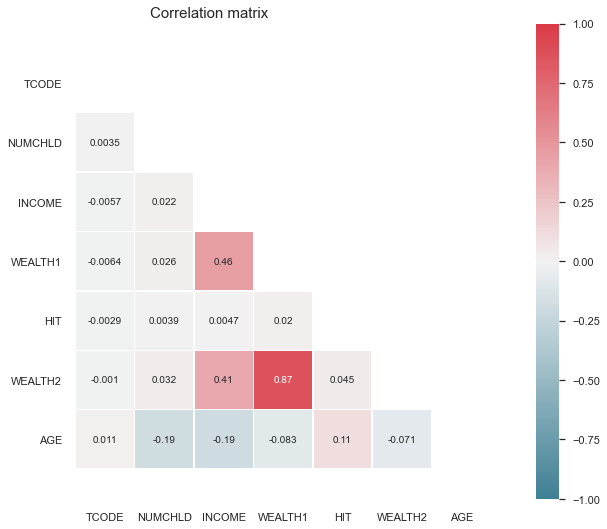

In [186]:
func.corrheatmap(df[char_feats])

There is no significant correlation except for WEALTH1 and WEALTH2

## **2.2. Interest** <a class="anchor" id="2.2"></a>

In [187]:
interest_feats = selected_features_list[selected_features_list['Category'] == 'Interests']['FeaturesName']
mail_feats = selected_features_list[selected_features_list['Category'] == 'Mail response']['FeaturesName']

### **A) Feature engineering:**

There are features containing binary information but they are not in the right data type for processing, so we convert them to binary type

In [188]:
df.loc[:, interest_feats].head()

COLLECT1 VETERANS BIBLE CATLG HOMEE PETS CDPLAY STEREO PCOWNERS  \
CONTROLN                                                                   
95515                                                                      
148535                                                                     
15078                                                                      
172556                                                                     
7112                           Y     Y                        Y            

         PHOTO CRAFTS FISHER GARDENIN BOATS WALKER KIDSTUFF CARDS PLATES  
CONTROLN                                                                  
95515                                                                     
148535                                                                    
15078                                                                     
172556                                                                    
7112                Y               Y            Y              Y

In [189]:
#Replace the values for booleans
df.loc[:,interest_feats] = df.loc[:,interest_feats].replace(' ',0)
df.loc[:,interest_feats] = df.loc[:,interest_feats].replace('Y',1)
df.loc[:,interest_feats].head()

COLLECT1  VETERANS  BIBLE  CATLG  HOMEE  PETS  CDPLAY  STEREO  \
CONTROLN                                                                  
95515            0         0      0      0      0     0       0       0   
148535           0         0      0      0      0     0       0       0   
15078            0         0      0      0      0     0       0       0   
172556           0         0      0      0      0     0       0       0   
7112             0         0      1      1      0     0       0       1   

          PCOWNERS  PHOTO  CRAFTS  FISHER  GARDENIN  BOATS  WALKER  KIDSTUFF  \
CONTROLN                                                                       
95515            0      0       0       0         0      0       0         0   
148535           0      0       0       0         0      0       0         0   
15078            0      0       0       0         0      0       0         0   
172556           0      0       0       0         0      0       0         0   
7112             0      0       1       0         1      0       1         0   

          CARDS  PLATES  
CONTROLN                 
95515         0       0  
148535        0       0  
15078         0       0  
172556        0       0  
7112          1       0

## **2.3. Mail response:** <a class="anchor" id="2.3"></a>

In [190]:
mail_feats = selected_features_list[selected_features_list['Category'] == 'Mail response']['FeaturesName']

### **A) Feature engineering:**

In [191]:
df.loc[:,mail_feats]

MBCRAFT  MBGARDEN  MBBOOKS  MBCOLECT  MAGFAML  MAGFEM  MAGMALE  \
CONTROLN                                                                   
95515         NaN       NaN      NaN       NaN      NaN     NaN      NaN   
148535        0.0       0.0      3.0       1.0      1.0     1.0      0.0   
15078         0.0       0.0      1.0       0.0      0.0     0.0      0.0   
172556        0.0       0.0      0.0       0.0      0.0     0.0      0.0   
7112          1.0       0.0      9.0       0.0      4.0     1.0      0.0   
...           ...       ...      ...       ...      ...     ...      ...   
184568        NaN       NaN      NaN       NaN      NaN     NaN      NaN   
122706        0.0       0.0      1.0       0.0      0.0     0.0      0.0   
189641        NaN       NaN      NaN       NaN      NaN     NaN      NaN   
4693          NaN       NaN      NaN       NaN      NaN     NaN      NaN   
185114        0.0       0.0      0.0       0.0      1.0     0.0      0.0   

          PUBGARDN  PUBCULIN  PUBHLTH  PUBDOITY  PUBNEWFN  PUBPHOTO  PUBOPP  
CONTROLN                                                                     
95515          NaN       NaN      NaN       NaN       NaN       NaN     NaN  
148535         0.0       0.0      2.0       0.0       3.0       0.0     0.0  
15078          0.0       0.0      1.0       0.0       0.0       0.0     0.0  
172556         0.0       0.0      0.0       0.0       0.0       0.0     1.0  
7112           0.0       0.0      4.0       0.0       1.0       0.0     1.0  
...            ...       ...      ...       ...       ...       ...     ...  
184568         NaN       NaN      NaN       NaN       NaN       NaN     NaN  
122706         0.0       0.0      0.0       0.0       0.0       0.0     0.0  
189641         NaN       NaN      NaN       NaN       NaN       NaN     NaN  
4693           NaN       NaN      NaN       NaN       NaN       NaN     NaN  
185114         0.0       0.0      0.0       0.0       0.0       0.0     1.0  

[95412 rows x 14 columns]

This features subset do not need any further engineering

### **B) Unique values check:**

title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manu

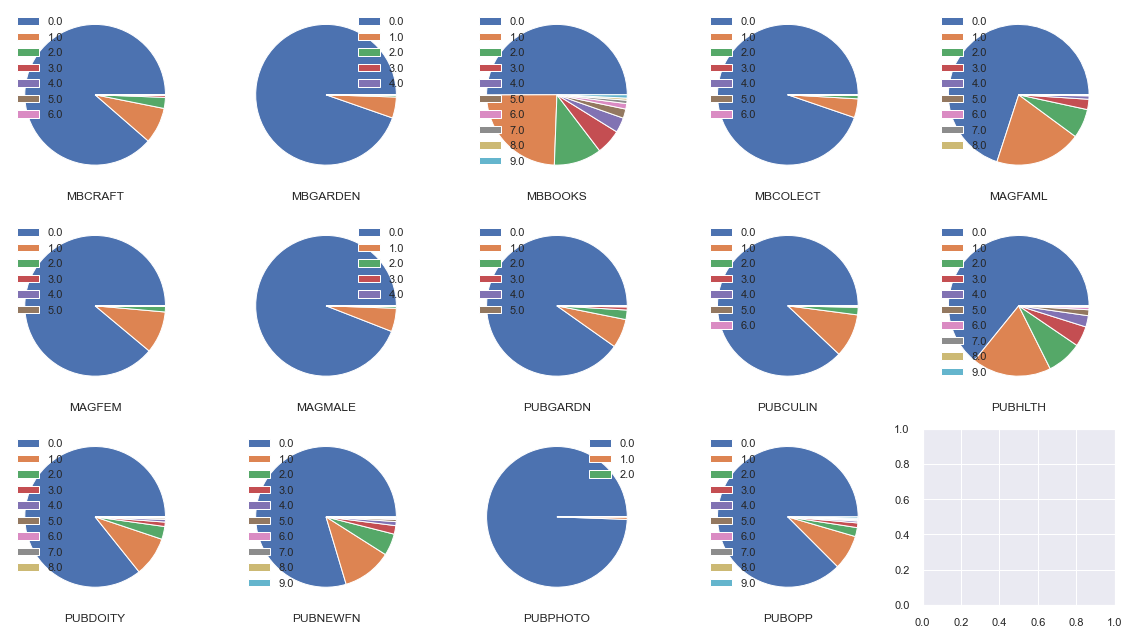

In [192]:
# Plot the result
plotdf = df.loc[:,mail_feats].apply(pd.value_counts)
#plot pie charts for all the interests
fig, axes = plt.subplots(3, ceil(len(plotdf.columns.to_list()) / 3), figsize=(20,11))
for ax, feat in zip(axes.flatten(), plotdf.columns.to_list()):
    ax.pie(plotdf[feat].dropna(),)
    ax.set_title(feat, y=-0.13)
    ax.legend(plotdf.index)
plt.show() 

### **C) Correlation check:**

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001C2159FDD60>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001C2159FDD60> on colorbar
Setting pcolormesh


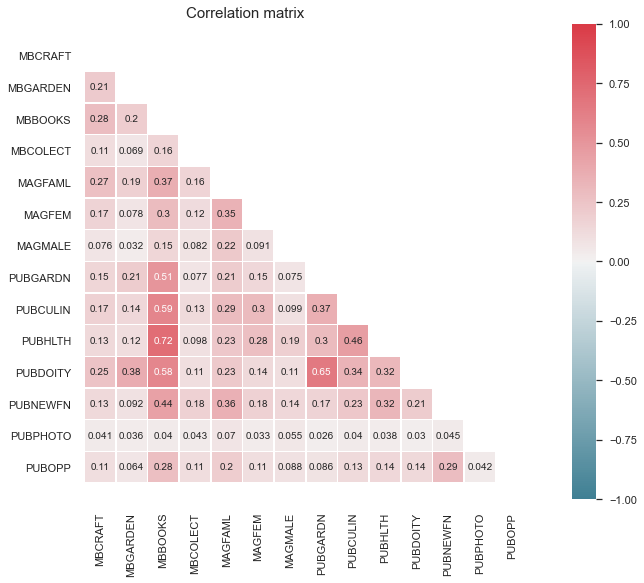

In [193]:
func.corrheatmap(df[mail_feats])

## **2.4. Neighborhood:** <a class="anchor" id="2.4"></a>

In [194]:
neighbor_feats = selected_features_list[selected_features_list['Category'] == 'Neighborhood']['FeaturesName']
# selected features
selected_features_list[selected_features_list['Category'] == 'Neighborhood']

FeaturesName                                     Description      Category  \
54       POP901                               Number of Persons  Neighborhood   
55      POP90C1            Percent Population in Urbanized Area  Neighborhood   
56      POP90C4                                    Percent Male  Neighborhood   
57         ETH1                                   Percent White  Neighborhood   
58         ETH2                                   Percent Black  Neighborhood   
59         ETH3                         Percent Native American  Neighborhood   
60         ETH4                  Percent Pacific Islander/Asian  Neighborhood   
61         ETH5                                Percent Hispanic  Neighborhood   
62         ETH6                            Percent Asian Indian  Neighborhood   
63       AGE901                        Median Age of Population  Neighborhood   
64        MARR1                                 Percent Married  Neighborhood   
65        MARR2                   Percent Separated or Divorced  Neighborhood   
66        MARR3                                 Percent Widowed  Neighborhood   
67        MARR4                           Percent Never Married  Neighborhood   
68         HHP2                    Average Person Per Household  Neighborhood   
69          HV1                   Median Home Value in hundreds  Neighborhood   
70          HV3                Median Contract Rent in hundreds  Neighborhood   
71          HU3                  Percent Occupied Housing Units  Neighborhood   
72          IC2                Median Family Income in hundreds  Neighborhood   
73          IC5                               Per Capita Income  Neighborhood   
74        TPE10           Median Travel Time to Work in minutes  Neighborhood   
75         LFC1                   Percent Adults in Labor Force  Neighborhood   
76         OCC1                            Percent Professional  Neighborhood   
77          EC1  Median Years of School Completed by Adults 25+  Neighborhood   
78         AFC1       Percent Adults in Active Military Service  Neighborhood   
79         AFC4                  Percent Adult Veterans Age 16+  Neighborhood   
80        POBC1                            Percent Foreign Born  Neighborhood   

   Selected  
54        x  
55        x  
56        x  
57        x  
58        x  
59        x  
60        x  
61        x  
62        x  
63        x  
64        x  
65        x  
66        x  
67        x  
68        x  
69        x  
70        x  
71        x  
72        x  
73        x  
74        x  
75        x  
76        x  
77        x  
78        x  
79        x  
80        x

### **A) Feature engineering:**

This features subset do not need any further engineering

In [195]:
df[neighbor_feats].head()

POP901  POP90C1  POP90C4  ETH1  ETH2  ETH3  ETH4  ETH5  ETH6  \
CONTROLN                                                                 
95515        992        0       47    92     1     0     0    11     0   
148535      3611       99       50    67     0     0    31     6     4   
15078       7001        0       49    96     2     0     0     2     0   
172556       640        0       54    61     0     0    11    32     6   
7112        2520       99       46     2    98     0     0     1     0   

          AGE901  ...  HU3   IC2    IC5  TPE10  LFC1  OCC1  EC1  AFC1  AFC4  \
CONTROLN          ...                                                         
95515         39  ...   96   318  12883     14    56     9  120     0    18   
148535        34  ...   97  1096  36175     24    70    22  160     0     8   
15078         35  ...   93   292  11576     19    65    10  120     0    10   
172556        32  ...   93   388  15130     13    69    17  120     0    13   
7112          33  ...   97   250   9836     24    61    17  120     1    15   

          POBC1  
CONTROLN         
95515         3  
148535       42  
15078         2  
172556       29  
7112          1  

[5 rows x 27 columns]

### **B) Unique values check:**

In [196]:
func.unique_check_numerical(df[neighbor_feats], 0.8)

['ETH6', 'AFC1']

In [197]:
func.check_value_counts(df[neighbor_feats])

POP901
0       799
1086     78
923      77
1094     75
834      73
Name: POP901, dtype: int64
-------------------
POP90C1
99    50548
0     35415
98      510
97      453
95      331
Name: POP90C1, dtype: int64
-------------------
POP90C4
49    18086
50    17284
48    14263
51    10067
47     9820
Name: POP90C4, dtype: int64
-------------------
ETH1
99    15689
98     8662
97     7133
96     6092
95     4961
Name: ETH1, dtype: int64
-------------------
ETH2
0    31240
1    18193
2     9336
3     5785
4     4068
Name: ETH2, dtype: int64
-------------------
ETH3
0    62275
1    24419
2     4306
3     1351
4      707
Name: ETH3, dtype: int64
-------------------
ETH4
0    37177
1    23722
2    10555
3     5691
4     3725
Name: ETH4, dtype: int64
-------------------
ETH5
1    22602
0    15803
2    11884
3     6999
4     4690
Name: ETH5, dtype: int64
-------------------
ETH6
0    80799
1    11412
2     1952
3      660
4      275
Name: ETH6, dtype: int64
-------------------
AGE901
33    8125
3

### **C) Correlation check:**

In [198]:
func.correlation_check(df[neighbor_feats],limit = 0.85)

High correlation columns are: ['IC5']


In [199]:
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
neighbor_feats = selected_features_list[selected_features_list['Category'] == 'Neighborhood']['FeaturesName']

## **2.5. Promotion and Gift:** <a class="anchor" id="2.5"></a>

In [200]:
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']
# selected features
selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']

FeaturesName                                        Description  \
81         RFA_3       Donor's RFA status as of 96NK promotion date   
82         RFA_4       Donor's RFA status as of 96TK promotion date   
83         RFA_5       Donor's RFA status as of 96SK promotion date   
84         RFA_6       Donor's RFA status as of 96LL promotion date   
85         RFA_7       Donor's RFA status as of 96G1 promotion date   
86         RFA_8       Donor's RFA status as of 96GK promotion date   
87         RFA_9       Donor's RFA status as of 96CC promotion date   
88        RFA_10       Donor's RFA status as of 96WL promotion date   
89        RFA_11       Donor's RFA status as of 96X1 promotion date   
90        RFA_12       Donor's RFA status as of 96XK promotion date   
91        RFA_13       Donor's RFA status as of 95FS promotion date   
92        RFA_14       Donor's RFA status as of 95NK promotion date   
93        RFA_15       Donor's RFA status as of 95TK promotion date   
94        RFA_16       Donor's RFA status as of 95LL promotion date   
95        RFA_17       Donor's RFA status as of 95G1 promotion date   
96        RFA_18       Donor's RFA status as of 95GK promotion date   
97        RFA_19       Donor's RFA status as of 95CC promotion date   
98        RFA_20       Donor's RFA status as of 95WL promotion date   
99        RFA_21       Donor's RFA status as of 95X1 promotion date   
100       RFA_22       Donor's RFA status as of 95XK promotion date   
101       RFA_23       Donor's RFA status as of 94FS promotion date   
102       RFA_24       Donor's RFA status as of 94NK promotion date   
103     CARDPROM     Lifetime number of card promotions received to   
104     MAXADATE     Date of the most recent promotion received (in   
105      NUMPROM     Lifetime number of promotions received to date   
106     CARDPM12     Number of card promotions received in the last   
107     NUMPRM12       Number of promotions received in the last 12   
108     RAMNTALL            Dollar amount of lifetime gifts to date   
109     NGIFTALL                   Number of lifetime gifts to date   
110     CARDGIFT  Number of lifetime gifts to card promotions to...   
111     MINRAMNT             Dollar amount of smallest gift to date   
112     MINRDATE     Date associated with the smallest gift to date   
113     MAXRAMNT              Dollar amount of largest gift to date   
114     MAXRDATE      Date associated with the largest gift to date   
115     LASTGIFT                  Dollar amount of most recent gift   
116     LASTDATE          Date associated with the most recent gift   
117     FISTDATE                                 Date of first gift   
118     NEXTDATE                                Date of second gift   
119      TIMELAG     Number of months between first and second gift   
120      AVGGIFT             Average dollar amount of gifts to date   
121       RFA_2R                             Recency code for RFA_2   
122       RFA_2F                           Frequency code for RFA_2   
123       RFA_2A                     Donation Amount code for RFA_2   
124     MDMAUD_R                            Recency code for MDMAUD   
125     MDMAUD_F                           Frequecy code for MDMAUD   
126     MDMAUD_A                    Donation Amount code for MDMAUD   

               Category Selected  
81   Promotion and Gift        x  
82   Promotion and Gift        x  
83   Promotion and Gift        x  
84   Promotion and Gift        x  
85   Promotion and Gift        x  
86   Promotion and Gift        x  
87   Promotion and Gift        x  
88   Promotion and Gift        x  
89   Promotion and Gift        x  
90   Promotion and Gift        x  
91   Promotion and Gift        x  
92   Promotion and Gift        x  
93   Promotion and Gift        x  
94   Promotion and Gift        x  
95   Promotion and Gift        x  
96   Promotion and Gift        x  
97   Promotion and Gift        x  
98   Promotion and Gift        x  
9

### **A) Feature engineering:**

**Generate RFA status of the each donor before they are considered to be Lapsed Donor:**

Because all the donors who are investigated in this dataset is all Lapsed Donors as the date of the lasted promotion, so we will not able to undestand the 'Recency' charateristics if we only consider the most recent code of the donor (all 'Lapsed').  

Therefore, we thought it would be interesting if we get the most recent type of code of each donor before they are considered to become Lapsed Donors

We will consider the data in features **Donor's RFA status as of XXXX promotion date (XXXX is from 'RFA_3'to 'RFA_24')**

In [201]:
# Replace the blank values with NaN value
df.loc[:,'RFA_3':'RFA_24'] = df.loc[:,'RFA_3':'RFA_24'].replace({' ' : np.NaN})
# Find the second most recent type of a donor by the left-most available values from RFA_3 to RFA_24
df['RFA_USEDTO'] = df.loc[:,'RFA_3':'RFA_24'].fillna(method = 'bfill',axis = 1)['RFA_3']
# Renerate R, F, A features
df['RFA_USEDTO_R'] = df['RFA_USEDTO'].apply(lambda x: str(x)[0])
df['RFA_USEDTO_F'] = df['RFA_USEDTO'].apply(lambda x: str(x)[1]).astype(int)
df['RFA_USEDTO_A'] = df['RFA_USEDTO'].apply(lambda x: str(x)[2])

# Add to the selected features list
feats = pd.DataFrame([['RFA_USEDTO_R', "Recency code of the previous status of the donor","Promotion and Gift","x" ],
                    ['RFA_USEDTO_F', "Frequency code of the previous status of the donor","Promotion and Gift","x"], 
                    ['RFA_USEDTO_A', "Amount code of the previous status of the donor","Promotion and Gift","x"]],
                    columns=selected_features_list.columns)
selected_features_list= selected_features_list.append(feats,ignore_index=True)

# Now drop the features that is no longer useful
df.drop(labels='RFA_USEDTO',axis=1,inplace = True, errors='ignore')
df.drop(labels=df.loc[:,'RFA_3':'RFA_24'].columns,axis=1,inplace=True,errors='ignore')

# Check for the result
df.loc[:,'RFA_USEDTO_R':'RFA_USEDTO_A'].head()

RFA_USEDTO_R  RFA_USEDTO_F RFA_USEDTO_A
CONTROLN                                        
95515               S             4            E
148535              A             2            G
15078               S             4            E
172556              S             4            E
7112                A             2            F

**Date-time features:**

There are 4 date-time features that we can assume that they will not have much interpretation power for clustering.  
Those features are: **'MINRDATE', 'MAXRDATE', 'NEXTDATE' and 'TIMELAG'**.  

Thus, we decided to drop them:

In [202]:
# Remove un-relevant features
df = df.drop(columns=['MINRDATE','MAXRDATE','NEXTDATE','TIMELAG'],errors='ignore')

The remaining date-time features are 'MAXADATE', 'LASTDATE' and 'FISTDATE'. These features are useful to generate two important features in RFM (Recency, Frequency and Monetary) analysis which are Recency and Frequency.  

The 2 new features to generate are:
- Time in days since the last promotion and the last gift from the donor: 'RECENCY' = 'MAXADATE' - 'LASTDATE'  
- Time in days since the last promotion and the first gift from the donor: 'LIFETIME' = 'MAXADATE' - 'FISTDATE' 

In [203]:
# convert data to datetime 
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'])
df['LASTDATE'] = pd.to_datetime(df['LASTDATE'])
df['FISTDATE'] = pd.to_datetime(df['FISTDATE'])
# measure the recency and lifetime of donors
df['RECENCY'] = (df['MAXADATE'] - df['LASTDATE'])/pd.to_timedelta(1, unit='D')
df['LIFETIME'] = (df['MAXADATE'] - df['FISTDATE'])/pd.to_timedelta(1, unit='D')

# Add new features to the metadata
feats = pd.DataFrame([['RECENCY', "Time in days since the last promotion and the last gift from the donor","Promotion and Gift","x" ],
                    ['LIFETIME', "Time in days since the last promotion and the first gift from the donor","Promotion and Gift","x"]], 
                    columns=selected_features_list.columns)
selected_features_list= selected_features_list.append(feats,ignore_index=True)
                      
# Then we drop the datetime columns:
df = df.drop(columns=['MAXADATE','FISTDATE','LASTDATE'],errors='ignore')

# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']

### **B) Unique values check:**

In [204]:
df[PG_feats].describe(include=['O'])

RFA_2R RFA_2A MDMAUD_R MDMAUD_F MDMAUD_A RFA_USEDTO_R RFA_USEDTO_A
count   95412  95412    95412    95412    95412        95412        95412
unique      1      4        5        4        5            8            7
top         L      F        X        X        X            A            F
freq    95412  46964    95118    95118    95118        60156        46170

In [205]:
func.unique_check_categorical(df[PG_feats], 0.95)

RFA_2R , percentage of top unique value = 100.00 %
MDMAUD_R , percentage of top unique value = 99.69 %
MDMAUD_F , percentage of top unique value = 99.69 %
MDMAUD_A , percentage of top unique value = 99.69 %


We can clearly see that features **'RFA_2R', 'MDMAUD_R', 'MDMAUD_F' and 'MDMAUD_A'** having only 1 values for mostly all of their records, thus they are considered redundant in this cluster analysis

In [206]:
# Drop these redundant columns
df = df.drop(columns=['RFA_2R', 'MDMAUD_R', 'MDMAUD_F','MDMAUD_A'],errors='ignore')
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']

### **C) Correlation check:**

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001C20E1CDC40>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001C20E1CDC40> on colorbar
Setting pcolormesh


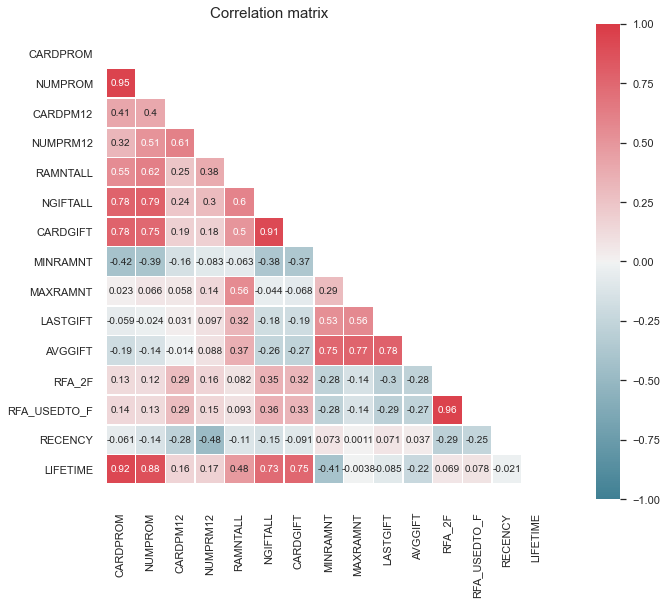

In [207]:
func.corrheatmap(df[PG_feats])

In [208]:
func.correlation_check(df[PG_feats])

High correlation columns are: ['NUMPROM', 'CARDGIFT', 'RFA_USEDTO_F', 'LIFETIME']


In [209]:
# Drop these redundant columns
df = df.drop(columns=['NUMPROM', 'CARDGIFT', 'LIFETIME'])
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']

### Check for data preprocessing result

In [210]:
# Current dataframe
df.head()

ODATEDW OSOURCE  TCODE STATE    ZIP DOMAIN HOMEOWNR  NUMCHLD  \
CONTROLN                                                                    
95515     2009-01-01     GRI      0    IL  61081     T2      NaN      NaN   
148535    2014-01-01     BOA      1    CA  91326     S1        H      1.0   
15078     2010-01-01     AMH      1    NC  27017     R2        U      NaN   
172556    2007-01-01     BRY      0    CA  95953     R2        U      NaN   
7112      2006-01-01     NaN      0    FL  33176     S2        H      1.0   

          INCOME GENDER  ...  LASTGIFT    AVGGIFT  RFA_2F  RFA_2A  GEOCODE2  \
CONTROLN                 ...                                                  
95515        NaN      F  ...      10.0   7.741935       4       E         C   
148535       6.0      M  ...      25.0  15.666667       2       G         A   
15078        3.0      M  ...       5.0   7.481481       4       E         C   
172556       1.0      F  ...      10.0   6.812500       4       E         C   
7112         3.0      F  ...      15.0   6.864865       2       F         A   

           AGE  RFA_USEDTO_R  RFA_USEDTO_F  RFA_USEDTO_A  RECENCY  
CONTROLN                                                           
95515     59.0             S             4             E    428.0  
148535    45.0             A             2             G    428.0  
15078      NaN             S             4             E    428.0  
172556    69.0             S             4             E    428.0  
7112      77.0             A             2             F    397.0  

[5 rows x 90 columns]

In [211]:
# Summary features by category
pd.DataFrame(selected_features_list.groupby('Category')['FeaturesName'].count())

FeaturesName
Category                        
Characteristics               16
Interests                     18
Mail response                 14
Neighborhood                  27
Promotion and Gift            15

# **3. Data cleanning:** <a class="anchor" id="3"></a>

In [212]:
# Setting variable:
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']
interest_feats = selected_features_list[selected_features_list['Category'] == 'Interests']['FeaturesName']
mail_feats = selected_features_list[selected_features_list['Category'] == 'Mail response']['FeaturesName']
neighbor_feats = selected_features_list[selected_features_list['Category'] == 'Neighborhood']['FeaturesName']
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']


# Assigning categorical and numeric features
PG_feats_categorical = df[PG_feats].loc[:,df[PG_feats].dtypes == 'O'].columns
PG_feats_numeric = df[PG_feats].loc[:,df[PG_feats].dtypes != 'O'].columns
PG_feats_numeric = PG_feats_numeric.drop(['RFA_2F','RFA_USEDTO_F'])
PG_feats_categorical = np.append(PG_feats_categorical,['RFA_2F','RFA_USEDTO_F'])

## **3.1. Check for non-sense data :** <a class="anchor" id="3.1"></a>

At this part, we will try to identify and clear the observations that is not possible to be recorded with subjective intuition. These kind of observations can be identified using `describe()` method and some other understanding of the features on the basis level. We also carry out some research on the features themselves in order to be as most objective as possible in our desicion.

### 3.1.1. Characteristics features subset:

In [213]:
df[char_feats].describe()

TCODE       NUMCHLD        INCOME       WEALTH1           HIT  \
count  95412.000000  12386.000000  74126.000000  50680.000000  95412.000000   
mean      54.223117      1.527773      3.886248      5.345699      3.321438   
std      953.844476      0.806861      1.854960      2.742490      9.306899   
min        0.000000      1.000000      1.000000      0.000000      0.000000   
25%        0.000000      1.000000      2.000000      3.000000      0.000000   
50%        1.000000      1.000000      4.000000      6.000000      0.000000   
75%        2.000000      2.000000      5.000000      8.000000      3.000000   
max    72002.000000      7.000000      7.000000      9.000000    241.000000   

            WEALTH2           AGE  
count  51589.000000  71529.000000  
mean       4.954525     58.376043  
std        2.802759     16.725625  
min        0.000000     -1.000000  
25%        3.000000     46.000000  
50%        5.000000     59.000000  
75%        7.000000     73.000000  
max        9.000000     87.000000

Here we notice that AGE features have the minimum value of -1 which is clearly impossible, thus we decide to drop these obseravation.

In [214]:
#dropping invalid age values
print('Number of invalid observations:', len(df[(df.AGE <= 0)]))
#dropping invalid age values
df = df[~(df.AGE <= 0)]

Number of invalid observations: 13


### 3.1.2. Neighborhood features subset:

In [215]:
df[neighbor_feats].describe()

POP901       POP90C1       POP90C4          ETH1          ETH2  \
count  95399.000000  95399.000000  95399.000000  95399.000000  95399.000000   
mean    3256.087821     58.588298     48.211868     84.853562      7.467825   
std     5743.554329     47.430864      5.565894     21.014962     16.691670   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      990.000000      0.000000     47.000000     82.000000      0.000000   
50%     1565.000000     99.000000     49.000000     93.000000      1.000000   
75%     3091.000000     99.000000     50.000000     98.000000      6.000000   
max    98701.000000     99.000000     99.000000     99.000000     99.000000   

               ETH3          ETH4          ETH5          ETH6        AGE901  \
count  95399.000000  95399.000000  95399.000000  95399.000000  95399.000000   
mean       0.776979      2.905838      7.458579      0.215988     34.474953   
std        3.469546      7.070198     13.786839      0.679248      8.335039   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      1.000000      0.000000     30.000000   
50%        0.000000      1.000000      2.000000      0.000000     33.000000   
75%        1.000000      3.000000      7.000000      0.000000     37.000000   
max       99.000000     99.000000     99.000000     22.000000     84.000000   

       ...           HU3           IC2            IC5         TPE10  \
count  ...  95399.000000  95399.000000   95399.000000  95399.000000   
mean   ...     89.966425    387.026971   15722.584618     19.480749   
std    ...     12.955908    173.615753    8563.828315      6.773020   
min    ...      0.000000      0.000000       0.000000      0.000000   
25%    ...     89.000000    274.000000   10788.000000     15.000000   
50%    ...     94.000000    355.000000   13727.000000     19.000000   
75%    ...     96.000000    465.000000   18168.000000     23.000000   
max    ...     99.000000   1500.000000  174523.000000     90.000000   

               LFC1          OCC1           EC1          AFC1          AFC4  \
count  95399.000000  95399.000000  95399.000000  95399.000000  95399.000000   
mean      64.531987     14.122423    128.021782      0.596516     15.574241   
std       13.601058      8.231127     17.736020      3.169537      5.270426   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       59.000000      8.000000    120.000000      0.000000     12.000000   
50%       66.000000     13.000000    120.000000      0.000000     15.000000   
75%       73.000000     18.000000    140.000000      0.000000     19.000000   
max       99.000000     99.000000    170.000000     97.000000     99.000000   

              POBC1  
count  95399.000000  
mean       6.625111  
std        9.646520  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        8.000000  
max       99.000000  

[8 rows x 27 columns]

Using the same method, we can identify several features having invalid values:
- `AGE901 - Median age of the population`: Having '0' values
- `HHP2 - Average Person Per Household`: Having '0' values
- `EC1 - Median Years of School Completed by Adults 25+`: Having invalid range of values

In [216]:
#dropping invalid age values
print('Number of invalid observations:', len(df[(df.AGE901 <= 0)])+ len(df[(df.HHP2 == 0)]))
# save the index for later imputing
invalid_records = pd.concat([df[df.AGE901 <= 0] , df[df.HHP2 == 0]], axis = 0)
#dropping invalid age values
df = df[~(df.AGE901 <= 0)]
#dropping row for places with Average Person Per Household = 0
df = df[~(df.HHP2 == 0)]

Number of invalid observations: 1616


In [217]:
print(df.EC1.describe())

count    94582.000000
mean       129.054344
std         13.469160
min         89.000000
25%        120.000000
50%        120.000000
75%        140.000000
max        170.000000
Name: EC1, dtype: float64


In [218]:
#based on this statistic we can see that the column related to 'Median Years of School Completed by Adults 25+' has no valid values so we will drop it
df.drop('EC1', axis=1,inplace=True,errors='ignore')
neighbor_feats = neighbor_feats[neighbor_feats != 'EC1']

### 3.1.3. Promotion & Gift:

In [219]:
invalid_records = pd.concat([invalid_records , df[df['RECENCY']<=0]], axis = 0, join='inner')
print('Number of invalid observations:', len(df[df['RECENCY']<=0]))
#dropping invalid recency values
df = df[df['RECENCY']>0]

Number of invalid observations: 822


## **3.2. Outliers:** <a class="anchor" id="3.2"></a>

### Numeric Variables' Univariate Distribution

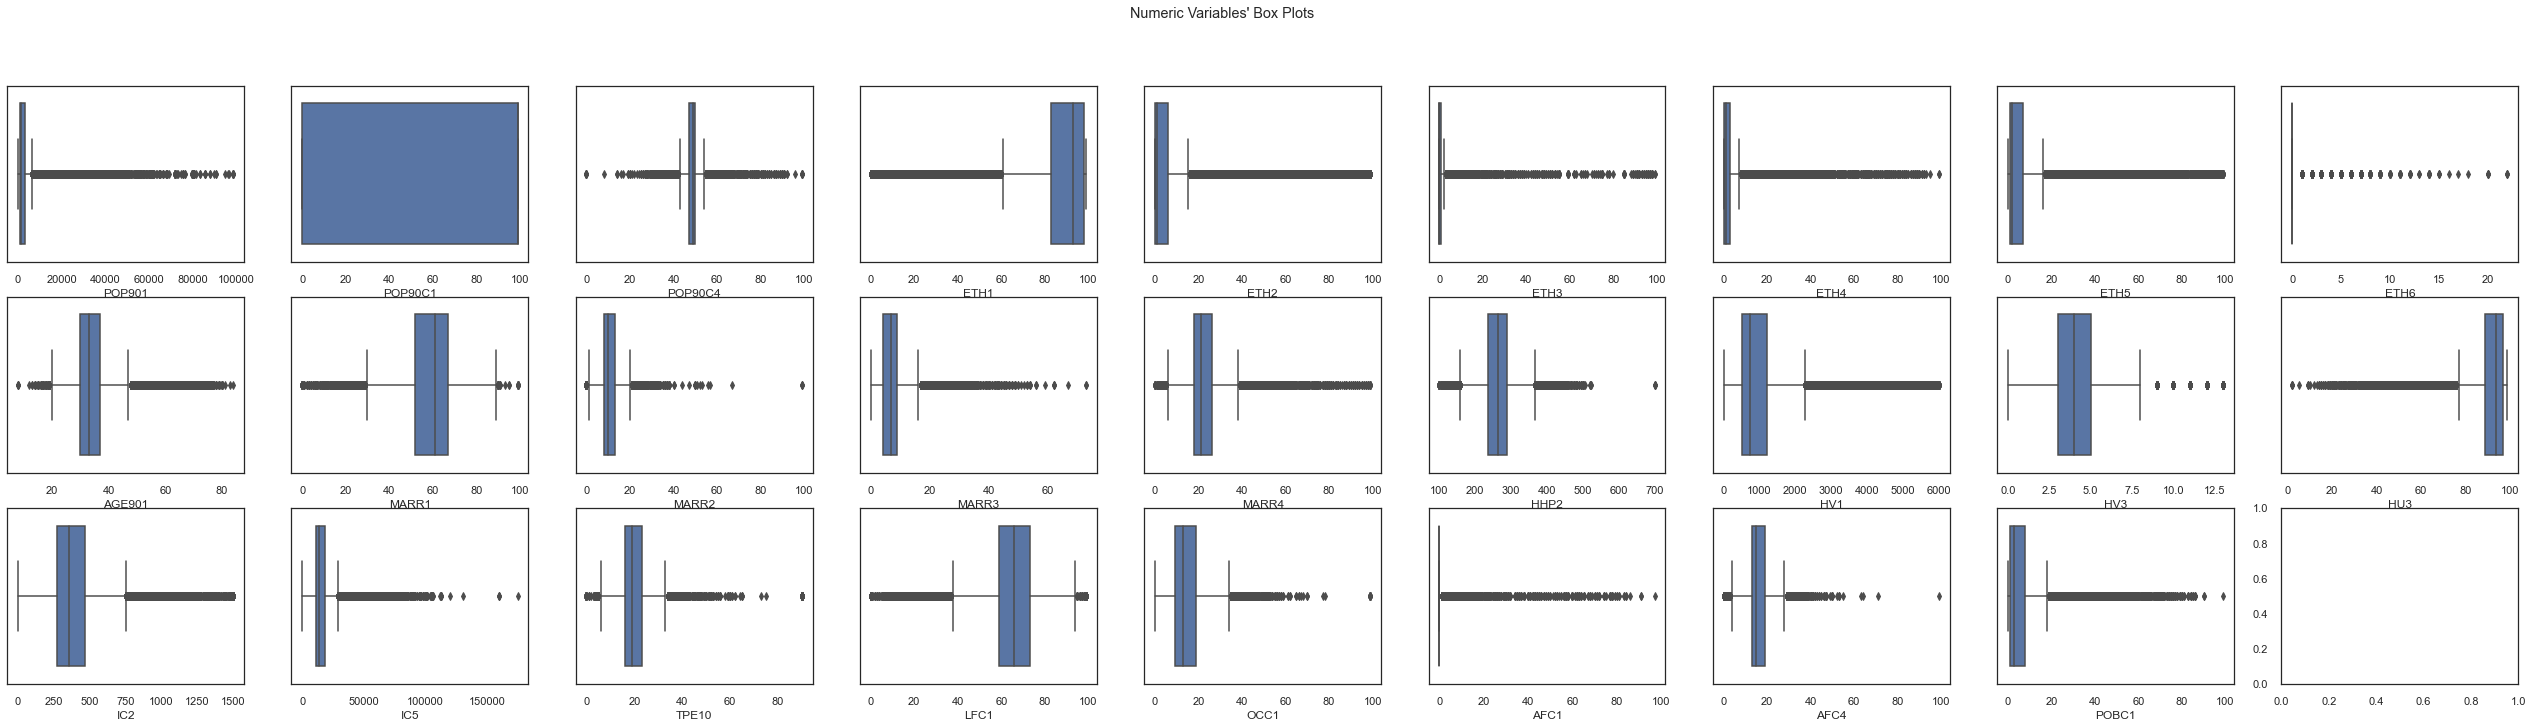

In [253]:
# All Numeric Variables' Box Plots in one figure
# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(neighbor_feats) / 3), figsize=(45, 11))
# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), neighbor_feats): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"
plt.suptitle(title)
#plt.savefig('numeric_variables_boxplots.png')
plt.show()

### Pairwise Relationship of Numerical Variables

In [221]:
# Pairwise Relationship of Numerical Variables
#sns.set()

# Setting pairplot
#sns.pairplot(df[metric_features], diag_kind="hist")

# Layout
#plt.subplots_adjust(top=0.95)
#plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

#plt.savefig('pairwise_relationship_of_numerical_variables.png')
#plt.show()

<img src="figures/pairwise_relationship_of_numerical_variables.png">

### Multivariate outliers:

### Local outlier factor (LOF) on Promotion and Gift features

In [222]:
#clf = LocalOutlierFactor(n_neighbors=500, contamination="auto")
# Transform with standard scaler
#df_lof = StandardScaler().fit_transform(df[PG_feats_numeric])
# Now predict the outliers
#y_pred = clf.fit_predict(df_lof)
# Save the score
#X_scores = pd.Series(clf.negative_outlier_factor_,index = df[PG_feats_numeric].index)

In [254]:
#figure
#sns.set_style("whitegrid")
#fig,ax = plt.subplots(figsize=(15,8))
#fig.suptitle("LOF scree plot", fontsize=25)
#data
#ax.plot(np.sort(X_scores[(X_scores<0)&(X_scores>-10)]))
#layout
#ax.set_title("1: Original graphic")
#plt.subplots_adjust(hspace=0.3)
#plt.show()

<img src="figures/LOF.png">

From the LOF scree plot, we can confirm that the outlier can be the observations that have the LOF negative score below -2. we will save this mask of outliers for later consideration

In [224]:
#outlier_lof_PG_feats = X_scores[(X_scores<-2)].index

## **3.3. Data transformation:** <a class="anchor" id="3.3"></a>

### Promotion and Gift features:

In [259]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

def log10_transformer(df, columns):
    df_out = df.copy()
    for col in columns:
        # we add 1 to the value because some of the columns might contain 0 and they will make the logarithm to result infinity
        df_out.loc[:,col] = np.log10(df.loc[:,col]+1)
        df_out = df_out.rename(columns={col:'LOG_'+col})
    #df = df.drop(columns = columns)
    return df_out

def boxplot_withoutLabels(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set()
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(16,4*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.boxplot(y=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)

    # Finalize the plot
    plt.subplots_adjust(wspace=2,hspace = 0.5)
    fig.suptitle("Box plots", fontsize=25)
    sns.despine(bottom=True)
    plt.show()

def kmeans_R2(df,clusters):
    ''' Use this function to measure the R2 of clustering method by Kmeans'''
    # Apply the cluster
    kmclust = KMeans(n_clusters=clusters, init="k-means++", n_init=20, random_state=1)
    kmclust.fit(df)
    # the predict method
    KM_labels = kmclust.predict(df)
    # Concatenating the labels to df
    df_concat = pd.concat([df, pd.Series(KM_labels, index=df.index, name="KM_labels")], axis=1)
    # Computing the R^2 of the cluster solution
    sst = get_ss(df)  # get total sum of squares
    ssw_labels = df_concat.groupby(by='KM_labels').apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2_ = ssb / sst
    print("Cluster solution with R^2 of %0.4f" % r2_)
    return

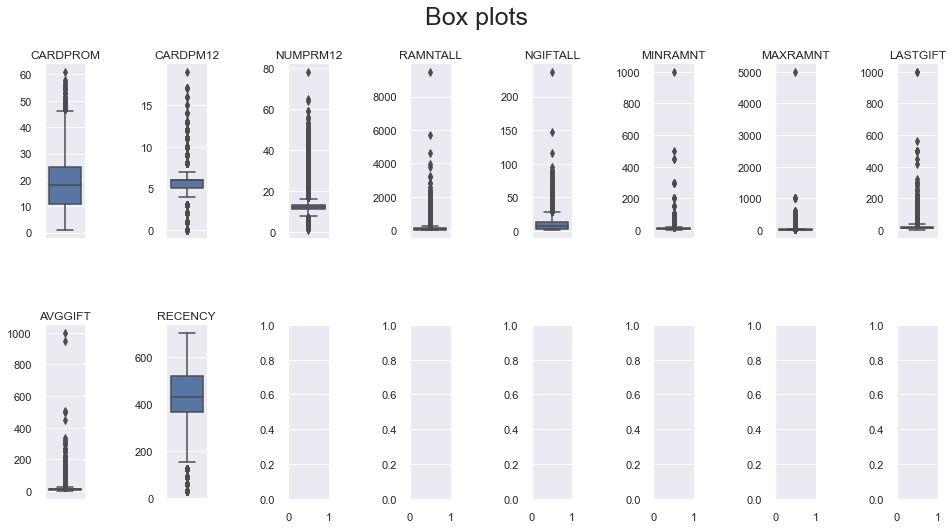

In [260]:
boxplot_withoutLabels(df[PG_feats_numeric])

- In the boxplots showed above, we can clearly see that the distribution of the these features are highly skewed and maybe contain outliers. In the following steps, we will consider multiple techniques to transform the dataset in order to making it more Gausian-like and identify the outliers

In [227]:
# Box-cox transformation
t_boxcox = PowerTransformer(method='box-cox')
df_transform_boxcox = t_boxcox.fit_transform(df[PG_feats_numeric]+1)
# Yeo-johnson transformation
t_yeojohnson = PowerTransformer(method='yeo-johnson')
df_transform_yeojohnson = t_yeojohnson.fit_transform(df[PG_feats_numeric])
# Quantile transformation
t_quantile = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=0)
df_transform_quantile = t_quantile.fit_transform(df[PG_feats_numeric])
# Logarithm transformation
df_transform_log = log10_transformer(df[PG_feats_numeric], PG_feats_numeric)

# Now measure the R2 for each transformation
scores_name = ['kmeans_normal', 'kmeans_log', 'kmeans_boxcox', 'kmeans_yeo_johnson', 'kmeans_quantile']
df_to_transform = [df[PG_feats_numeric], df_transform_log, df_transform_boxcox, df_transform_yeojohnson, df_transform_quantile]
r2_scores = {}
kmclust = KMeans(init="k-means++", n_init=20, random_state=1)
#for score, df_toTF in zip(scores_name,df_to_transform):
#    scaler = StandardScaler()
#    scaled_df_toTF = pd.DataFrame(scaler.fit_transform(df_toTF), index=df[PG_feats_numeric].index, columns=df[PG_feats_numeric].columns)
#    r2_scores[score] = get_r2_scores(scaled_df_toTF, kmclust)

In [228]:
#pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

#plt.title("Transformation methods:\nR2 plot for various transformation methods\n", fontsize=21)
#plt.legend(title="Cluster methods", title_fontsize=11)
#plt.xlabel("Number of clusters", fontsize=13)
#plt.ylabel("R2 metric", fontsize=13)
#plt.show()

<img src="figures/Transformation_methods_R2.png">

From the above plot, we can conclude that the logarithm 10 transformation reserve the most R2 score. Thus we decide to use log10 transformation on the data

In [230]:
df_transform_log = log10_transformer(df[PG_feats_numeric], PG_feats_numeric)
#df_transform_log_outlier_remove = log10_transformer(df.loc[~df.index.isin(PG_feats_outlier_lof), PG_feats_numeric], PG_feats_numeric)

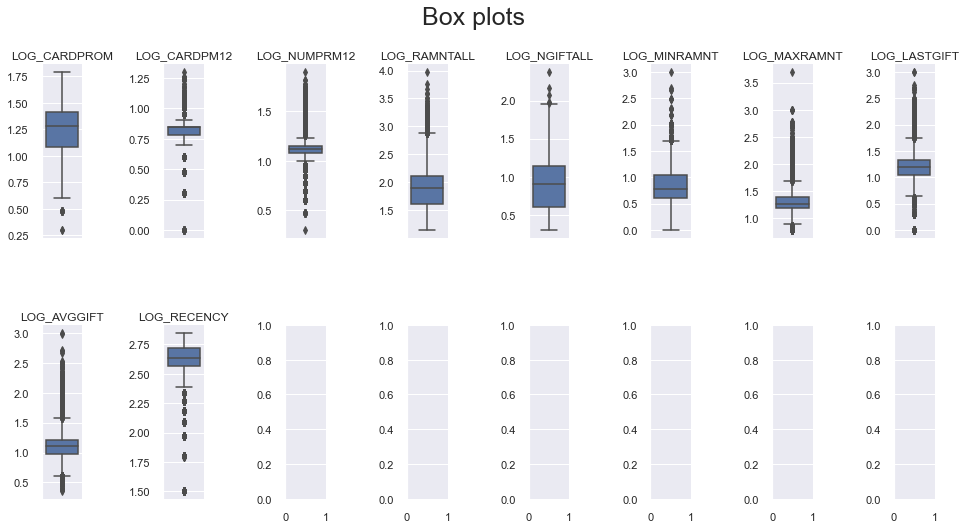

In [232]:
# Transformed with log10
#boxplot_withoutLabels(df_transform_log_outlier_remove)
boxplot_withoutLabels(df_transform_log)

From the boxplot, there is posibility that the distribution of some features have quite low variance and maybe have high kurtosis. Thus, we will check for the Kurtosis value of each features so verify this assumption.

In [233]:
def distribution_check(df, name):
    kur = {}
    skewness = {}
    for col in df.columns:
        if df[col].dtype != 'O':
            kur[col] = kurtosis(df[col], fisher=True)
            skewness[col] = skew(df[col])
    kur_df = pd.DataFrame.from_dict(kur, orient='index',columns=['Kurtosis'])
    skew_df = pd.DataFrame.from_dict(skewness, orient='index',columns=['Skewness'])
    concat_df = pd.concat([skew_df,kur_df],axis = 1)
    concat_df.index.rename(name,inplace = True)
    return concat_df

def display_side_by_side(*args):
    '''Source: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side'''
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Check for the transformation:
display_side_by_side(distribution_check(df[PG_feats_numeric], "Normal"),
                     distribution_check(df_transform_log, "LogTransform"))
                    #distribution_check(df_transform_log_outlier_remove, "OutlierRemoved"))

Skewness 
 Kurtosis 
 
 
 Normal 
 
 
 
 
 
 
 CARDPROM 
 0.146067 
 -0.947090 
 
 
 CARDPM12 
 0.194285 
 4.746901 
 
 
 NUMPRM12 
 2.974790 
 13.421804 
 
 
 RAMNTALL 
 13.205141 
 660.298327 
 
 
 NGIFTALL 
 2.063960 
 11.626976 
 
 
 MINRAMNT 
 24.141201 
 2046.955291 
 
 
 MAXRAMNT 
 108.429973 
 21635.571268 
 
 
 LASTGIFT 
 16.327836 
 759.326754 
 
 
 AVGGIFT 
 25.545168 
 1804.750437 
 
 
 RECENCY 
 -0.304900 
 1.819310 
 
 
 
 
 
 
 Skewness 
 Kurtosis 
 
 
 LogTransform 
 
 
 
 
 
 
 LOG_CARDPROM 
 -0.600559 
 -0.580212 
 
 
 LOG_CARDPM12 
 -1.393160 
 5.384029 
 
 
 LOG_NUMPRM12 
 0.725013 
 4.678910 
 
 
 LOG_RAMNTALL 
 0.096231 
 -0.313416 
 
 
 LOG_NGIFTALL 
 -0.074429 
 -0.777660 
 
 
 LOG_MINRAMNT 
 0.455549 
 0.433017 
 
 
 LOG_MAXRAMNT 
 0.695712 
 3.449074 
 
 
 LOG_LASTGIFT 
 -0.367388 
 3.126807 
 
 
 LOG_AVGGIFT 
 0.362018 
 1.398057 
 
 
 LOG_RECENCY 
 -3.741807 
 20.290800

It is clear from the result above that transforming  `CARDPM12` and `RECENCY` features generate worse result in term of both skewness and kurtosis value.
Hence, we will not transfrom these features with logarithm transformation for clustering

In [234]:
log10_transformer(df[PG_feats_numeric], PG_feats_numeric.drop(['CARDPM12','RECENCY']))

LOG_CARDPROM  CARDPM12  LOG_NUMPRM12  LOG_RAMNTALL  LOG_NGIFTALL  \
CONTROLN                                                                     
95515         1.447158         6      1.176091      2.382017      1.505150   
148535        1.113943         6      1.146128      1.681241      0.602060   
15078         1.431364         6      1.176091      2.307496      1.447158   
172556        1.447158         6      1.176091      2.041393      1.230449   
7112          1.643453        10      1.414973      2.406540      1.579784   
...                ...       ...           ...           ...           ...   
184568        0.845098         5      1.113943      1.414973      0.301030   
122706        0.698970         3      0.954243      1.322219      0.301030   
189641        1.176091         7      1.255273      1.770852      0.903090   
4693          1.568202         9      1.505150      2.698101      1.623249   
185114        1.518514         6      1.556303      3.577032      1.602060   

          LOG_MINRAMNT  LOG_MAXRAMNT  LOG_LASTGIFT  LOG_AVGGIFT  RECENCY  
CONTROLN                                                                  
95515         0.778151      1.113943      1.041393     0.941608    428.0  
148535        1.041393      1.414973      1.414973     1.221849    428.0  
15078         0.477121      1.230449      0.778151     0.928472    428.0  
172556        0.477121      1.079181      1.041393     0.892790    428.0  
7112          0.602060      1.204120      1.204120     0.895691    397.0  
...                ...           ...           ...          ...      ...  
184568        1.414973      1.414973      1.414973     1.414973    366.0  
122706        1.322219      1.322219      1.322219     1.322219    337.0  
189641        0.602060      1.041393      1.041393     0.967815    123.0  
4693          0.778151      1.342423      1.278754     1.118805     31.0  
185114        1.041393      2.305351      2.004321     1.990316     62.0  

[93760 rows x 10 columns]

# **4. Clustering:** <a class="anchor" id="4"></a>

In [235]:
def clusters_score(df, range_clusters = (2, 8)):
    '''Reference: https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad'''
    metric_name = ['distortion','Davies Bouldin', 'calinski_harabasz']
    db_score = []
    model = KMeans(init='k-means++', n_init=15)
    # measure Davies Bouldin score
    for n_clus in range(range_clusters[0],range_clusters[1]):  # iterate over desired ncluster range
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
        
        labels_db = kmclust.fit_predict(df)   
        
        db_score.append(davies_bouldin_score(df, labels_db))
        
    db_score = pd.Series(db_score, index = range(range_clusters[0],range_clusters[1]))
    # The score plots
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1,3, constrained_layout=False, figsize=(15,5))
    fig.suptitle("Elbow plot for each features\n", fontsize=25)
    # Draw nested boxplots
    
    for metric, ax in zip(metric_name, axes.flatten()):
        if  metric == 'Davies Bouldin':
            sns.lineplot(data=db_score, ax=ax )
            sns.despine(offset=10, trim=True,ax = ax)  
        else: 
            sns.set_style("whitegrid")
            visualizer = KElbowVisualizer(model, k=range_clusters, metric=metric, timings= False, locate_elbow=False, ax=ax)
            visualizer.fit(df)        # Fit the data to the visualizer
        sns.despine(offset=10, trim=True,ax = ax)
        ax.set_xlabel("Number of clusters")
        ax.set_ylabel("Metrics")
        #ax.tick_params(axis='x',labelsize = 'small') 
        ax.set_title(metric)
        
    fig.subplots_adjust(wspace=0.5)    
    plt.show()    

In [334]:
def inertia_plot(df):
    range_clusters = range(1, 11)

    inertia = []
    for n_clus in range_clusters:  # iterate over desired ncluster range
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
        kmclust.fit(df)
        inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution
    sns.set_style("whitegrid")
    # The inertia plot
    plt.figure(figsize=(9,5))
    plt.plot(pd.Series(inertia, index = range_clusters))
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters")
    plt.title("Inertia plot over clusters", size=15)
    plt.show()   

In [349]:
# Function to plot boxplot for each features based on clusters
def boxplot_withLabels(df, labels):
    # Concatenate the dataframe with the labels
    df_concat = pd.concat((df, pd.Series(labels, name='labels', index = df.index)), axis=1)
    # Set up figure
    rows = math.ceil(df.shape[1]/4)
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(rows,4, constrained_layout=False, figsize=(24,5*rows))
    fig.suptitle("Box plot for each features\n", fontsize=25)
    # Draw nested boxplots
    for col, ax in zip(df.columns, axes.flatten()):
        sns.boxplot(x='labels', y=col, data=df_concat, ax=ax )
        sns.despine(offset=10, trim=True,ax = ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.tick_params(axis='x',labelsize = 'large') 
        ax.set_title(col,fontsize = 15)  
    fig.subplots_adjust(hspace=0.3)
    plt.show()

In [270]:
def meanplot_df(df, labels):
    df_concat = pd.concat((df, pd.Series(labels, name='labels',index = df.index)), axis=1)
    plot_data = df_concat.groupby('labels').mean()
    sns.set_style("whitegrid")
    # Plot PCA data
    fig, ax = plt.subplots(figsize = (24,12))
    ax = sns.lineplot(data = plot_data.T,dashes = False)
    plt.xticks(rotation=45)
    plt.show()  

In [239]:
def silhouette_analysis(df, estimator, shape, figsize, max_nclus, min_nclus=2, dist="euclidean"):
    """
    This function calculates the silhouette coefficient for each observation according to a clustering solution and then builds the 
    Silhouette plots for a given range of cluster solutions. This is useful to find out the most appropriate number of clusters.
    """
    range_n_clusters = list(range(min_nclus, max_nclus+1))  
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    if len(range_n_clusters)==1: # in case we want to seed the silhouette for just one cluster solution
        forax = [axes]
    else:
        forax = axes.flatten()
    for ax, n_clusters in zip(forax, range_n_clusters):
        
        # Get parameter that defines number of clusters
        if "n_clusters" in estimator.get_params():
            param = "n_clusters"
        elif "n_components" in estimator.get_params():
            param = "n_components"
        else:
            print("Estimator has no parameter to define number of clusters")
            return None
        
        # Get the cluster labels by applying a given clustering algorithm
        clustering = estimator.set_params(**{param:n_clusters})
        labels = clustering.fit_predict(df)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, labels, metric=dist)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, labels, metric=dist)
        
        # The silhouette coefficient can range from -1, 1
        ax.set_xlim([sample_silhouette_values.min()-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, df.shape[0] + (n_clusters + 1) * 10]) 
        
        y_lower = 10 # initialize y_lower
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        ax.set_title("{} Clusters".format(n_clusters), fontsize=13)
        ax.set_xlabel("Silhouette Coefficients")
        ax.set_ylabel("Cluster Labels")
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette") # The vertical line for average silhouette score of all the values
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ["Average Silhouette = {0:.2f}".format(silhouette_avg)])
    
    plt.subplots_adjust(hspace=0.35)
    plt.suptitle(("Clustering Silhouette Plots"), fontsize=23, fontweight='bold')
    plt.show()

In [240]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def dendogram_hclust(hclust, threshold = 50):
    # create the counts of samples under each node (number of points being merged)
    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    # hclust.children_ contains the observation ids that are being merged together
    # At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
    for i, merge in enumerate(hclust.children_):
        # track the number of observations in the current cluster being formed
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                # If this is True, then we are merging an observation
                current_count += 1  # leaf node
            else:
                # Otherwise, we are merging a previously formed cluster
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
    # the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
    # the counts indicate the number of points being merged (dendrogram's x-axis)
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(11,5))
    # The Dendrogram parameters need to be tuned
    y_threshold = threshold
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{distance.title()} Distance', fontsize=13)
    plt.show()


In [241]:
def R2(df,df_concat, labels):
    sst = get_ss(df)  # get total sum of squares
    ssw_labels = df_concat.groupby(by=labels).apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2_ = ssb / sst
    return print("Cluster solution with R^2 of %0.4f" % r2_) 

In [242]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color
    
class PCA_combined(object):
    def __init__(self, df):
        self.df = df
        self.n_components = df.shape[1]
        self.pca_model = PCA(n_components = df.shape[1])

    def Explained_variance(self):
        pca = PCA()
        pca_feat = pca.fit_transform(self.df)
        metrics = pd.DataFrame(
                                {"Eigenvalue": pca.explained_variance_,
                                "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
                                "Proportion": pca.explained_variance_ratio_,
                                "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
                                index=range(1, pca.n_components_ + 1))
        return metrics

    def PCA_test(self, n_components):
        self.pca_model = PCA(n_components = n_components)
        pca_feat = self.pca_model.fit_transform(self.df)
        self.pca_feat_names = [f"PC{i}" for i in range(self.pca_model.n_components_)]
        self.pca_df_ = pd.DataFrame(pca_feat, index=self.df.index, columns=self.pca_feat_names)  # remember index=df_pca.index
        #Concat to the original value
        self.concat_pca_df_ = pd.concat([self.df, self.pca_df_], axis=1)
        

    def corr_PCA(self):
        loadings = self.concat_pca_df_.corr().loc[self.df.columns, self.pca_feat_names]
        return loadings

# 4.1. Characteristics features:  <a class="anchor" id="4.1"></a>

In [243]:
selected_features_list[selected_features_list['Category'] == 'Characteristics']

FeaturesName                                        Description  \
0        ODATEDW            Origin Date. Date of donor's first gift   
1        OSOURCE                                      Origin Source   
2          TCODE                                   Donor title code   
3          STATE      State abbreviation (a nominal/symbolic field)   
4            ZIP                 Zipcode (a nominal/symbolic field)   
5         DOMAIN  DOMAIN/Cluster code. A nominal or symbolic field.   
6       HOMEOWNR                                    Home Owner Flag   
7        NUMCHLD                                 NUMBER OF CHILDREN   
8         INCOME                                   HOUSEHOLD INCOME   
9         GENDER                                             Gender   
10       WEALTH1                                      Wealth Rating   
11           HIT               MOR Flag # HIT (Mail Order Response)   
26       WEALTH2                                      Wealth Rating   
27       GEOCODE  Geo Cluster Code indicating the level geograph...   
119     GEOCODE2                                   County Size Code   
120          AGE                                   Age of the donor   

            Category Selected  
0    Characteristics        x  
1    Characteristics        x  
2    Characteristics        x  
3    Characteristics        x  
4    Characteristics        x  
5    Characteristics        x  
6    Characteristics        x  
7    Characteristics        x  
8    Characteristics        x  
9    Characteristics        x  
10   Characteristics        x  
11   Characteristics        x  
26   Characteristics        x  
27   Characteristics        x  
119  Characteristics        x  
120  Characteristics        x

# 4.2 Donor Interest features  <a class="anchor" id="4.2"></a>

Cluster Analysis of the variables that define the Interests of the donors. We consider a total of 18 dummy variables. We compute the PCA of the Interests variables for the representations.

In [244]:
selected_features_list[selected_features_list['Category'] == 'Interests']

FeaturesName                     Description   Category Selected
28     COLLECT1               COLLECTABLE (Y/N)  Interests        x
29     VETERANS                  VETERANS (Y/N)  Interests        x
30        BIBLE             BIBLE READING (Y/N)  Interests        x
31        CATLG           SHOP BY CATALOG (Y/N)  Interests        x
32        HOMEE            WORK FROM HOME (Y/N)  Interests        x
33         PETS            HOUSEHOLD PETS (Y/N)  Interests        x
34       CDPLAY          CD PLAYER OWNERS (Y/N)  Interests        x
35       STEREO   STEREO/RECORDS/TAPES/CD (Y/N)  Interests        x
36     PCOWNERS            HOME PC OWNERS/USERS  Interests        x
37        PHOTO               PHOTOGRAPHY (Y/N)  Interests        x
38       CRAFTS                    CRAFTS (Y/N)  Interests        x
39       FISHER                   FISHING (Y/N)  Interests        x
40     GARDENIN                 GARDENING (Y/N)  Interests        x
41        BOATS             POWER BOATING (Y/N)  Interests        x
42       WALKER           WALK FOR HEALTH (Y/N)  Interests        x
43     KIDSTUFF  BUYS CHILDREN'S PRODUCTS (Y/N)  Interests        x
44        CARDS    STATIONARY/CARDS BUYER (Y/N)  Interests        x
45       PLATES           PLATE COLLECTOR (Y/N)  Interests        x

In [245]:
df_interests = df[interest_feats].copy()

# defining the Interests variables: not considering LIFESRC, not useful
Interests = ['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE',
       'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER',
       'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES']

df_interests[Interests].head(3)

COLLECT1  VETERANS  BIBLE  CATLG  HOMEE  PETS  CDPLAY  STEREO  \
CONTROLN                                                                  
95515            0         0      0      0      0     0       0       0   
148535           0         0      0      0      0     0       0       0   
15078            0         0      0      0      0     0       0       0   

          PCOWNERS  PHOTO  CRAFTS  FISHER  GARDENIN  BOATS  WALKER  KIDSTUFF  \
CONTROLN                                                                       
95515            0      0       0       0         0      0       0         0   
148535           0      0       0       0         0      0       0         0   
15078            0      0       0       0         0      0       0         0   

          CARDS  PLATES  
CONTROLN                 
95515         0       0  
148535        0       0  
15078         0       0

In [246]:
for feat in df_interests[Interests].columns:
    print(df_interests[feat].value_counts())

0    88617
1     5143
Name: COLLECT1, dtype: int64
0    83499
1    10261
Name: VETERANS, dtype: int64
0    85012
1     8748
Name: BIBLE, dtype: int64
0    86009
1     7751
Name: CATLG, dtype: int64
0    92883
1      877
Name: HOMEE, dtype: int64
0    79604
1    14156
Name: PETS, dtype: int64
0    81686
1    12074
Name: CDPLAY, dtype: int64
0    81164
1    12596
Name: STEREO, dtype: int64
0    83428
1    10332
Name: PCOWNERS, dtype: int64
0    89059
1     4701
Name: PHOTO, dtype: int64
0    85680
1     8080
Name: CRAFTS, dtype: int64
0    86724
1     7036
Name: FISHER, dtype: int64
0    80539
1    13221
Name: GARDENIN, dtype: int64
0    91764
1     1996
Name: BOATS, dtype: int64
0    83425
1    10335
Name: WALKER, dtype: int64
0    92239
1     1521
Name: KIDSTUFF, dtype: int64
0    92734
1     1026
Name: CARDS, dtype: int64
0    93203
1      557
Name: PLATES, dtype: int64


For this subset of variables, we have 62969 observations without any interest registered. So, we classify them as a single cluster and we will analyze the other observations.

In [297]:
# Split of the dataset in observations with interests and observations without interests
df_no_interests = df_interests[(df_interests['COLLECT1']==0) & (df_interests['VETERANS']==0) & (df_interests['BIBLE']==0) & (df_interests['CATLG']==0) & (df_interests['HOMEE']==0) & (df_interests['PETS']==0) & (df_interests['CDPLAY']==0) & (df_interests['STEREO']==0) & (df_interests['PCOWNERS']==0) & (df_interests['PHOTO']==0) & (df_interests['CRAFTS']==0) & (df_interests['FISHER']==0) & (df_interests['GARDENIN']==0) & (df_interests['BOATS']==0) & (df_interests['WALKER']==0) & (df_interests['KIDSTUFF']==0) & (df_interests['CARDS']==0) & (df_interests['PLATES']==0)]


df_with_interests = df_interests[~(df_interests['COLLECT1']==0) | ~(df_interests['VETERANS']==0) | ~(df_interests['BIBLE']==0) | ~(df_interests['CATLG']==0) | ~(df_interests['HOMEE']==0) | ~(df_interests['PETS']==0) | ~(df_interests['CDPLAY']==0) | ~(df_interests['STEREO']==0) | ~(df_interests['PCOWNERS']==0) | ~(df_interests['PHOTO']==0) | ~(df_interests['CRAFTS']==0) | ~(df_interests['FISHER']==0) | ~(df_interests['GARDENIN']==0) | ~(df_interests['BOATS']==0) | ~(df_interests['WALKER']==0) | ~(df_interests['KIDSTUFF']==0) | ~(df_interests['CARDS']==0) | ~(df_interests['PLATES']==0)]

## 4.2.1. Visualize the subset with Principal Components

Computing PCA just for visualizations

In [298]:
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(df_with_interests[Interests])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_with_interests.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

df_pca_interests = pd.concat([df_with_interests, pca_df], axis=1)
df_pca_interests.head(3)

COLLECT1  VETERANS  BIBLE  CATLG  HOMEE  PETS  CDPLAY  STEREO  \
CONTROLN                                                                  
7112             0         0      1      1      0     0       0       1   
62117            0         0      0      0      0     1       1       1   
85548            0         0      0      0      0     0       0       0   

          PCOWNERS  PHOTO  ...  FISHER  GARDENIN  BOATS  WALKER  KIDSTUFF  \
CONTROLN                   ...                                              
7112             0      0  ...       0         1      0       1         0   
62117            1      0  ...       0         0      0       0         0   
85548            0      0  ...       0         0      0       0         1   

          CARDS  PLATES  labels_interests       PC0       PC1  
CONTROLN                                                       
7112          1       0                 0  0.389467  1.137789  
62117         0       0                 2  0.608866 -1.151464  
85548         0       0                 1 -1.066929 -0.269322  

[3 rows x 21 columns]

In [299]:
df_with_interests = df_pca_interests.copy()

components_interests = ['PC0', 'PC1']

Visualizing the variables space

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

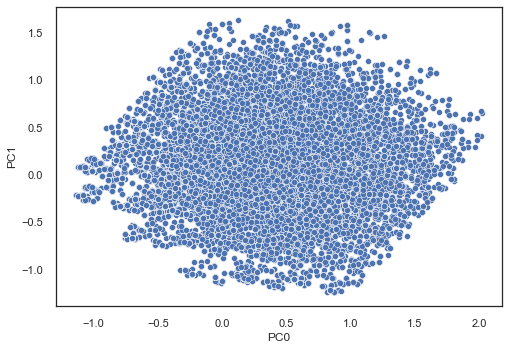

In [301]:
sns.set_style("white")
sns.scatterplot(data=df_with_interests, x="PC0", y="PC1")

## 4.2.2. K-means

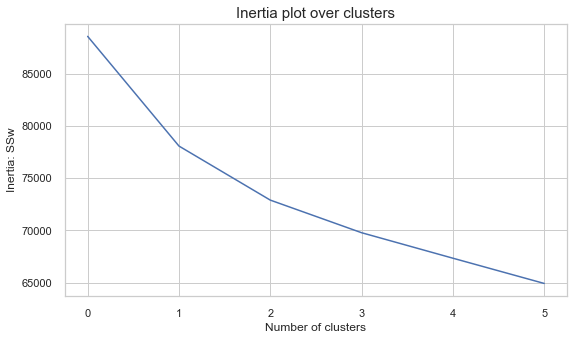

In [302]:
range_clusters = range(1, 7)

inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_with_interests[Interests])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution
sns.set_style("whitegrid")
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [265]:
# kmeans with n_clusters = 3
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df_with_interests[Interests])
# the predict method
KM_labels = kmclust.predict(df_with_interests[Interests])

df_concat_km = pd.concat([df_with_interests[Interests], pd.Series(KM_labels, index=df_with_interests.index, name="labels_interests")], axis=1)

In [266]:
R2(df_with_interests[Interests], df_concat_km, 'labels_interests')

Cluster solution with R^2 of 0.1769


<AxesSubplot:xlabel='PC0', ylabel='PC1'>

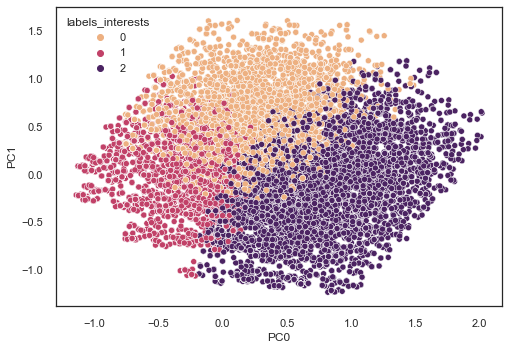

In [268]:
df_for_plot = pd.concat([df_concat_km, df_with_interests[components_interests]], axis = 1)
sns.set_style("white")
sns.scatterplot(data=df_for_plot, x="PC0", y="PC1", hue='labels_interests', palette= 'flare')

## 4.2.3. Interpretation

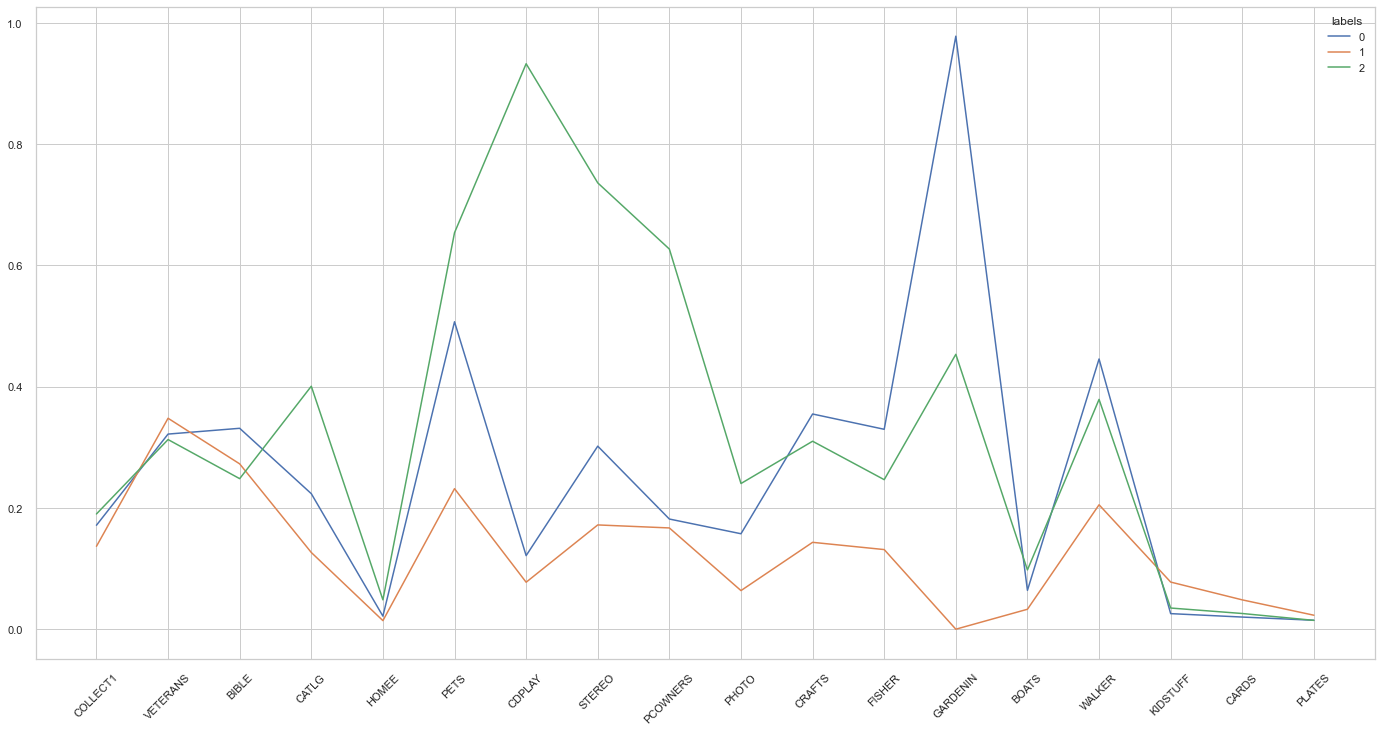

In [271]:
meanplot_df(df_with_interests[Interests], df_concat_km['labels_interests'])

<AxesSubplot:xlabel='labels_interests', ylabel='count'>

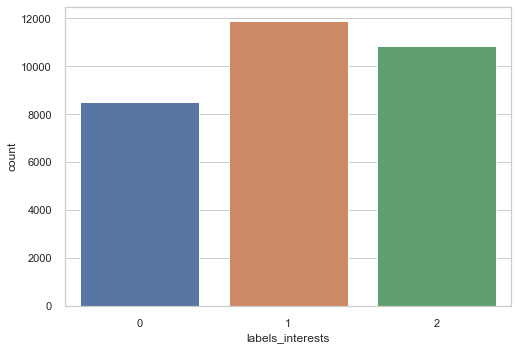

In [272]:
sns.countplot(x = df_concat_km['labels_interests'])

Interests-Clusters interpretation

- <font color='blue'>**Cluster 0: The "Green Thumb" Donor**</font>
 - Gardenin
 - Crafts
 - Fisher
 - Walker
 - Definition : The Green Thumb Donor is a nature lover: his interests are crafts, fishes and walk outside. But his true hobby is mainly one: gardenin.
 
 
- <font color='orange'>**Cluster 1: The "Indifferent" donor**</font>
 - Definition : There is not a particular interest that really affects the Indifferent Donor. Data shows that he is a bit interest in all of the the topics, but nothing in particular 
 
- <font color='green'>**Cluster 2: The "Informatic" Donor**</font> 
 - CDPLAY
 - STEREO
 - PCOWNERS
 - PHOTO
 - PETS
 - Definition : the Informatic Donor is the man of the 21 century. He is an expert of music and technologies, such as pc, stereo and cd-players

In [273]:
# concat the results in 1 dataset
df_with_interests = pd.concat([df_with_interests.drop(columns=components_interests), df_concat_km['labels_interests']], axis = 1)
# defining label = 3 for people withot interests assigned
df_no_interests['labels_interests'] = 3
# concat donors with interests and donors without interests
df_interests = pd.concat([df_no_interests, df_with_interests])

<ipython-input-273-9c841487f4e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_interests['labels_interests'] = 3


In [274]:
labels_interests = df_interests['labels_interests']

# 4.3 Mail response features  <a class="anchor" id="4.3"></a>

The following variables indicate the number of known times the donor has responded to other types of mail order offers.
- MBCRAFT                   -   Buy Craft Hobby
- MBGARDEN                 -   Buy Gardening
- MBBOOKS                   -   Buy Books
- MBCOLECT                 -   Buy Collectables
- MAGFAML                   -   Buy General Family Mags
- MAGFEM                     -   Buy Female Mags
- MAGMALE                   -   Buy Sports Mags
- PUBGARDN                 -   Gardening Pubs
- PUBCULIN                 -   Culinary Pubs
- PUBHLTH                  -   Health Pubs
- PUBDOITY                 -   Do It Yourself Pubs
- PUBNEWFN                 -   News / Finance Pubs
- PUBPHOTO                 -   Photography Pubs
- PUBOPP                   -   Opportunity Seekers Pubs

From the above information about the features, it would be interesting to investigate about the association rules regarding to the offers by mail. The result of this analysis can be useful when designing the marketing campaign


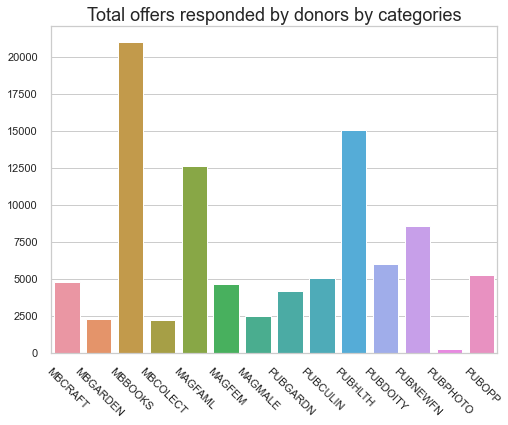

In [275]:
totalOffered = (np.sum((df[mail_feats].dropna() > 0),axis = 0))

fig, ax = plt.subplots(figsize = (8,6))
g = sns.barplot(x = totalOffered.index, y = totalOffered.values)
plt.xticks(rotation=-45)
plt.title('Total offers responded by donors by categories',fontsize = 18)
plt.show()

In [276]:
df[mail_feats].dropna()

MBCRAFT  MBGARDEN  MBBOOKS  MBCOLECT  MAGFAML  MAGFEM  MAGMALE  \
CONTROLN                                                                   
148535        0.0       0.0      3.0       1.0      1.0     1.0      0.0   
15078         0.0       0.0      1.0       0.0      0.0     0.0      0.0   
172556        0.0       0.0      0.0       0.0      0.0     0.0      0.0   
7112          1.0       0.0      9.0       0.0      4.0     1.0      0.0   
109359        0.0       0.0      0.0       0.0      0.0     0.0      0.0   
...           ...       ...      ...       ...      ...     ...      ...   
38061         0.0       0.0      0.0       0.0      0.0     0.0      0.0   
109741        0.0       0.0      0.0       0.0      0.0     0.0      0.0   
35088         0.0       0.0      1.0       0.0      0.0     0.0      0.0   
122706        0.0       0.0      1.0       0.0      0.0     0.0      0.0   
185114        0.0       0.0      0.0       0.0      1.0     0.0      0.0   

          PUBGARDN  PUBCULIN  PUBHLTH  PUBDOITY  PUBNEWFN  PUBPHOTO  PUBOPP  
CONTROLN                                                                     
148535         0.0       0.0      2.0       0.0       3.0       0.0     0.0  
15078          0.0       0.0      1.0       0.0       0.0       0.0     0.0  
172556         0.0       0.0      0.0       0.0       0.0       0.0     1.0  
7112           0.0       0.0      4.0       0.0       1.0       0.0     1.0  
109359         0.0       0.0      0.0       0.0       0.0       0.0     0.0  
...            ...       ...      ...       ...       ...       ...     ...  
38061          0.0       0.0      0.0       0.0       0.0       0.0     0.0  
109741         0.0       0.0      0.0       0.0       0.0       0.0     0.0  
35088          0.0       1.0      0.0       0.0       0.0       0.0     2.0  
122706         0.0       0.0      0.0       0.0       0.0       0.0     0.0  
185114         0.0       0.0      0.0       0.0       0.0       0.0     1.0  

[42010 rows x 14 columns]

## 4.3.1. Association rules:

Firstly, we will drop the null values and convert the data into binary for the process of computing association rules' measures

In [277]:
# Drop null values
df_mailfeats = df[mail_feats].dropna()
df_mailfeats

MBCRAFT  MBGARDEN  MBBOOKS  MBCOLECT  MAGFAML  MAGFEM  MAGMALE  \
CONTROLN                                                                   
148535        0.0       0.0      3.0       1.0      1.0     1.0      0.0   
15078         0.0       0.0      1.0       0.0      0.0     0.0      0.0   
172556        0.0       0.0      0.0       0.0      0.0     0.0      0.0   
7112          1.0       0.0      9.0       0.0      4.0     1.0      0.0   
109359        0.0       0.0      0.0       0.0      0.0     0.0      0.0   
...           ...       ...      ...       ...      ...     ...      ...   
38061         0.0       0.0      0.0       0.0      0.0     0.0      0.0   
109741        0.0       0.0      0.0       0.0      0.0     0.0      0.0   
35088         0.0       0.0      1.0       0.0      0.0     0.0      0.0   
122706        0.0       0.0      1.0       0.0      0.0     0.0      0.0   
185114        0.0       0.0      0.0       0.0      1.0     0.0      0.0   

          PUBGARDN  PUBCULIN  PUBHLTH  PUBDOITY  PUBNEWFN  PUBPHOTO  PUBOPP  
CONTROLN                                                                     
148535         0.0       0.0      2.0       0.0       3.0       0.0     0.0  
15078          0.0       0.0      1.0       0.0       0.0       0.0     0.0  
172556         0.0       0.0      0.0       0.0       0.0       0.0     1.0  
7112           0.0       0.0      4.0       0.0       1.0       0.0     1.0  
109359         0.0       0.0      0.0       0.0       0.0       0.0     0.0  
...            ...       ...      ...       ...       ...       ...     ...  
38061          0.0       0.0      0.0       0.0       0.0       0.0     0.0  
109741         0.0       0.0      0.0       0.0       0.0       0.0     0.0  
35088          0.0       1.0      0.0       0.0       0.0       0.0     2.0  
122706         0.0       0.0      0.0       0.0       0.0       0.0     0.0  
185114         0.0       0.0      0.0       0.0       0.0       0.0     1.0  

[42010 rows x 14 columns]

In [278]:
# https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c
from mlxtend.frequent_patterns import apriori, association_rules
# delete the donors that do not response to any offer
df_offer_responded = df_mailfeats.loc[np.sum((df[mail_feats].dropna() > 0),axis = 1) != 0,:] > 0

freq_items = apriori(df_offer_responded, min_support=0.2, use_colnames=True, verbose=1)
freq_items.sort_values(by = ['support'],ascending=False)
#fig, ax = plt.subplots(figsize = (10,6))
#g = sns.barplot(x = 'itemsets', y = 'support', data=freq_items.sort_values(by = ['support'],ascending=False),ax=ax)
#plt.xticks(rotation=-45)
#plt.show()

Processing 9 combinations | Sampling itemset size 3


support             itemsets
0  0.694035            (MBBOOKS)
2  0.496495            (PUBHLTH)
1  0.417168            (MAGFAML)
5  0.402652   (PUBHLTH, MBBOOKS)
4  0.292573   (MAGFAML, MBBOOKS)
3  0.282488           (PUBNEWFN)
6  0.221017  (PUBNEWFN, MBBOOKS)

Donors responded the most to offer for Books (hold 69% of the donors who responded to at least one offers), following by Health publications (49%) and General Family Magazines (40%). 

In [279]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.5)
rules

antecedents consequents  antecedent support  consequent support   support  \
0   (MAGFAML)   (MBBOOKS)            0.417168            0.694035  0.292573   
1   (PUBHLTH)   (MBBOOKS)            0.496495            0.694035  0.402652   
2   (MBBOOKS)   (PUBHLTH)            0.694035            0.496495  0.402652   
3  (PUBNEWFN)   (MBBOOKS)            0.282488            0.694035  0.221017   

   confidence      lift  leverage  conviction  
0    0.701332  1.010514  0.003044    1.024431  
1    0.810989  1.168513  0.058067    1.618769  
2    0.580161  1.168513  0.058067    1.199281  
3    0.782395  1.127314  0.024961    1.406057

Rule of `PUBHLTH` offers -> `MBBOOKS` offers have the highest confidence of being responded by the same donor

## 4.3.2. Clustering:

We will analyse the characteristics of donors that responsed to mail offers on the features that do not having too many null values: `INCOME`, `HOMEOWNR`, ` GENDER`, `WEALTH1` and `HIT`

In [440]:
#df_m_ch = df_mailfeats.merge(df.loc[df_mailfeats.index, ['INCOME', 'HOMEOWNR', 'GENDER', 'WEALTH1', 'HIT', 'AGE']],left_index=True, right_index=True)
df_mail = df_mailfeats

In [441]:
df_mail['TOTAL_RESPONSES'] = np.sum(df_mail.loc[df_mail.index,:],axis = 1)
#df_mail = df_mail.applymap(lambda x: 0 if x <3 else (1 if x <10 else 2))

There are number of missing values remained, we will exclude them out now and do the clustering on the available data

In [442]:
# Save the index of missing values for later imputing
NA_offers_char = df_mail.isna().index
# Drop rows having missing values:
df_mail = df_mail.dropna(axis = 0)
#
categorical = df_mail.loc[:,df_mail.dtypes == 'O'].columns
numeric = df_mail.loc[:,df_mail.dtypes != 'O'].columns

In [443]:
# Scale the data with standard scaler
df_mail = pd.DataFrame(MinMaxScaler().fit_transform(df_mail[numeric]),index = df_mail[numeric].index, columns=numeric)

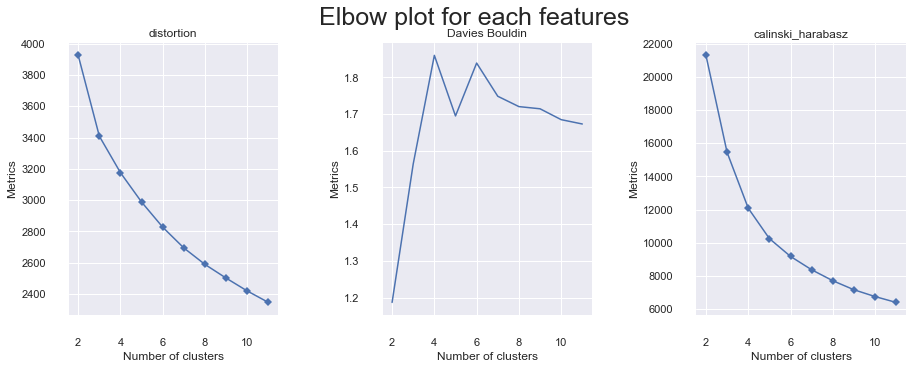

In [304]:
# plot the elbow plot
clusters_score(df_mail,range_clusters=(2, 12))

## 4.3.2.1 Hierachical:

In [305]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit(df_mail)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

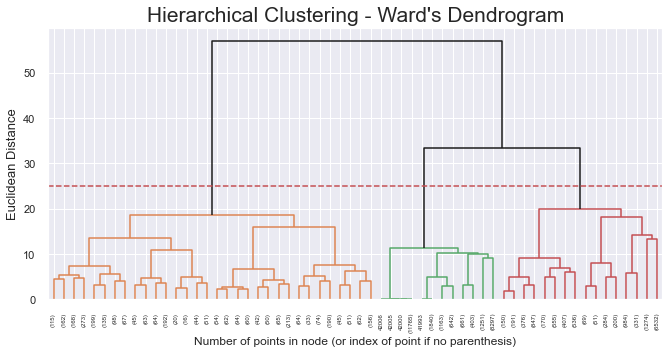

In [307]:
linkage='ward'
distance='euclidean'
dendogram_hclust(hclust,threshold=25)

In [310]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3 )
hclust.fit(df_mail)

AgglomerativeClustering(n_clusters=3)

In [311]:
r2(df_mail, hclust.labels_)

0.36930878345008045

<AxesSubplot:ylabel='count'>

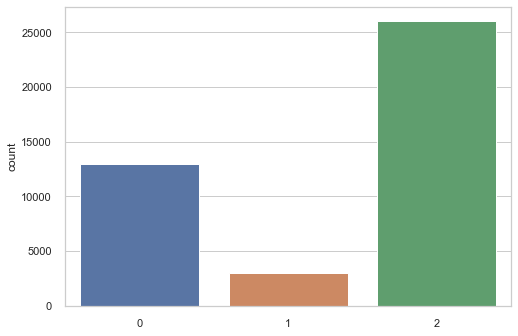

In [312]:
sns.set_style("whitegrid")
sns.countplot(x = hclust.labels_)

In [313]:
pca_combined = PCA_combined(df_mail)
pca_combined.PCA_test(n_components = 3)
pca_combined.corr_PCA().style.applymap(_color_red_or_green)

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

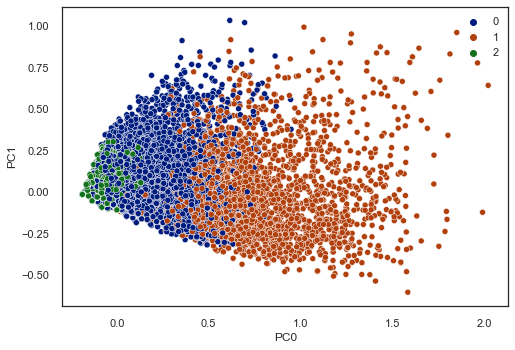

In [314]:
sns.set_style("white")
sns.scatterplot(x='PC0',
                y='PC1',
                data= pca_combined.pca_df_,
                palette="dark",
                hue = hclust.labels_)

## 4.3.2.2 Gaussian Mixture Model:

In [322]:
from sklearn.mixture import GaussianMixture
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_mail)

In [323]:
r2(df_mail, gmm_labels)

0.24118533171660983

<AxesSubplot:ylabel='count'>

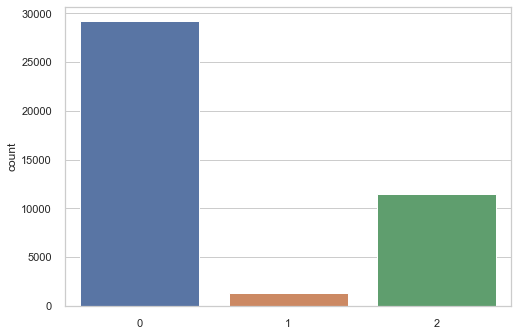

In [324]:
sns.set_style("whitegrid")
sns.countplot(x = gmm_labels)

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

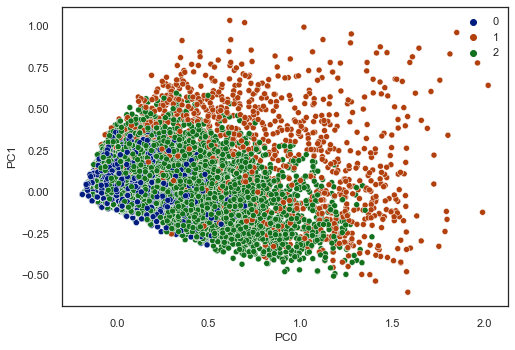

In [325]:
sns.set_style("white")
sns.scatterplot(x='PC0',
                y='PC1',
                data= pca_combined.pca_df_,
                palette="dark",
                hue = gmm_labels)

## 4.3.2.3 K-Means clustering:

In [444]:
kmeans_model_final = KMeans(n_clusters=3, n_init=15, max_iter=300, tol=0.00001, random_state=2)
kmeans_model_final.fit(df_mail)

KMeans(n_clusters=3, n_init=15, random_state=2, tol=1e-05)

In [445]:
r2(df_mail, kmeans_model_final.labels_)

0.4238023700407366

In [446]:
df_mail_final = pd.concat([df_mail, 
                           pd.Series(kmeans_model_final.labels_,index = df_mail.index, name = 'labels_mail')],axis =1 )

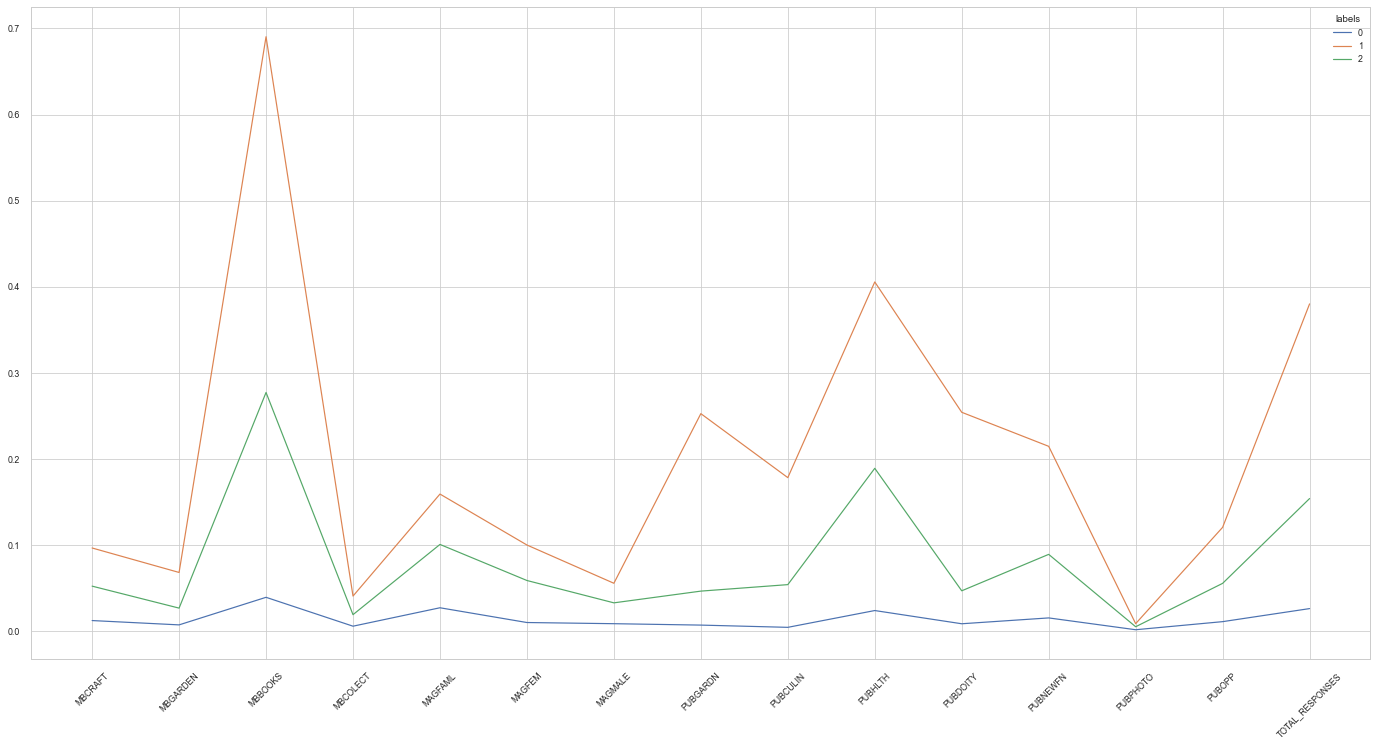

In [447]:
meanplot_df(df_mail, kmeans_model_final.labels_ )

<AxesSubplot:ylabel='count'>

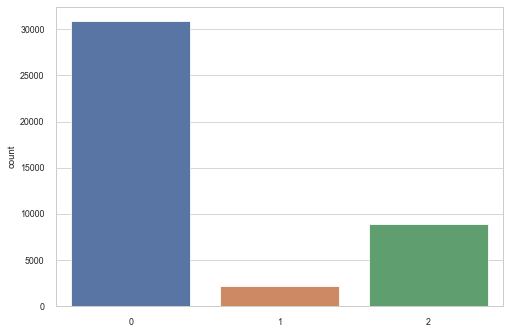

In [448]:
sns.countplot(x = kmeans_model_final.labels_)

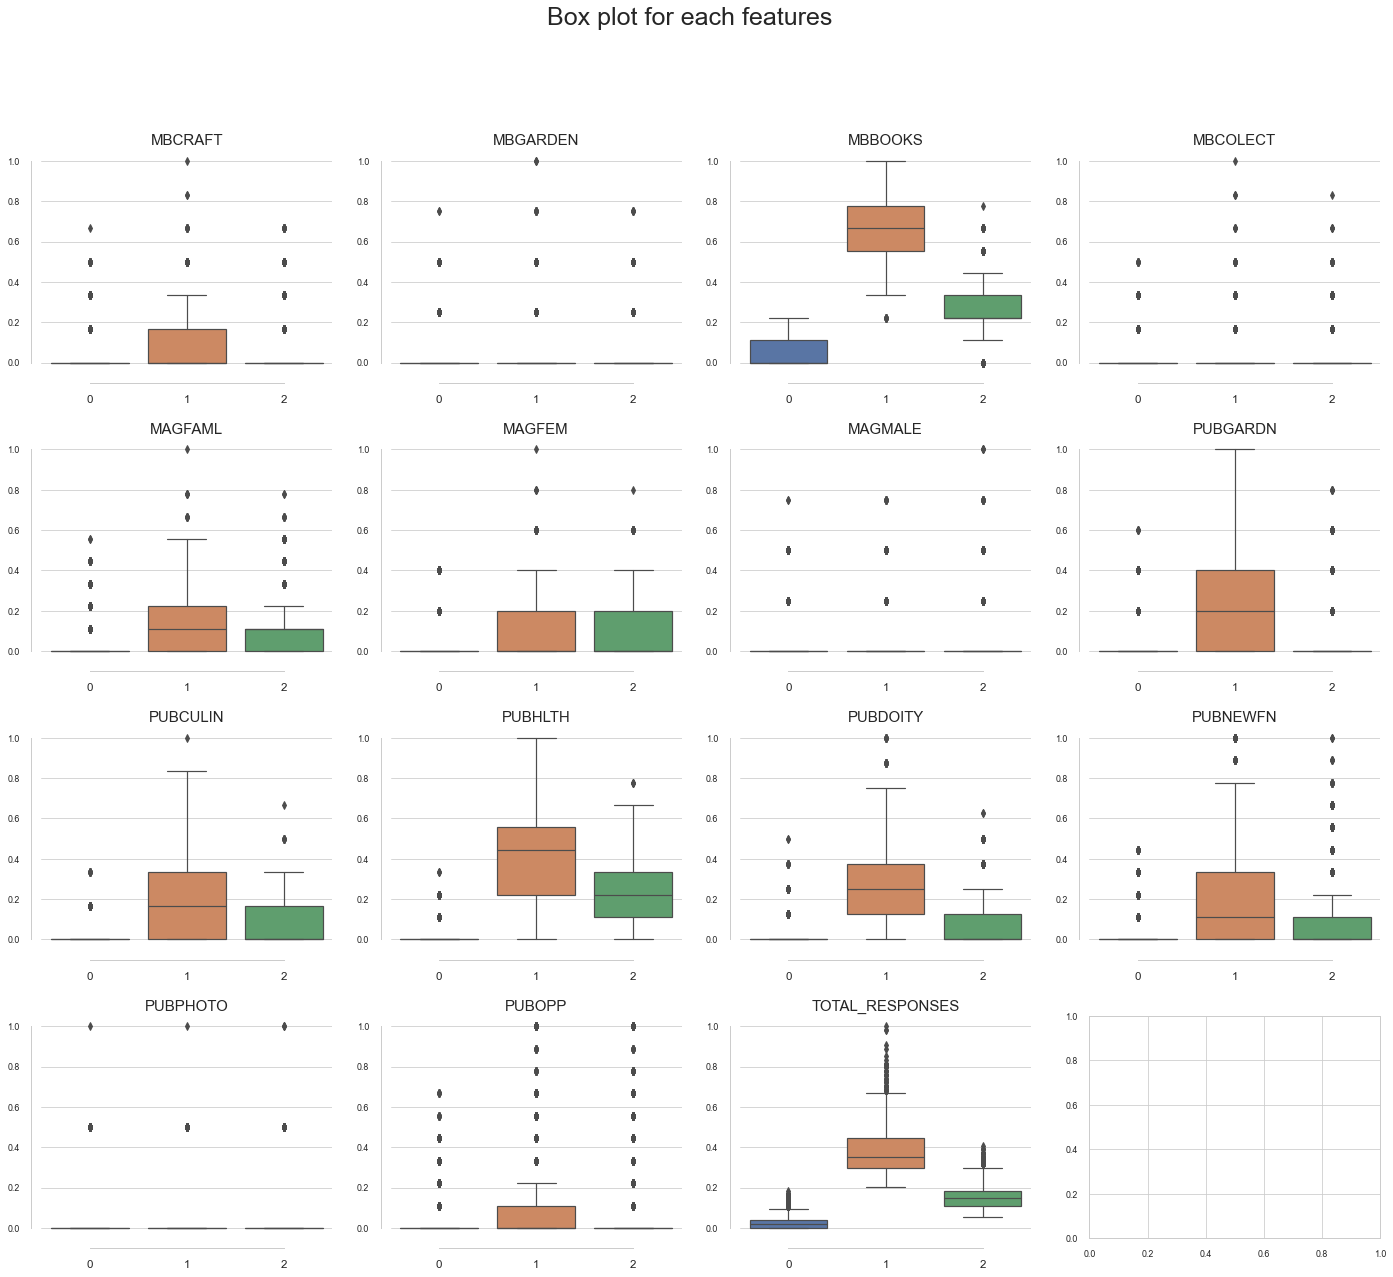

In [449]:
boxplot_withLabels(df_mail, kmeans_model_final.labels_)

### Visualize the result with PC planes

In [450]:
pca_combined = PCA_combined(df_mail)
pca_combined.PCA_test(n_components = 4)
pca_combined.corr_PCA().style.applymap(_color_red_or_green)

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

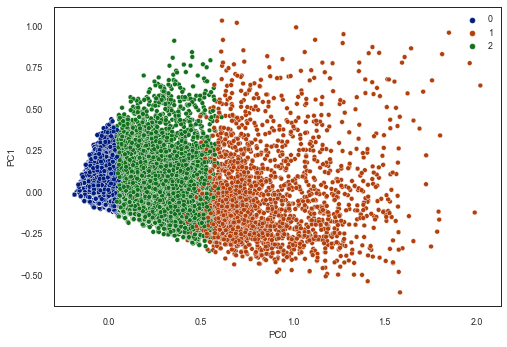

In [451]:
sns.set_style("white")
sns.scatterplot(x='PC0',
                y='PC1',
                data= pca_combined.pca_df_,
                palette="dark",
                hue = kmeans_model_final.labels_)

In [452]:
labels_mail = pd.Series(kmeans_model_final.labels_, index=df_mail.index, name = 'labels_mail')

# 4.4. Neighborhood   <a class="anchor" id="4.4"></a>

For the analysis of the Neighborhood variables, we are going to use the PCA, due to the high-dimension of the subset of data. Indeed, we ended up the phase of preprocessing with 26 varaibles for the neighborhood

In [352]:
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df[neighbor_feats])
scaled_feat
#print("Parameters fitted:\n", scaler.data_min_, "\n", scaler.data_max_)
df[neighbor_feats] = scaled_feat

In [353]:
# check_point = df.copy()
df_neighbor = df[neighbor_feats].copy()

In [354]:
# deleting the variable IC2, high-correlated with IC5
neighborhood = ['POP901', 'POP90C1', 'POP90C4', 'ETH1', 'ETH2', 'ETH3', 'ETH4', 'ETH5',
       'ETH6', 'AGE901', 'MARR1', 'MARR2', 'MARR3', 'MARR4', 'HHP2', 'HV1',
       'HV3', 'HU3', 'IC5', 'TPE10', 'LFC1', 'OCC1', 'AFC1', 'AFC4',
       'POBC1']


df_neighbor[neighborhood].head(3)

POP901  POP90C1   POP90C4      ETH1      ETH2  ETH3      ETH4  \
CONTROLN                                                                    
95515     0.010041      0.0  0.474747  0.929293  0.010101   0.0  0.000000   
148535    0.036575      1.0  0.505051  0.676768  0.000000   0.0  0.313131   
15078     0.070922      0.0  0.494949  0.969697  0.020202   0.0  0.000000   

              ETH5      ETH6    AGE901  ...       HV1       HV3       HU3  \
CONTROLN                                ...                                 
95515     0.111111  0.000000  0.407895  ...  0.079833  0.230769  0.969072   
148535    0.060606  0.181818  0.342105  ...  0.911333  0.923077  0.979381   
15078     0.020202  0.000000  0.355263  ...  0.082833  0.153846  0.938144   

               IC5     TPE10      LFC1      OCC1  AFC1      AFC4     POBC1  
CONTROLN                                                                    
95515     0.073818  0.155556  0.565657  0.090909   0.0  0.181818  0.030303  
148535    0.207279  0.266667  0.707071  0.222222   0.0  0.080808  0.424242  
15078     0.066329  0.211111  0.656566  0.101010   0.0  0.101010  0.020202  

[3 rows x 25 columns]

## 4.4.1. PCA of Neighborhood variables

For a better interpretation of the cluster's result, we also create components of variables that express the same aspect of the neighborhood

In [355]:
selected_features_list[selected_features_list['Category'] == 'Neighborhood']

FeaturesName                                     Description      Category  \
46       POP901                               Number of Persons  Neighborhood   
47      POP90C1            Percent Population in Urbanized Area  Neighborhood   
48      POP90C4                                    Percent Male  Neighborhood   
49         ETH1                                   Percent White  Neighborhood   
50         ETH2                                   Percent Black  Neighborhood   
51         ETH3                         Percent Native American  Neighborhood   
52         ETH4                  Percent Pacific Islander/Asian  Neighborhood   
53         ETH5                                Percent Hispanic  Neighborhood   
54         ETH6                            Percent Asian Indian  Neighborhood   
55       AGE901                        Median Age of Population  Neighborhood   
56        MARR1                                 Percent Married  Neighborhood   
57        MARR2                   Percent Separated or Divorced  Neighborhood   
58        MARR3                                 Percent Widowed  Neighborhood   
59        MARR4                           Percent Never Married  Neighborhood   
60         HHP2                    Average Person Per Household  Neighborhood   
61          HV1                   Median Home Value in hundreds  Neighborhood   
62          HV3                Median Contract Rent in hundreds  Neighborhood   
63          HU3                  Percent Occupied Housing Units  Neighborhood   
64          IC2                Median Family Income in hundreds  Neighborhood   
65          IC5                               Per Capita Income  Neighborhood   
66        TPE10           Median Travel Time to Work in minutes  Neighborhood   
67         LFC1                   Percent Adults in Labor Force  Neighborhood   
68         OCC1                            Percent Professional  Neighborhood   
69          EC1  Median Years of School Completed by Adults 25+  Neighborhood   
70         AFC1       Percent Adults in Active Military Service  Neighborhood   
71         AFC4                  Percent Adult Veterans Age 16+  Neighborhood   
72        POBC1                            Percent Foreign Born  Neighborhood   

   Selected  
46        x  
47        x  
48        x  
49        x  
50        x  
51        x  
52        x  
53        x  
54        x  
55        x  
56        x  
57        x  
58        x  
59        x  
60        x  
61        x  
62        x  
63        x  
64        x  
65        x  
66        x  
67        x  
68        x  
69        x  
70        x  
71        x  
72        x

In [356]:
# defining groups of variables for the neighborhood variables

popularity = ['POP901', 'POP90C1', 'HHP2', 'LFC1', 'TPE10']

origin = ['ETH1', 'ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'POBC1']

status = ['MARR1', 'MARR2', 'MARR3', 'MARR4']

quality = ['HV1', 'HV3', 'IC5', 'OCC1', 'HU3']

veterans = ['AFC1', 'AFC4']

# check_point = df.copy()
df_neighbor = df[neighbor_feats].copy()
#  Considering also AGE901

#### Popularity features

In [357]:
pca = PCA()
pca_feat = pca.fit_transform(df_neighbor[popularity])
pca_feat 

# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    0.229395    0.000000    0.890201    0.890201
2    0.015850   -0.213545    0.061510    0.951711
3    0.005699   -0.010151    0.022116    0.973827
4    0.003403   -0.002296    0.013207    0.987034
5    0.003341   -0.000062    0.012966    1.000000

In [358]:
pca = PCA(n_components=1)
pca_feat = pca.fit_transform(df_neighbor[popularity])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_neighbor.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

# df.drop(df.loc[:,metric_features], axis=1, inplace=True)
df_pca = pd.concat([df_neighbor, pca_df], axis=1)
df_neighbor = df_pca.copy()
df_neighbor = df_neighbor.rename(columns={'PC0':'neigh_popularity'})
# df_neighbor.head()

In [359]:
# # Interpreting each Principal Component
loadings = df_neighbor[popularity + ['neigh_popularity']].corr().loc[popularity, ['neigh_popularity']]
loadings.style.applymap(_color_red_or_green)

#### Origin features

In [360]:
pca = PCA()
pca_feat = pca.fit_transform(df_neighbor[origin])
pca_feat 

# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    0.063976    0.000000    0.614138    0.614138
2    0.026838   -0.037138    0.257630    0.871767
3    0.007674   -0.019164    0.073667    0.945434
4    0.003150   -0.004525    0.030234    0.975668
5    0.001480   -0.001670    0.014203    0.989871
6    0.000800   -0.000680    0.007677    0.997548
7    0.000255   -0.000544    0.002452    1.000000

In [361]:
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(df_neighbor[origin])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_neighbor.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

# df.drop(df.loc[:,metric_features], axis=1, inplace=True)
df_pca = pd.concat([df_neighbor, pca_df], axis=1)
df_neighbor = df_pca.copy()
df_neighbor = df_neighbor.rename(columns={'PC0':'neigh_origin_1', 'PC1':'neigh_origin_2'})
# df_neighbor.head()

In [362]:
# # Interpreting each Principal Component
# # Interpreting each Principal Component
loadings = df_neighbor[origin + ['neigh_origin_1', 'neigh_origin_2']].corr().loc[origin, ['neigh_origin_1', 'neigh_origin_2']]
loadings.style.applymap(_color_red_or_green)

#### Status features

In [363]:
pca = PCA()
pca_feat = pca.fit_transform(df_neighbor[status])
pca_feat 

# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    0.021092    0.000000    0.744357    0.744357
2    0.005681   -0.015411    0.200471    0.944827
3    0.001554   -0.004127    0.054832    0.999659
4    0.000010   -0.001544    0.000341    1.000000

In [364]:
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(df_neighbor[status])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_neighbor.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

# df.drop(df.loc[:,metric_features], axis=1, inplace=True)
df_pca = pd.concat([df_neighbor, pca_df], axis=1)
df_neighbor = df_pca.copy()
df_neighbor = df_neighbor.rename(columns={'PC0':'neigh_status_1', 'PC1':'neigh_status_2'})
# df_neighbor.head()

In [365]:
# # Interpreting each Principal Component
# # Interpreting each Principal Component
loadings = df_neighbor[status + ['neigh_status_1', 'neigh_status_2']].corr().loc[status, ['neigh_status_1', 'neigh_status_2']]
loadings.style.applymap(_color_red_or_green)

#### Quality features

In [366]:
pca = PCA()
pca_feat = pca.fit_transform(df_neighbor[quality])
pca_feat 

# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    0.051664    0.000000    0.688682    0.688682
2    0.010303   -0.041361    0.137334    0.826015
3    0.007036   -0.003266    0.093791    0.919807
4    0.005187   -0.001849    0.069145    0.988952
5    0.000829   -0.004358    0.011048    1.000000

In [367]:
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(df_neighbor[quality])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_neighbor.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

# df.drop(df.loc[:,metric_features], axis=1, inplace=True)
df_pca = pd.concat([df_neighbor, pca_df], axis=1)
df_neighbor = df_pca.copy()
df_neighbor = df_neighbor.rename(columns={'PC0':'neigh_quality_1', 'PC1':'neigh_quality_2'})
# df_neighbor.head()

In [368]:
# # Interpreting each Principal Component
# # Interpreting each Principal Component
loadings = df_neighbor[quality + ['neigh_quality_1', 'neigh_quality_2']].corr().loc[quality,  ['neigh_quality_1', 'neigh_quality_2']]
loadings.style.applymap(_color_red_or_green)

#### Veterans features

In [369]:
pca = PCA()
pca_feat = pca.fit_transform(df_neighbor[veterans])
pca_feat 

# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    0.002643    0.000000    0.710824    0.710824
2    0.001075   -0.001568    0.289176    1.000000

In [370]:
pca = PCA(n_components=1)
pca_feat = pca.fit_transform(df_neighbor[veterans])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_neighbor.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

# df.drop(df.loc[:,metric_features], axis=1, inplace=True)
df_pca = pd.concat([df_neighbor, pca_df], axis=1)
df_neighbor = df_pca.copy()
df_neighbor = df_neighbor.rename(columns={'PC0':'neigh_veterans_1'})
# df_neighbor.head()

In [371]:
loadings = df_neighbor[veterans + ['neigh_veterans_1']].corr().loc[veterans, ['neigh_veterans_1']]
loadings.style.applymap(_color_red_or_green)

### Interpreting each Principal Component

- 'neigh_popularity' :  negative correlated with percent population in urbanized areas
- 'neigh_origin_1' : negative correlation with percent white, positive correlation with percent black
- 'neigh_origin_2' : positive correlation with percent hispanic and percent foreign born
- 'neigh_status_1' : negative correlation with percent married, positive with separated and never married
- 'neigh_status_2' : positive correlation with percent widowed
- 'neigh_quality_1' : positive correlated with all (higher values = good neighborhood)
- 'neigh_quality_2' : negative correlated with percent of houses occupied
- 'neigh_veterans_1' : positive correlated with percent veterans

In [372]:
components_neigh_for_interpretation = ['neigh_popularity', 'neigh_origin_1', 'neigh_origin_2',
       'neigh_status_1', 'neigh_status_2', 'neigh_quality_1',
       'neigh_quality_2', 'neigh_veterans_1', 'AGE901']

Computing now the PCA for the neighborhood variables

In [373]:
pca = PCA()
pca_feat = pca.fit(df_neighbor[neighborhood])
pca_feat

# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1     0.250898    0.000000    0.522253    0.522253
2     0.072552   -0.178346    0.151019    0.673272
3     0.040079   -0.032473    0.083425    0.756697
4     0.027583   -0.012496    0.057415    0.814111
5     0.023708   -0.003875    0.049349    0.863460
6     0.015629   -0.008079    0.032532    0.895992
7     0.008819   -0.006810    0.018357    0.914349
8     0.006154   -0.002664    0.012811    0.927159
9     0.006086   -0.000068    0.012669    0.939829
10    0.005117   -0.000970    0.010651    0.950479
11    0.004034   -0.001083    0.008397    0.958876
12    0.003779   -0.000255    0.007866    0.966742
13    0.003344   -0.000435    0.006961    0.973703
14    0.002693   -0.000651    0.005605    0.979308
15    0.002141   -0.000552    0.004456    0.983764
16    0.001553   -0.000587    0.003233    0.986997
17    0.001440   -0.000113    0.002998    0.989995
18    0.001081   -0.000359    0.002251    0.992246
19    0.001002   -0.000080    0.002086    0.994331
20    0.000758   -0.000244    0.001578    0.995909
21    0.000646   -0.000112    0.001346    0.997255
22    0.000602   -0.000044    0.001253    0.998508
23    0.000459   -0.000143    0.000955    0.999463
24    0.000248   -0.000211    0.000517    0.999980
25    0.000010   -0.000239    0.000020    1.000000

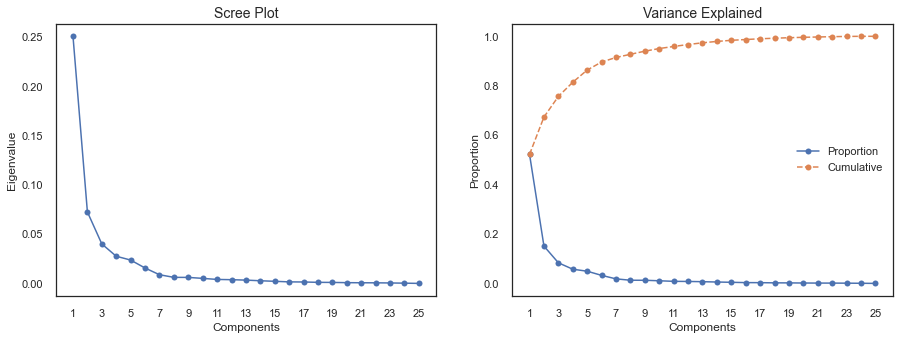

In [374]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [375]:
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(df_neighbor[neighborhood])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_neighbor.index, columns=pca_feat_names)  
pca_df

PC0       PC1       PC2       PC3       PC4
CONTROLN                                                  
95515     0.621939 -0.018289  0.005879  0.013639  0.096349
148535   -0.665703 -0.249661  0.868050  0.197291 -0.049249
15078     0.641568 -0.028553 -0.038909 -0.049566 -0.007152
172556    0.537996  0.225409  0.302041 -0.169388  0.244111
7112     -0.501488  1.123224  0.046247  0.282459 -0.365105
...            ...       ...       ...       ...       ...
184568   -0.422593  0.019046  0.003193 -0.108514 -0.136450
122706   -0.334319 -0.131329 -0.063251 -0.141104 -0.119185
189641   -0.385150  0.145555 -0.171840 -0.134167 -0.009882
4693     -0.526440 -0.254884  0.315347  0.033765 -0.071500
185114   -0.377031 -0.081736 -0.092744 -0.030775 -0.172258

[93760 rows x 5 columns]

In [376]:
df_pca = pd.concat([df_neighbor, pca_df], axis=1)

df_neighbor = df_pca.copy()

components_neighborhood = ['PC0', 'PC1', 'PC2', 'PC3', 'PC4']

In [377]:
df_neighbor

POP901   POP90C1   POP90C4      ETH1      ETH2      ETH3  \
CONTROLN                                                               
95515     0.010041  0.000000  0.474747  0.929293  0.010101  0.000000   
148535    0.036575  1.000000  0.505051  0.676768  0.000000  0.000000   
15078     0.070922  0.000000  0.494949  0.969697  0.020202  0.000000   
172556    0.006474  0.000000  0.545455  0.616162  0.000000  0.000000   
7112      0.025522  1.000000  0.464646  0.020202  0.989899  0.000000   
...            ...       ...       ...       ...       ...       ...   
184568    0.277396  1.000000  0.505051  0.787879  0.101010  0.060606   
122706    0.012695  0.969697  0.515152  0.919192  0.030303  0.000000   
189641    0.005583  1.000000  0.535354  0.828283  0.141414  0.000000   
4693      0.017680  1.000000  0.474747  0.929293  0.010101  0.010101   
185114    0.039858  1.000000  0.484848  0.868687  0.121212  0.000000   

              ETH4      ETH5      ETH6    AGE901  ...  neigh_status_1  \
CONTROLN                                          ...                   
95515     0.000000  0.111111  0.000000  0.407895  ...       -0.042378   
148535    0.313131  0.060606  0.181818  0.342105  ...       -0.102498   
15078     0.000000  0.020202  0.000000  0.355263  ...       -0.059518   
172556    0.111111  0.323232  0.272727  0.315789  ...       -0.043080   
7112      0.000000  0.010101  0.000000  0.328947  ...        0.204787   
...            ...       ...       ...       ...  ...             ...   
184568    0.040404  0.050505  0.000000  0.263158  ...        0.011195   
122706    0.020202  0.060606  0.045455  0.289474  ...       -0.158345   
189641    0.010101  0.090909  0.000000  0.263158  ...        0.167180   
4693      0.050505  0.080808  0.000000  0.342105  ...        0.039129   
185114    0.010101  0.010101  0.000000  0.342105  ...       -0.163201   

          neigh_status_2  neigh_quality_1  neigh_quality_2  neigh_veterans_1  \
CONTROLN                                                                       
95515           0.064774        -0.140039        -0.067389          0.022935   
148535         -0.081777         0.935563         0.074654         -0.078008   
15078           0.028688        -0.196728        -0.030389         -0.057820   
172556         -0.026267        -0.127425        -0.009812         -0.027537   
7112            0.003496        -0.060178        -0.083996         -0.006974   
...                  ...              ...              ...               ...   
184568         -0.050417         0.091529         0.001837          0.046119   
122706         -0.079988         0.016373        -0.023997          0.053218   
189641         -0.035473        -0.103939        -0.068216         -0.067914   
4693           -0.010939         0.528427        -0.072856         -0.027537   
185114         -0.056323         0.051361        -0.036415          0.013215   

               PC0       PC1       PC2       PC3       PC4  
CONTROLN                                                    
95515     0.621939 -0.018289  0.005879  0.013639  0.096349  
148535   -0.665703 -0.249661  0.868050  0.197291 -0.049249  
15078     0.641568 -0.028553 -0.038909 -0.049566 -0.007152  
172556    0.537996  0.225409  0.302041 -0.169388  0.244111  
7112     -0.501488  1.123224  0.046247  0.282459 -0.365105  
...            ...       ...       ...       ...       ...  
184568   -0.422593  0.019046  0.003193 -0.108514 -0.136450  
122706   -0.334319 -0.131329 -0.063251 -0.141104 -0.119185  
189641   -0.385150  0.145555 -0.171840 -0.134167 -0.009882  
4693     -0.526440 -0.254884  0.315347  0.033765 -0.071500  
185114   -0.377031 -0.081736 -0.092744 -0.030775 -0.172258  

[93760 rows x 39 columns]

## 4.4.2. DBSCAN
We used this method only to identify outliers in order to remove them

After that we applied all the others algorithms and check the r2 score to pick the one with best performance

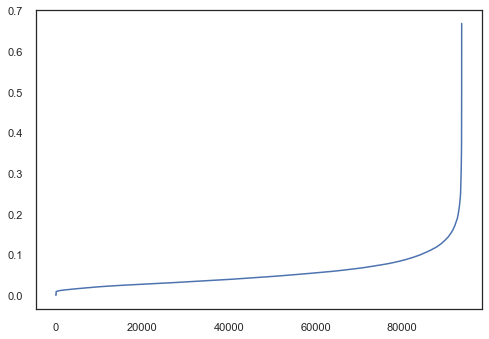

In [378]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_neighbor[components_neighborhood])
distances, _ = neigh.kneighbors(df_neighbor[components_neighborhood])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [379]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.15, min_samples=20, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_neighbor[components_neighborhood])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 4


In [380]:
# Concatenating the labels to df
df_neighbor = pd.concat([df_neighbor, pd.Series(dbscan_labels, index=df_neighbor.index, name="dbscan_labels")], axis=1)
df_neighbor.head()

POP901  POP90C1   POP90C4      ETH1      ETH2  ETH3      ETH4  \
CONTROLN                                                                    
95515     0.010041      0.0  0.474747  0.929293  0.010101   0.0  0.000000   
148535    0.036575      1.0  0.505051  0.676768  0.000000   0.0  0.313131   
15078     0.070922      0.0  0.494949  0.969697  0.020202   0.0  0.000000   
172556    0.006474      0.0  0.545455  0.616162  0.000000   0.0  0.111111   
7112      0.025522      1.0  0.464646  0.020202  0.989899   0.0  0.000000   

              ETH5      ETH6    AGE901  ...  neigh_status_2  neigh_quality_1  \
CONTROLN                                ...                                    
95515     0.111111  0.000000  0.407895  ...        0.064774        -0.140039   
148535    0.060606  0.181818  0.342105  ...       -0.081777         0.935563   
15078     0.020202  0.000000  0.355263  ...        0.028688        -0.196728   
172556    0.323232  0.272727  0.315789  ...       -0.026267        -0.127425   
7112      0.010101  0.000000  0.328947  ...        0.003496        -0.060178   

          neigh_quality_2  neigh_veterans_1       PC0       PC1       PC2  \
CONTROLN                                                                    
95515           -0.067389          0.022935  0.621939 -0.018289  0.005879   
148535           0.074654         -0.078008 -0.665703 -0.249661  0.868050   
15078           -0.030389         -0.057820  0.641568 -0.028553 -0.038909   
172556          -0.009812         -0.027537  0.537996  0.225409  0.302041   
7112            -0.083996         -0.006974 -0.501488  1.123224  0.046247   

               PC3       PC4  dbscan_labels  
CONTROLN                                     
95515     0.013639  0.096349              0  
148535    0.197291 -0.049249              0  
15078    -0.049566 -0.007152              0  
172556   -0.169388  0.244111              0  
7112      0.282459 -0.365105              0  

[5 rows x 40 columns]

C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


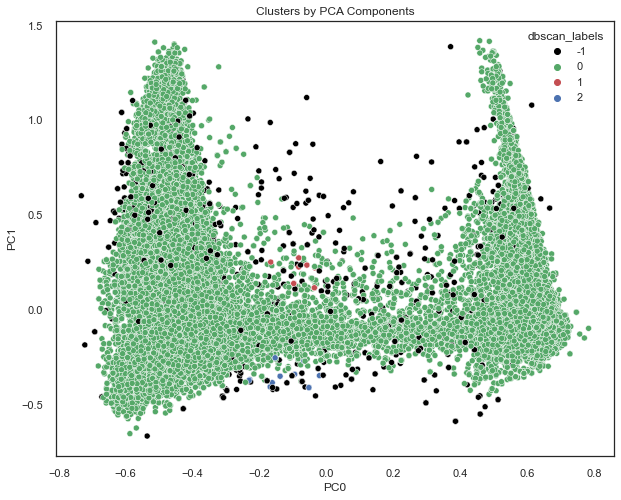

In [381]:
# Detecting noise (potential outliers)
outliers_index = df_neighbor.loc[df_neighbor['dbscan_labels'] == -1].index

#ploting the outliers (black points)
x_axis = df_neighbor['PC0']
y_axis = df_neighbor['PC1']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue = df_neighbor['dbscan_labels'], palette=['black','g','r','b'])
plt.title('Clusters by PCA Components')
plt.show()

In [382]:
#removing the outliers (1.2% of the total data)
# df.drop(outliers_index, inplace = True)
df_neighbor_outlier = df_neighbor.loc[outliers_index,:]
df_neighbor.drop(index=outliers_index,inplace=True)

In [383]:
df_neighbor_outlier

POP901   POP90C1   POP90C4      ETH1      ETH2      ETH3  \
CONTROLN                                                               
143689    0.025714  1.000000  0.474747  0.343434  0.595960  0.000000   
106849    0.008501  1.000000  0.515152  0.717172  0.202020  0.000000   
137726    0.092594  1.000000  0.717172  0.545455  0.373737  0.010101   
116918    0.027082  1.000000  0.878788  0.424242  0.434343  0.000000   
190951    0.054306  1.000000  0.464646  0.424242  0.555556  0.000000   
...            ...       ...       ...       ...       ...       ...   
12779     0.045522  0.000000  0.797980  0.585859  0.202020  0.000000   
151446    0.002898  1.000000  0.454545  0.474747  0.080808  0.020202   
65602     0.003141  1.000000  0.494949  0.303030  0.666667  0.010101   
155629    0.028328  0.252525  0.505051  0.767677  0.040404  0.010101   
147035    0.000030  0.000000  0.505051  1.000000  0.000000  0.000000   

              ETH4      ETH5      ETH6    AGE901  ...  neigh_status_2  \
CONTROLN                                          ...                   
143689    0.050505  0.050505  0.045455  0.447368  ...        0.014073   
106849    0.070707  0.030303  0.136364  0.368421  ...       -0.105827   
137726    0.030303  0.080808  0.000000  0.157895  ...       -0.231171   
116918    0.010101  0.292929  0.045455  0.263158  ...       -0.065020   
190951    0.020202  0.030303  0.045455  0.289474  ...        0.001470   
...            ...       ...       ...       ...  ...             ...   
12779     0.010101  0.343434  0.000000  0.276316  ...       -0.174754   
151446    0.333333  0.343434  0.000000  0.815789  ...        0.327289   
65602     0.020202  0.010101  0.045455  0.394737  ...       -0.058958   
155629    0.131313  0.171717  0.045455  0.263158  ...       -0.050180   
147035    0.000000  0.757576  0.000000  0.407895  ...        0.349520   

          neigh_quality_1  neigh_quality_2  neigh_veterans_1       PC0  \
CONTROLN                                                                 
143689           0.748129         0.086703          0.012841 -0.632932   
106849           0.502798        -0.111092          0.043124 -0.550533   
137726          -0.074939        -0.100300         -0.076842 -0.465988   
116918          -0.192793         0.117445          0.012841 -0.409928   
190951           0.266539        -0.031816         -0.027162 -0.534328   
...                   ...              ...               ...       ...   
12779           -0.181583         0.473637          0.022935  0.560627   
151446           0.286673         0.131114         -0.007348 -0.545251   
65602            0.385402         0.276193         -0.047725 -0.584735   
155629           0.299054         0.072774         -0.057445  0.224628   
147035           0.542323        -0.111933         -0.158763  0.415299   

               PC1       PC2       PC3       PC4  dbscan_labels  
CONTROLN                                                         
143689    0.351323  0.613588  0.518860 -0.281389             -1  
106849   -0.055130  0.352178  0.050096 -0.307644             -1  
137726    0.526782  0.037669 -0.325133 -0.267364             -1  
116918    0.712761 -0.137785  0.193875  0.327208             -1  
190951    0.476965  0.232137  0.129913 -0.306233             -1  
...            ...       ...       ...       ...            ...  
12779     0.534503  0.167012  0.190285  0.490312             -1  
151446    0.259459  0.311438  0.636444  0.754572             -1  
65602     0.594914  0.302031  0.391006 -0.305720             -1  
155629   -0.055195  0.515882 -0.059957 -0.028601             -1  
147035   -0.173025  0.569311  0.342137  0.658325             -1  

[935 rows x 40 columns]

## 4.4.3. SOM

We use SOM to visualize and the understand the behaviour of the variables and the input space distribution for the donors

In [384]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(50)

sm = sompy.SOMFactory().build(
    df_neighbor[components_neighborhood].values, 
    mapsize=(15, 15),
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=components_neighborhood
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.316000, quantization error: 1.437157

 epoch: 2 ---> elapsed time:  0.288000, quantization error: 1.957833

 epoch: 3 ---> elapsed time:  0.291000, quantization error: 1.897321

 epoch: 4 ---> elapsed time:  0.288000, quantization error: 1.882012

 epoch: 5 ---> elapsed time:  0.307000, quantization error: 1.876071

 epoch: 6 ---> elapsed time:  0.312000, quantization error: 1.871749

 epoch: 7 ---> elapsed time:  0.317000, quantization error: 1.868660

 epoch: 8 ---> elapsed time:  0.342000, quantization error: 1.865947

 epoch: 9 ---> elapsed time:  0.345000, quantization error: 1.863334

 epoch: 10 ---> elapsed time:  0.359000, quantization error: 1.860673

 epoch: 11 ---> elapsed time:  0.306000, quantization error: 1.857977

 epoch: 12 ---> elapsed time:  0.305000, quantization error: 1.855234

 epoch: 13 ---> 

 epoch: 14 ---> elapsed time:  0.339000, quantization error: 0.856212

 epoch: 15 ---> elapsed time:  0.351000, quantization error: 0.854387

 epoch: 16 ---> elapsed time:  0.350000, quantization error: 0.852574

 epoch: 17 ---> elapsed time:  0.374000, quantization error: 0.850755

 epoch: 18 ---> elapsed time:  0.339000, quantization error: 0.848960

 epoch: 19 ---> elapsed time:  0.380000, quantization error: 0.847185

 epoch: 20 ---> elapsed time:  0.394000, quantization error: 0.845394

 epoch: 21 ---> elapsed time:  0.384000, quantization error: 0.843627

 epoch: 22 ---> elapsed time:  0.403000, quantization error: 0.841832

 epoch: 23 ---> elapsed time:  0.402000, quantization error: 0.840048

 epoch: 24 ---> elapsed time:  0.397000, quantization error: 0.838266

 epoch: 25 ---> elapsed time:  0.384000, quantization error: 0.836494

 epoch: 26 ---> elapsed time:  0.475000, quantization error: 0.834721

 epoch: 27 ---> elapsed time:  0.397000, quantization error: 0.832953

 epoch

C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\sompy\visualization\plot_tools.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(shape[0], shape[1], comp + 1, aspect='equal')


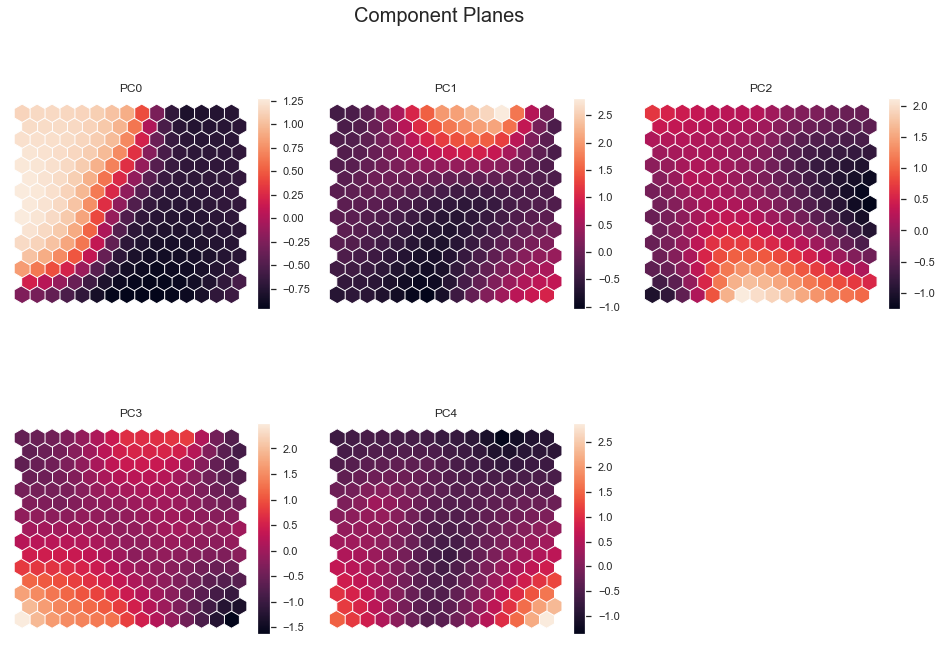

In [385]:
# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

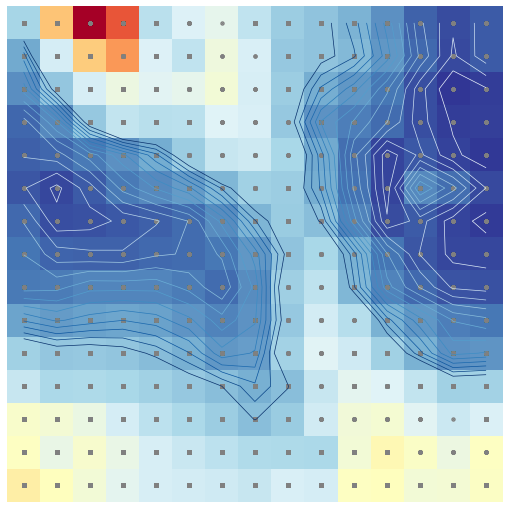

In [399]:
# U-matrix

u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=True, 
    contooor=True, # Visualize isomorphic curves
    blob=False
)

#UMAT[1]  # U-matrix values - no colorscale so we have to rely on the values :(

## 4.4.4. K-means

In [401]:
df_neighbor[components_neighborhood]

PC0       PC1       PC2       PC3       PC4
CONTROLN                                                  
95515     0.621939 -0.018289  0.005879  0.013639  0.096349
148535   -0.665703 -0.249661  0.868050  0.197291 -0.049249
15078     0.641568 -0.028553 -0.038909 -0.049566 -0.007152
172556    0.537996  0.225409  0.302041 -0.169388  0.244111
7112     -0.501488  1.123224  0.046247  0.282459 -0.365105
...            ...       ...       ...       ...       ...
184568   -0.422593  0.019046  0.003193 -0.108514 -0.136450
122706   -0.334319 -0.131329 -0.063251 -0.141104 -0.119185
189641   -0.385150  0.145555 -0.171840 -0.134167 -0.009882
4693     -0.526440 -0.254884  0.315347  0.033765 -0.071500
185114   -0.377031 -0.081736 -0.092744 -0.030775 -0.172258

[92825 rows x 5 columns]

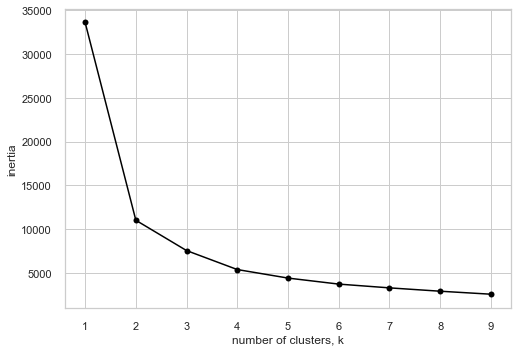

In [403]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_neighbor[components_neighborhood].iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [389]:
# kmeans with n_clusters = 3
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df_neighbor[components_neighborhood])
# the predict method
KM_labels = kmclust.predict(df_neighbor[components_neighborhood])

df_concat_km = pd.concat([df_neighbor, pd.Series(KM_labels, index=df_neighbor.index, name="labels_neighborhood")], axis=1)

In [390]:
r2(df_neighbor[components_neighborhood], kmclust.labels_)

0.6837123550599595

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

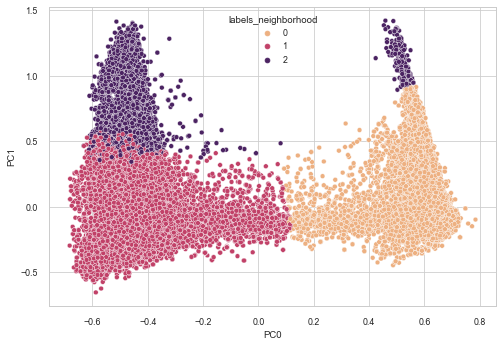

In [409]:
# df_for_plot = pd.concat([df_concat_km, df_neighbor[components_neighborhood]], axis = 1)
sns.set_style("white")
sns.scatterplot(data=df_concat_km, x="PC0", y="PC1", hue='labels_neighborhood', palette= 'flare')

## 4.4.5. Interpretation

<AxesSubplot:xlabel='labels_neighborhood', ylabel='count'>

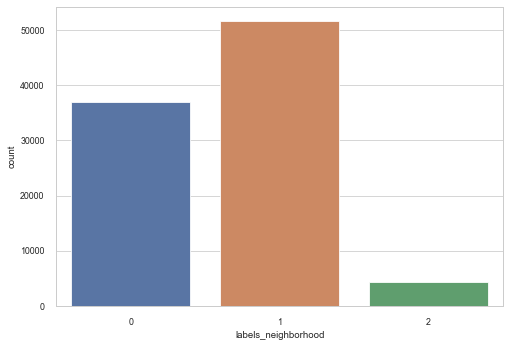

In [410]:
sns.set_style("whitegrid")
sns.countplot(x = df_concat_km['labels_neighborhood'])

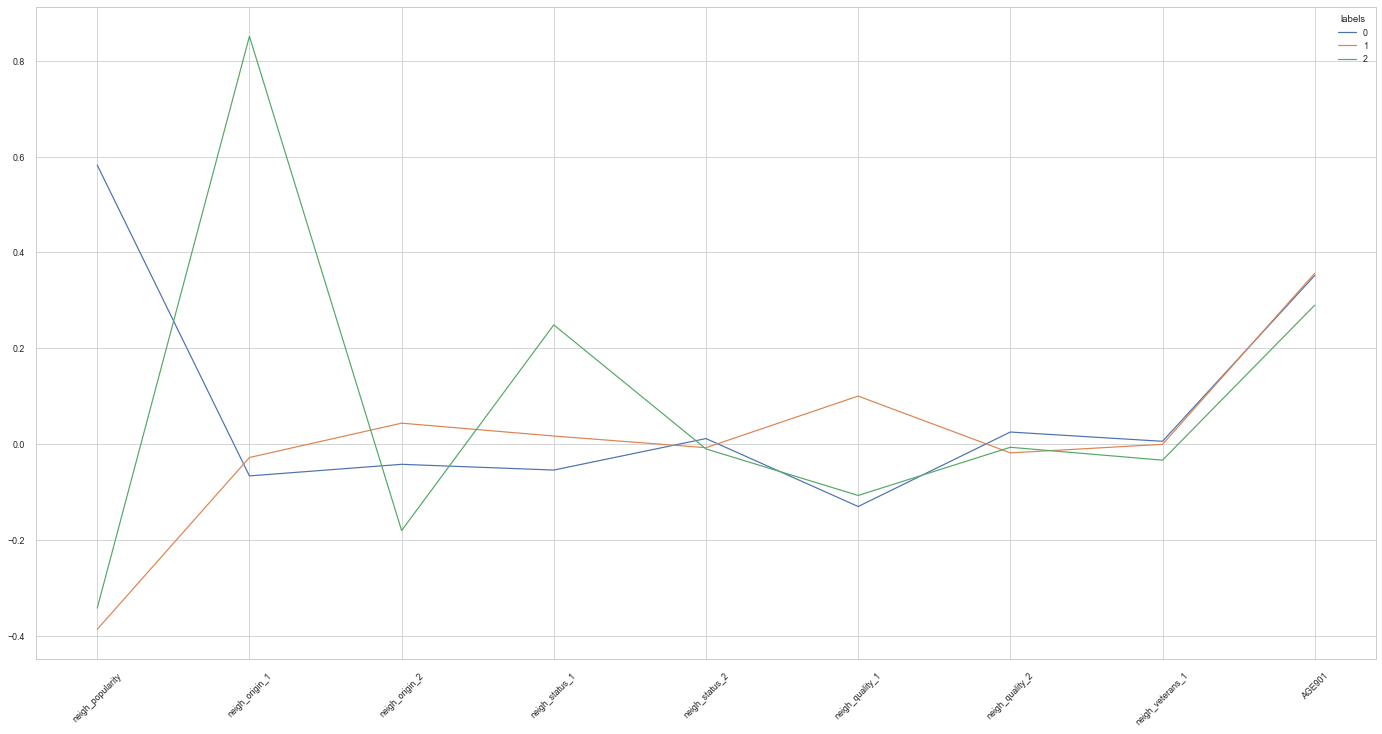

In [457]:
meanplot_df(df_concat_km[components_neigh_for_interpretation], df_concat_km['labels_neighborhood'])

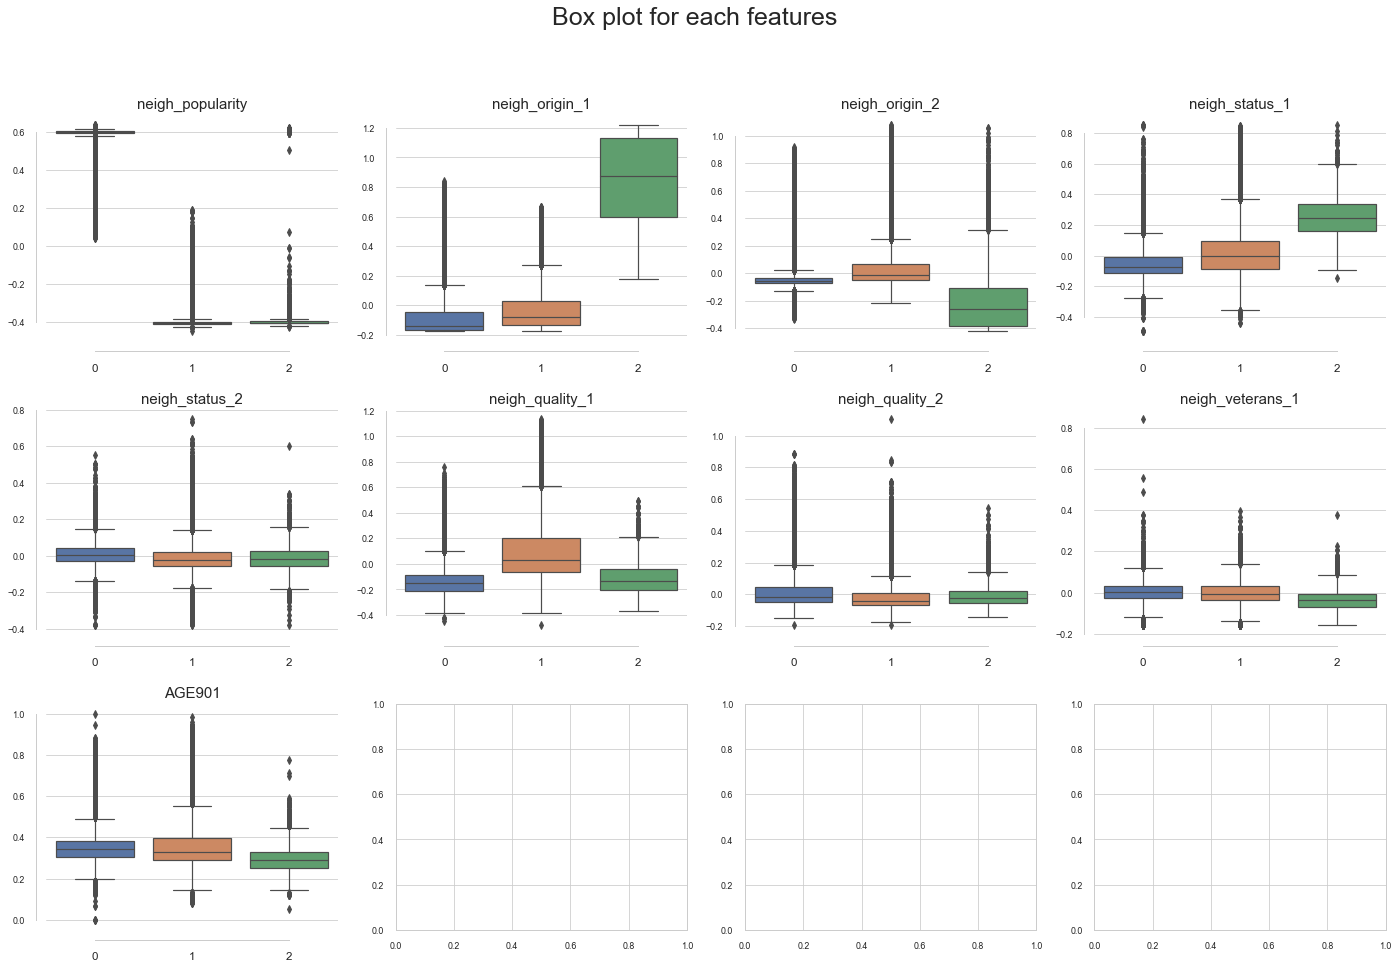

In [412]:
boxplot_withLabels(df_concat_km[components_neigh_for_interpretation], df_concat_km['labels_neighborhood'])

In [413]:
df_neighbor_toimpute = pd.concat([df_concat_km, df_neighbor_outlier])

In [414]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=11)
neigh.fit(df_concat_km.iloc[:,:-1], df_concat_km.iloc[:,-1])
# Predict the labels for the outliers
pred = pd.Series(neigh.predict(df_neighbor_outlier), index=df_neighbor_outlier.index, name='labels_neighborhood')
# concat to the outliers
df_neighbor_outlier_pred = pd.concat([df_neighbor_outlier, pred],axis =1)
# concat to the final df
df_neighbor_final = pd.concat([df_concat_km, df_neighbor_outlier_pred])

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

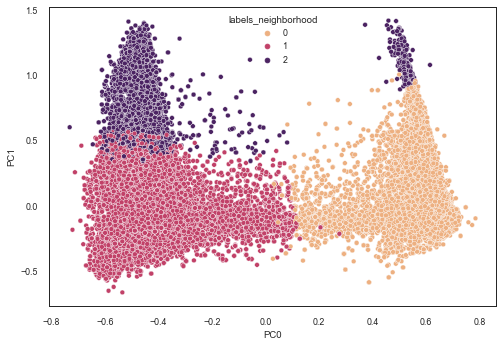

In [417]:
# df_for_plot = pd.concat([df_concat_km, df_neighbor[components_neighborhood]], axis = 1)
sns.set_style("white")
sns.scatterplot(data=df_neighbor_final, x="PC0", y="PC1", hue='labels_neighborhood', palette= 'flare')

In [418]:
labels_neighborhood = df_neighbor_final['labels_neighborhood']

### Interpretation of the Neighborhoods

Interpretation of the Neighborhood components:


- 'neigh_popularity' :  negative correlated with percent population in urbanized areas
- 'neigh_origin_1' : negative correlation with percent white, positive correlation with percent black
- 'neigh_origin_2' : positive correlation with percent hispanic and percent foreign born
- 'neigh_status_1' : negative correlation with percent married, positive with separated and never married
- 'neigh_status_2' : positive correlation with percent widowed
- 'neigh_quality_1' : positive correlated with all (higher values = good neighborhood)
- 'neigh_quality_2' : negative correlated with percent of houses occupied
- 'neigh_veterans_1' : positive correlated with percent veterans

Interpretation of Neighborhood clusters:

- <font color='blue'>**Cluster 0: The "Texas City" NeighborhoodThe "Manhattan" Neighborhood**</font>
 - not urbanized areas
 - prevalence of white people
 - prevalence of married people
 - not very rich neighborhood
 - Supposition: Neighborhoods outside the big cities and populated areas (Examples: Texas, Albuquerque, and all the center of USA)
 
- <font color='orange'>**Cluster 1: The "Manhattan" Neighborhood**</font> 
 - urbanized areas high populated
 - more international neighborhoods (higher percentage of hispanic and foreign born)
 - good quality of neighborhood (higher income)
 - Supposition: big neighborhood in the big famous cities (example: Manhattan in New York)
 
- <font color='green'>**Cluster 2: The "Bronx" Neighborhood**</font> 
 - urbanized areas high populated
 - high percentage of black people
 - low percentage of foreign born 
 - low percentage of married couples
 - poor neighborhoods (not good income)
 - low percentage of veterans
 - younger neighborhood
 - Supposition : the ghettos (Ex: Bronx)

t-SNE

In [ ]:
# # This is step can be quite time consuming
# two_dim = TSNE(random_state=42,n_jobs = -1).fit_transform(df[components_neighborhood])

In [ ]:
# pd.DataFrame(two_dim).plot.scatter(x=0, y=1, 
#                                    c=df_km_hc['labels_hc'], 
#                                    colormap='tab10', figsize=(15,10))
# plt.show()

# 4.5. Donors' behavior analysis: <a class="anchor" id="4.5"></a>

In this section, we will try to cluster with features representing the behaviour of the donors. These features are the summary features from the promotions sent by the PVA and the donation activities of the donors.

We tried to remove the outliers and clustering. But the results are worse than with the outliers. Therefore, we will keep all the dataset for clustering

In [ ]:
# outliner removal using LOF
#df_PG = log10_transformer(df.loc[~df.index.isin(outlier_lof_PG_feats), PG_feats_numeric],columns = PG_feats_numeric.drop(['CARDPM12','RECENCY']))

In [420]:
# Apply log10 transformation for numeri features except CARDPM12 and RECENCY
df_PG = log10_transformer(df[PG_feats_numeric], PG_feats_numeric.drop(['CARDPM12','RECENCY']))
# Scale the data with standard scaler
df_PG = pd.DataFrame(StandardScaler().fit_transform(df_PG),index = df_PG.index, columns=df_PG.columns)
# Set up the features
PG_feats_numeric_final = df_PG.columns
df_PG.head()

LOG_CARDPROM  CARDPM12  LOG_NUMPRM12  LOG_RAMNTALL  LOG_NGIFTALL  \
CONTROLN                                                                     
95515         0.944118  0.552039      0.474381      1.450081      1.778503   
148535       -0.551871  0.552039      0.209932     -0.551792     -0.847286   
15078         0.873209  0.552039      0.474381      1.237201      1.609888   
172556        0.944118  0.552039      0.474381      0.477036      0.979793   
7112          1.825396  3.884622      2.582702      1.520135      1.995505   

          LOG_MINRAMNT  LOG_MAXRAMNT  LOG_LASTGIFT  LOG_AVGGIFT   RECENCY  
CONTROLN                                                                   
95515        -0.255349     -0.776909     -0.689886    -0.796024 -0.125885  
148535        0.678290      0.755302      0.927690     0.581943 -0.125885  
15078        -1.323013     -0.183908     -1.829703    -0.860614 -0.125885  
172556       -1.323013     -0.953844     -0.689886    -1.036064 -0.125885  
7112         -0.879892     -0.317919      0.014711    -1.021798 -0.397433

## 4.5.1. K-means clustering:

https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

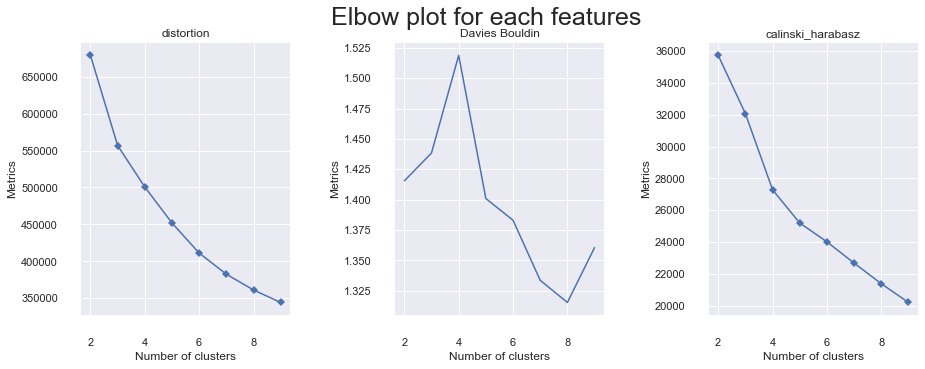

In [749]:
# plot the elbow plot
clusters_score(df_PG, range_clusters=(2, 10))

All three methods showing not completely clear result. However, there are points of evaluate the result:
- Observing the 'elbow' method,we can decide that the best number of clusters are between 3 and 6 clusters
- The DB index captures both the separation and compactness of the clusters. As DB index falls, the clustering improves. Therefore, the graph shows that 3 and 5 clusters can be considered good cluster solutions
- In the Calinski Harabasz plots, higher the Calinski-Harabasz Index value, better the clustering model. As can be observed, from 3 clusters to 4 clusters showed a significant drop in the index, so it can be concluded that 3 clusters is the optimum number of clusters regarding this index

Using the above analyis, we will continue to analyse the Silhouette coefficient to make the final decision on the number of clusters

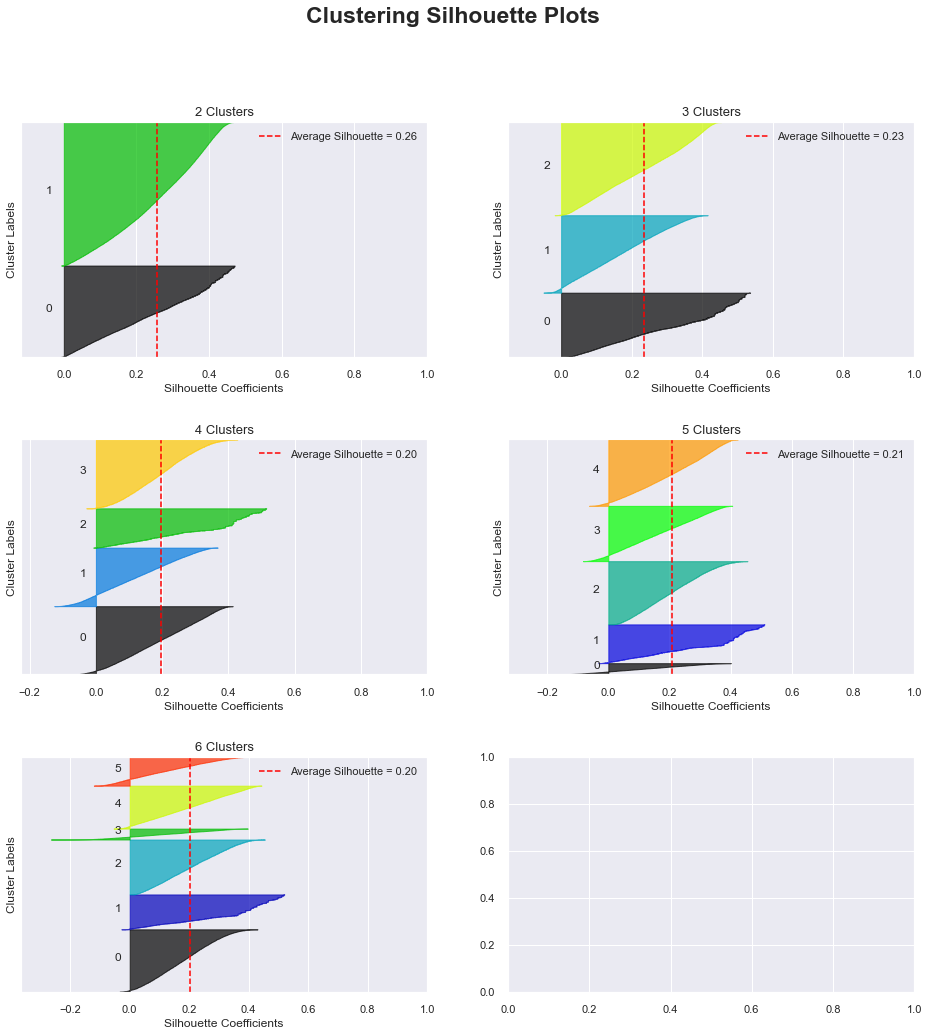

In [740]:
kmeans_model = KMeans(n_init=10, max_iter=300, tol=0.001)
# PLot silhouette coefficence score
silhouette_analysis(df_PG, estimator = kmeans_model, shape = (3,2), figsize = (16,16), max_nclus = 6, min_nclus=2, dist="euclidean")

<img src="figures/Silhouette_Kmeans.png">

The solution of 3 clusters showed a good result in term of score and class distribution
The solution of 4 clusters is a little lower in Silhouette score; 
And despite having a quite good Silhouette score, solution of 5 clusters faces an unbalanced cluster sizes.

**To sum up, we will continue the analysis using the number of clusters is 3**

In [741]:
# Now lets measure the R2 with 3 clusters
print('Solution of 3 clusters:')
kmeans_R2(df_PG,3)

Solution of 3 clusters:
Cluster solution with R^2 of 0.4052


## 4.5.2. Self-organizing map and K-means:

In [106]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    # TO-DO 
    data = df_PG.values,
    mapsize=(20,20),
    lattice='hexa',
    initialization='random',
    neighborhood='gaussian',
    name='sompy',
    training='batch',
    component_names=df_PG.columns
)

sm.train(n_job=-1, verbose=0, train_rough_len=100, train_finetune_len=100)

C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\sompy\visualization\plot_tools.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(shape[0], shape[1], comp + 1, aspect='equal')


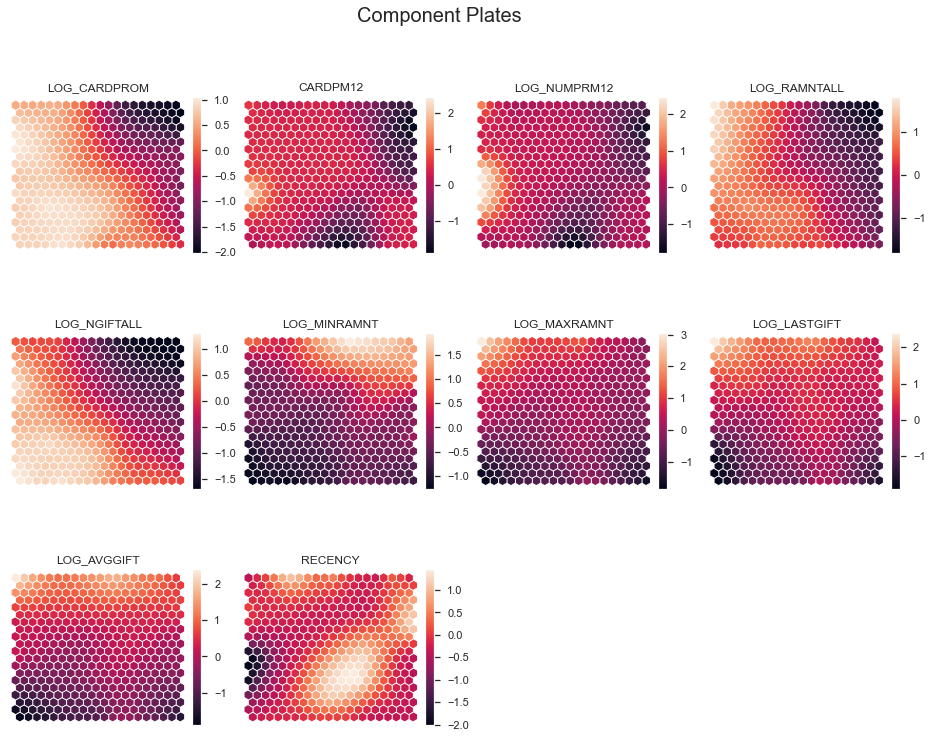

In [107]:
# Visualizing the Component plates (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=4, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Plates", fontsize=20)
plt.show()

From the component plant, we are able to carry out some analysis:
- `CARDPROM` has clusters distributed quite similar with `NGIFTALL`, both of them will have opposite values comparing to `MINRANMT`
- `LASTGIFT`, `AVGGIFT` and `MAXRAMNT` have clusters distributed quite similar with each other  
</br>  

Hence, there are some insights about the clusters:
- People who receive less promotion cards will tend to give less in terms of quantity and amount. However, the minimum amount of their gift is considerably high comparing to the others. 
- In contrast, the more promotion cards received, the more people tend to response to it with a donation
- However, an interesting point is that people who receive the most number of promotion cards will tend to give less in terms of amount of minimum, maximum, average and last donation.

In [108]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=22)

nodeclus_labels = sm.cluster(kmeans)

# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

df_nodes = pd.DataFrame(nodes, columns=PG_feats_numeric_final)
df_nodes['label'] = nodeclus_labels

# Obtaining SOM's BMUs labels
df_bmus = pd.DataFrame(
    np.concatenate((df_PG, np.expand_dims(sm._bmu[0],1)), axis=1),
                    index=df_PG.index, columns=np.append(df_PG.columns,"BMU")
)
# Get cluster labels for each observation
df_SOM_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True).drop('BMU',axis = 1)
df_SOM_final.head()

LOG_CARDPROM  CARDPM12  LOG_NUMPRM12  LOG_RAMNTALL  LOG_NGIFTALL  \
CONTROLN                                                                     
95515         0.944118  0.552039      0.474381      1.450081      1.778503   
148535       -0.551871  0.552039      0.209932     -0.551792     -0.847286   
15078         0.873209  0.552039      0.474381      1.237201      1.609888   
172556        0.944118  0.552039      0.474381      0.477036      0.979793   
7112          1.825396  3.884622      2.582702      1.520135      1.995505   

          LOG_MINRAMNT  LOG_MAXRAMNT  LOG_LASTGIFT  LOG_AVGGIFT   RECENCY  \
CONTROLN                                                                    
95515        -0.255349     -0.776909     -0.689886    -0.796024 -0.125885   
148535        0.678290      0.755302      0.927690     0.581943 -0.125885   
15078        -1.323013     -0.183908     -1.829703    -0.860614 -0.125885   
172556       -1.323013     -0.953844     -0.689886    -1.036064 -0.125885   
7112         -0.879892     -0.317919      0.014711    -1.021798 -0.397433   

          label  
CONTROLN         
95515         0  
148535        1  
15078         0  
172556        0  
7112          2

In [109]:
print('R2 score of the model:', r2(df_PG,df_SOM_final['label']))
print('Silhouette score of the model:', silhouette_score(df_PG,df_SOM_final['label']))

R2 score of the model: 0.38620719266535286
Silhouette score of the model: 0.2262271176868953


In [777]:
sns.countplot(df_SOM_final['label'])

NameError: name 'df_SOM_final' is not defined

Both R2 score and Silhouette score of the 'SOM & Kmeans' model are lower than the KMeans model alone. Thus, we will not use this model for the cluster analysis. However, the insight from Component planes is very useful for later intepretation.

## 4.5.3. K-means + Hierachical clustering:

In [110]:
kmeans_Hier_model = KMeans(n_clusters=1000,n_init=10, max_iter=200, tol=0.0001,random_state=1)
kmeans_Hier_model.fit(df_PG)

KMeans(max_iter=200, n_clusters=1000)

In [121]:
# Get R2 score of initial kmeans model with 1000 centroids
r2(df_PG,kmeans_Hier_model.labels_)

0.9428952491207983

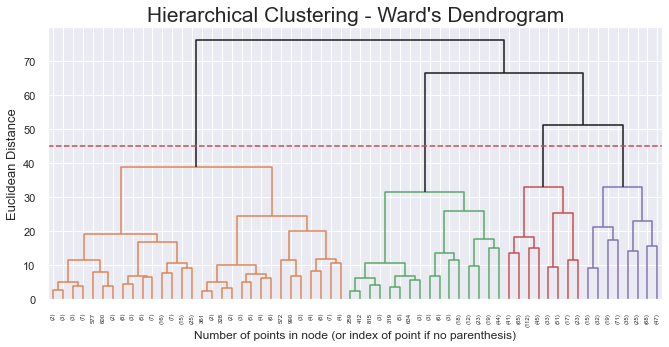

In [127]:
linkage='ward'
distance = 'euclidean'
centroids_df_kmean = pd.DataFrame(kmeans_Hier_model.cluster_centers_, columns = PG_feats_numeric_final)
# Define full tree hierachical clustering to find the optimal number of clusters
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit(centroids_df_kmean)
# Plot the dendogram of the full tree
dendogram_hclust(hclust, threshold=45)

We can conclude that there are clearly 3 clusters observed in the dendrogram. Thus, we will go with 3 clusters in this model

In [128]:
# 3 cluster solution
hc3lust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=4)
hc3_labels = hc3lust.fit_predict(centroids_df_kmean)
# Get labels of kmeans
df_PG_km_hc = pd.concat([df_PG, pd.Series(kmeans_Hier_model.labels_, index = df_PG.index, name='KMlabels')],axis = 1)
# Get labels of hierachical
df_PG_km_hc = df_PG_km_hc.merge(pd.Series(hc3_labels, name='labels') , left_on='KMlabels', right_index=True)

In [130]:
# Get R2 score of final cluster solution
print('R2 score of the "KMeans & Hierachical" cluster solution:',
      r2(df_PG_km_hc[PG_feats_numeric_final],df_PG_km_hc['labels']))

print('Silhouette score of the model:', 
      silhouette_score(df_PG_km_hc[PG_feats_numeric_final], df_PG_km_hc['labels']))

R2 score of the "KMeans & Hierachical" cluster solution: 0.35358117140894285
Silhouette score of the model: 0.1981014663004643


<AxesSubplot:xlabel='labels', ylabel='count'>

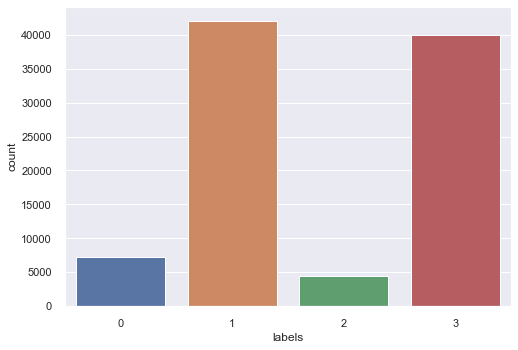

In [131]:
sns.countplot(x = df_PG_km_hc['labels'])

- The size of each cluster is not well distributed. Despite the dendogram from hierachical clustering showed a considerably good distance from each clusters. It seemed like the clusters number 0 dominated the dataset while cluster number 2 does not have a significant number of representatives.  
- Moreover, R2 of only 0.1951 is not showing a good result comparing to KMeans model individually (0.4).  

Therefore, we will not consider this method in our cluster solution.    

## 4.5.4. Final clustering solution (K-means) and visualizing results:

Since KMeans has outperformed other clustering solution regarding both R2, clusters' size and silhouette coeefiction, we will choose KMeans as our final clustering model for the Donor behavior cluster analysis

In [421]:
kmeans_model_final = KMeans(n_clusters=3, n_init=15, max_iter=300, tol=0.0001, random_state=1)
kmeans_model_final.fit(df_PG)

KMeans(n_clusters=3, n_init=15, random_state=1)

In [422]:
print('R2 score of the model:', r2(df_PG, kmeans_model_final.labels_))
#print('Silhouette score of the model:', silhouette_score(df_PG,kmeans_model_final.labels_))

R2 score of the model: 0.40620696798605194


In [423]:
df_PG_final = pd.concat([df, pd.Series(kmeans_model_final.labels_,index = df_PG.index, name = 'labels_PG')],axis =1 )

<AxesSubplot:xlabel='labels_PG', ylabel='count'>

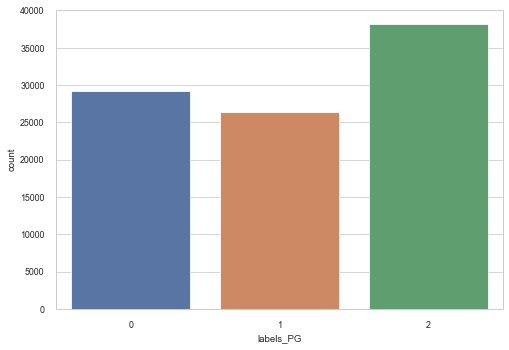

In [425]:
sns.set_style('whitegrid')
sns.countplot(x = df_PG_final['labels_PG'])

Size of each cluster is equally distributed

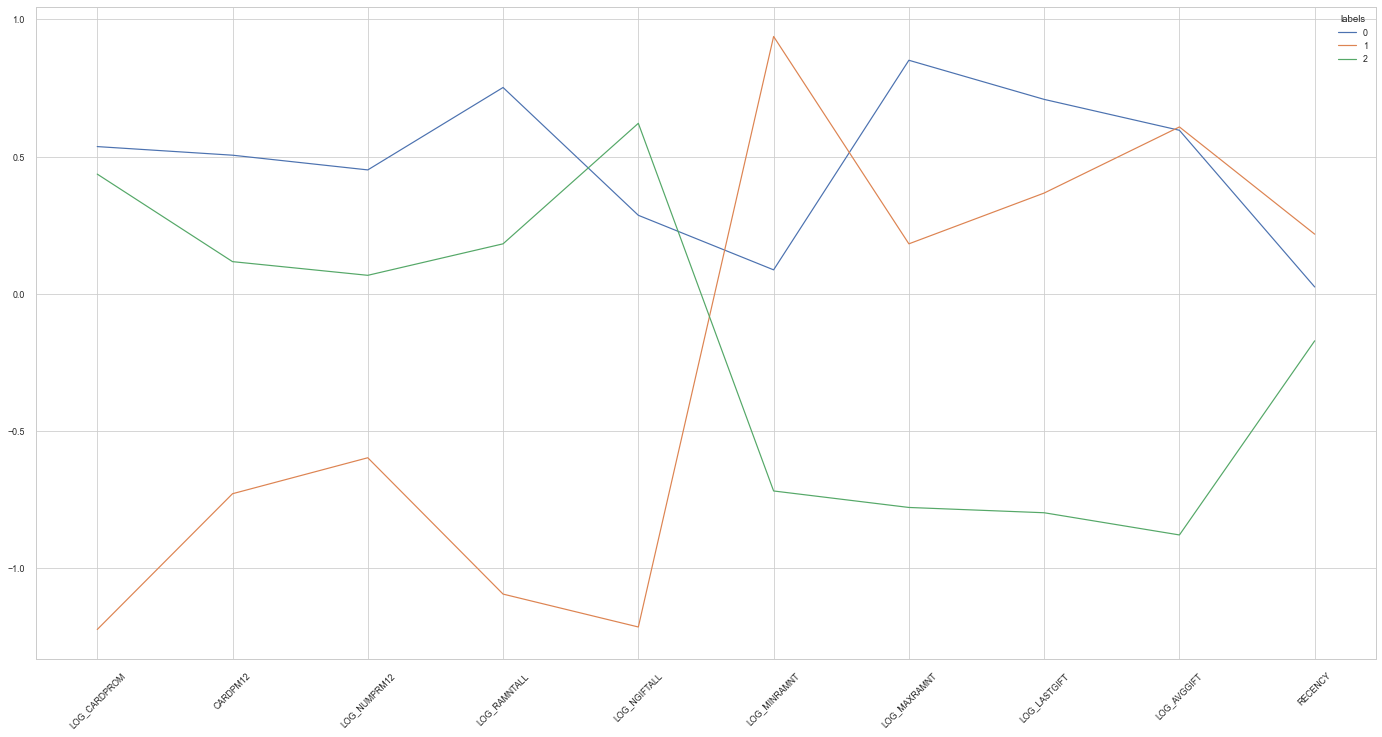

In [426]:
meanplot_df(df_PG,df_PG_final['labels_PG'] )

- <font color='blue'>**Cluster 0: The Loyal Donor**</font>
  - Receive very high number of card promotion since the first date. They also receive the most number of promotions and card promotions in the current/last year. They can be the most senior people who had donated since the very first date of the organization
  - These donors have the highest value of donation without having the most number of donating times. They also have the highest value regarding to the maximum donation amount. This also make sense with the value of their average gift which is also one of the highests.  
  
        
- <font color='orange'>**Cluster 1: The Rising Donor**</font>
  - Receive very small number of promotion cards since their first time donation, this could be because of they had started donated recently. However, they also receive a relatively small number of promotion this year. This could be because they are not very active donor, so the association does not send them too much cards
  - Despite the total amount of donation and total number of gifts is low. They have the highest score in term of average amount of gifts. This infomation also comfirm our previous analysis that they started to donate much later than the others
  - These donors also have the highest for the amount of minimum gift. Our intepretation in this case is that because they do not donate a lot of time, so everytime they donate, the amount is fairly higher than other people who donate more in term of frequency 
  
  
- <font color='green'>**Cluster 2: The Active Donor**</font>  
  - Having the highest number of donation. They are also very active in term of receiving promotion and respond to these promotions
  - The value of each donation is relatively small but on the other hand, they donate very frequently


### Clusters profiling
**Now, let's analyse the cluster with the RFA (Recency, Frequency and Monetary) score which is defined for each donor by PVA history file**

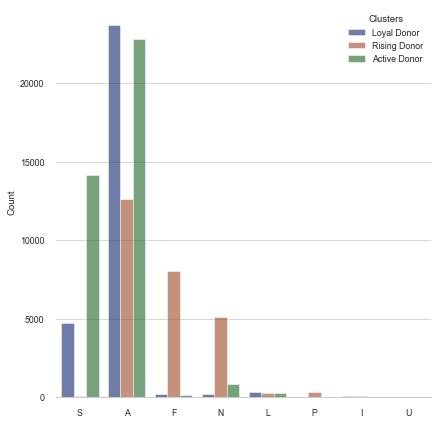

In [427]:
# RFA_USEDTO_R
g = sns.catplot(
    data=df_PG_final, kind="count",
    x="RFA_USEDTO_R", hue="labels_PG",
    ci="sd", palette="dark", alpha=.6, height=6,legend_out=False
)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("Clusters")
new_labels = ['Loyal Donor', 'Rising Donor', 'Active Donor']
for t, l in zip(g.legend.texts, new_labels): t.set_text(l)
plt.show()

- F=FIRST TIME DONOR - Anyone who has made their first donation in the last 6 months and has made just one donation.
- N=NEW DONOR - Anyone who has made their first donation in the last 12 months and is not a First time donor.  This is everyone who made their first donation 7-12 months ago, or people who made their first donation between 0-6 months ago and have made 2 or more donations.
- A=ACTIVE DONOR - Anyone who made their first donation more than 12 months ago and has made a donation in the last 12 months.
- L=LAPSING DONOR - A previous donor who made their last donation between 13-24 months ago.
- I=INACTIVE DONOR - A previous donor who has not made a donation in the last 24 months. It is people who made a donation 25+ months ago.
- S=STAR DONOR - Donors are individuals who have given to 3 consecutive card mailings.

**It clearly makes sense that Loyal Donor and Active Donor hold a significant number STAR DONOR and ACTIVE DONOR. Since Active Donor tend to give more, they also holds the most number in STAR DONOR.
Rising donor falls mostly in FIRST TIME DONOR AND NEW DONOR as they may only start to donate less then a year, which is also align with our previous analysis on the mean value of Recency**

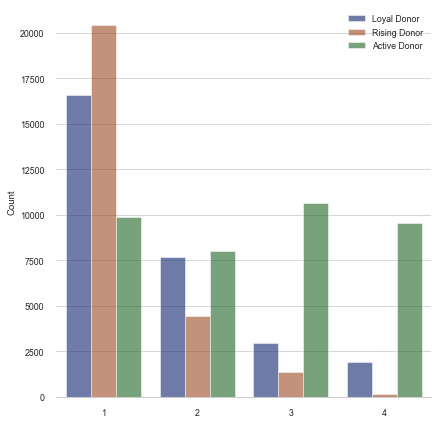

In [428]:
# RFA_USEDTO_R
g = sns.catplot(
    data=df_PG_final, kind="count",
    x="RFA_2F", hue="labels_PG",
    ci="sd", palette="dark", alpha=.6, height=6, legend_out=False
)
g.despine(left=True)
g.set_axis_labels("", "Count")
new_labels = ['Loyal Donor', 'Rising Donor', 'Active Donor']
for t, l in zip(g.legend.texts, new_labels): t.set_text(l)
g.legend.set_title("")

1=One gift in the period of recency  
2=Two gift in the period of recency  
3=Three gifts in the period of recency  
4=Four or more gifts in the period of recency  

**Active donor give more in the number of gifts comparing to Loyal and Rising Donor**

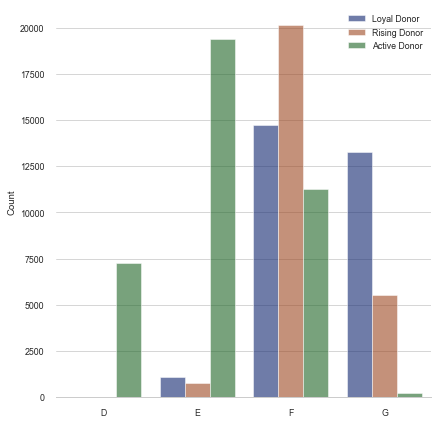

In [429]:
# RFA_USEDTO_R
g = sns.catplot(
    data=df_PG_final, kind="count",
    x="RFA_2A", hue="labels_PG",order=['D','E','F','G'],
    ci="sd", palette="dark", alpha=.6, height=6, legend_out=False
)
g.despine(left=True)

g.set_axis_labels("", "Count")
new_labels = ['Loyal Donor', 'Rising Donor', 'Active Donor']
for t, l in zip(g.legend.texts, new_labels): t.set_text(l)
g.legend.set_title("")

Third byte of the code is the Amount of the last gift.  

                            A=$0.01  -  $1.99  
                            B=$2.00  -  $2.99  
                            C=$3.00  -  $4.99  
                            D=$5.00  -  $9.99  
                            E=$10.00 - $14.99  
                            F=$15.00 - $24.99  
                            G=$25.00 and above  

**Active donor give less in the amount of gifts comparing to Loyal and Rising Donor**

<AxesSubplot:xlabel='AGE', ylabel='Density'>

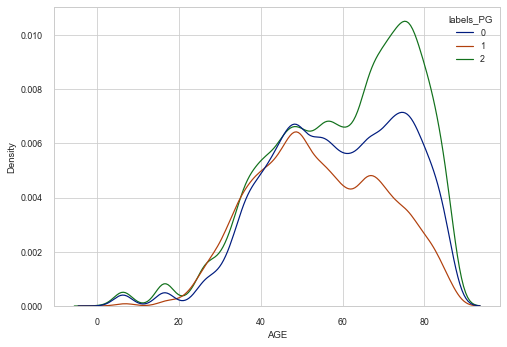

In [430]:
sns.kdeplot(data=df_PG_final, 
             x="AGE", hue="labels_PG",
             palette="dark")

<AxesSubplot:xlabel='INCOME', ylabel='Density'>

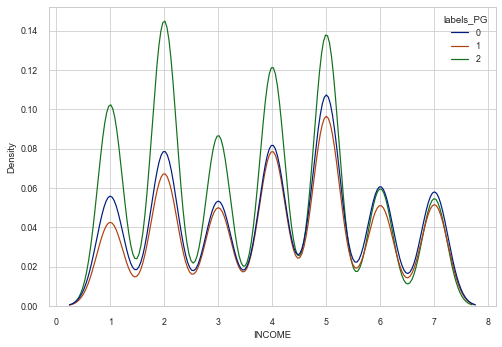

In [431]:
sns.kdeplot(data=df_PG_final, 
             x="INCOME", hue="labels_PG",
             palette="dark")

The intuition here is that in order to give meaning to a cluster, you have to see how different it is from other clusters. An efficient way to see how a cluster is different from its neighbour is to focus on dimensions or columns which vary the most. One way of obtaining the most varying columns is to take the result of PCA. The PCA effectively retains the dimension which vary the most and compresses the dimensions which vary the least.
https://towardsdatascience.com/interpreting-clusters-29975099eea1

In [432]:
pca_combined = PCA_combined(df_PG)
pca_combined.PCA_test(n_components = 4)
pca_combined.corr_PCA().style.applymap(_color_red_or_green)

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

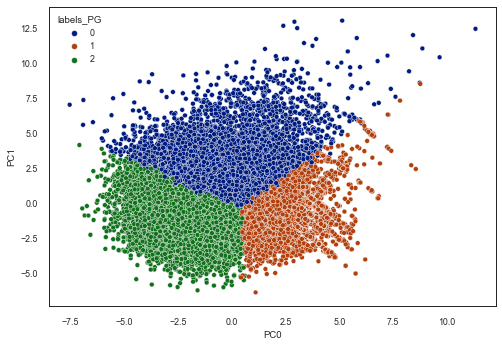

In [434]:
sns.set_style("white")
sns.scatterplot(x='PC0',
                y='PC1',
                data=pca_combined.pca_df_,
                palette="dark",
                hue = df_PG_final['labels_PG'])

In [435]:
PG_pca_names = ['PG_PC0', 'PG_PC1', 'PG_PC2', 'PG_PC3']
df_PG_pca_final = pd.DataFrame(data = pca_combined.pca_df_.values, index=df_PG.index,columns=PG_pca_names)

In [436]:
PG_pca_names = ['PG_PC0', 'PG_PC1', 'PG_PC2', 'PG_PC3']
df_PG_pca_final = pd.DataFrame(data = pca_combined.pca_df_.values, index=df_PG.index,columns=PG_pca_names)
df_PG_pca_final = pd.concat([df_PG_pca_final , df_PG_final['labels_PG']],axis = 1)
df_PG_pca_final.head()

PG_PC0    PG_PC1    PG_PC2    PG_PC3  labels_PG
CONTROLN                                                   
95515    -2.629089  0.350456 -0.364743  0.089845          2
148535    1.510738  0.857072  0.706409 -0.368508          1
15078    -3.113106 -0.109274 -0.254738  0.119217          2
172556   -2.535184 -0.447457 -0.007583 -0.269075          2
7112     -4.365550  2.720300  1.515968 -1.943676          0

From the scatter plot of the first two principle components (PC), all three clusters are considerably well distinguished. The correlation between the PCs and the features also 

https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e
https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

In [437]:
labels_PG = df_PG_final['labels_PG']

# 5. Merging the results  <a class="anchor" id="5"></a>
- How can we merge different cluster solutions?

In [453]:
concat_labels = pd.concat([labels_interests, labels_mail, labels_neighborhood,labels_PG],axis = 1)
concat_labels['labels_mail'] = concat_labels['labels_mail'].fillna(value=3,axis = 0).astype(int)

In [454]:
concat_labels.head()

labels_interests  labels_mail  labels_neighborhood  labels_PG
CONTROLN                                                               
4                        3            0                    0          0
5                        3            3                    0          0
7                        0            0                    1          0
8                        3            3                    2          2
10                       2            2                    1          0

In [455]:
df_with_labels = df.merge(concat_labels,left_index=True, right_index=True)
df_with_labels.head()

ODATEDW OSOURCE  TCODE STATE    ZIP DOMAIN HOMEOWNR  NUMCHLD  \
CONTROLN                                                                    
95515     2009-01-01     GRI      0    IL  61081     T2      NaN      NaN   
148535    2014-01-01     BOA      1    CA  91326     S1        H      1.0   
15078     2010-01-01     AMH      1    NC  27017     R2        U      NaN   
172556    2007-01-01     BRY      0    CA  95953     R2        U      NaN   
7112      2006-01-01     NaN      0    FL  33176     S2        H      1.0   

          INCOME GENDER  ...  GEOCODE2   AGE  RFA_USEDTO_R  RFA_USEDTO_F  \
CONTROLN                 ...                                               
95515        NaN      F  ...         C  59.0             S             4   
148535       6.0      M  ...         A  45.0             A             2   
15078        3.0      M  ...         C   NaN             S             4   
172556       1.0      F  ...         C  69.0             S             4   
7112         3.0      F  ...         A  77.0             A             2   

          RFA_USEDTO_A  RECENCY  labels_interests  labels_mail  \
CONTROLN                                                         
95515                E    428.0                 3            3   
148535               G    428.0                 3            2   
15078                E    428.0                 3            0   
172556               E    428.0                 3            0   
7112                 F    397.0                 0            1   

          labels_neighborhood  labels_PG  
CONTROLN                                  
95515                       0          2  
148535                      1          1  
15078                       0          2  
172556                      0          2  
7112                        2          0  

[5 rows x 93 columns]

## 5.1. Merging using hierachical clustering:

In [790]:
df_PG_scaled_tomerge = pd.DataFrame(StandardScaler().fit_transform(df_PG),
                              index = df_PG.index, 
                              columns=df_PG.columns)

#df_interest_scaled_tomerge = pd.DataFrame(StandardScaler().fit_transform(df_interests.iloc[:,:-1]),
#                              index = df_interests.iloc[:,:-1].index, 
#                              columns=df_interests.iloc[:,:-1].columns)

df_neighborhood_scaled_tomerge = pd.DataFrame(StandardScaler().fit_transform(df_neighbor_final[components_neighborhood]),
                              index = df_neighbor_final[components_neighborhood].index, 
                             columns=df_neighbor_final[components_neighborhood].columns)


df_merged = pd.concat([df_neighborhood_scaled_tomerge, df_PG_scaled_tomerge], axis = 1)

In [791]:
#df_merged = df_merged.merge(concat_labels[['labels_interests', 'labels_PG']], left_index=True, right_index=True)
df_merged = df_merged.merge(concat_labels[['labels_neighborhood', 'labels_PG']], left_index=True, right_index=True)

In [792]:
df_centroids = df_merged.groupby(['labels_neighborhood','labels_PG']).mean()
df_centroids

PC0       PC1       PC2       PC3  \
labels_neighborhood labels_PG                                           
0                   0          1.199201 -0.010009  0.177354  0.016077   
                    1          1.190764  0.042223  0.217672 -0.016772   
                    2          1.215562  0.008622  0.083709  0.011407   
1                   0         -0.800669 -0.329136 -0.019992  0.006491   
                    1         -0.801061 -0.263361 -0.015645 -0.127238   
                    2         -0.769875 -0.265278 -0.263571 -0.114928   
2                   0         -0.844008  3.175982  0.127834  0.914667   
                    1         -0.826177  3.251330  0.151403  0.838545   
                    2         -0.806551  3.100171  0.003761  0.838738   

                                    PC4  LOG_CARDPROM  CARDPM12  LOG_NUMPRM12  \
labels_neighborhood labels_PG                                                   
0                   0          0.006959      0.556645  0.477977      0.421222   
                    1         -0.022583     -1.218211 -0.725100     -0.594144   
                    2          0.032973      0.465222  0.101219      0.046690   
1                   0          0.046580      0.522375  0.520794      0.467274   
                    1          0.037400     -1.236798 -0.738117     -0.603387   
                    2          0.107539      0.413454  0.130341      0.085154   
2                   0         -0.917021      0.490214  0.455106      0.382858   
                    1         -0.850596     -1.228825 -0.737049     -0.597754   
                    2         -0.823404      0.370969  0.098897      0.058165   

                               LOG_RAMNTALL  LOG_NGIFTALL  LOG_MINRAMNT  \
labels_neighborhood labels_PG                                             
0                   0              0.744569      0.313323      0.036748   
                    1             -1.101827     -1.205578      0.904680   
                    2              0.187923      0.651744     -0.742832   
1                   0              0.753591      0.272954      0.114131   
                    1             -1.092397     -1.225521      0.971986   
                    2              0.177128      0.602572     -0.702349   
2                   0              0.634249      0.188904      0.093443   
                    1             -1.123747     -1.237742      0.950086   
                    2              0.115418      0.528873     -0.665508   

                               LOG_MAXRAMNT  LOG_LASTGIFT  LOG_AVGGIFT  \
labels_neighborhood labels_PG                                            
0                   0              0.812924      0.674722     0.535880   
                    1              0.160195      0.346691     0.575944   
                    2             -0.800898     -0.814708    -0.917817   
1                   0              0.865133      0.718918     0.623612   
                    1              0.201978      0.383590     0.639085   
                    2             -0.770734     -0.796307    -0.855561   
2                   0              0.797503      0.711009     0.573736   
                    1              0.176597      0.391660     0.613245   
                    2             -0.740776     -0.727516    -0.829298   

                                RECENCY  
labels_neighborhood labels_PG            
0                   0          0.049271  
                    1          0.225656  
                    2         -0.165587  
1                   0          0.016553  
                    1          0.217028  
                    2         -0.181704  
2                   0          0.038228  
                    1          0.172809  
                    2         -0.152894

In [793]:
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

In [794]:
cluster_mapper = {}
for i, clust in zip(df_centroids.index, hclust_labels):
    cluster_mapper[clust] = i
cluster_mapper    

{7: (0, 0),
 8: (0, 1),
 6: (0, 2),
 5: (1, 0),
 4: (1, 1),
 3: (1, 2),
 2: (2, 0),
 1: (2, 1),
 0: (2, 2)}

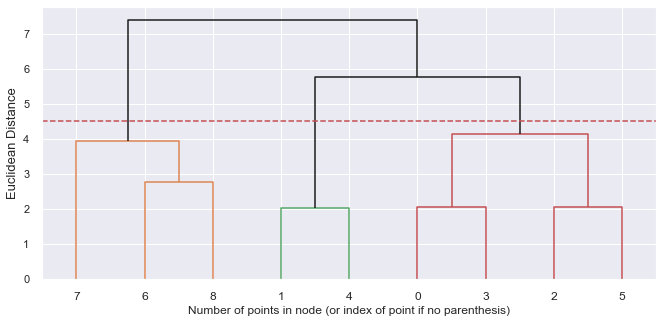

In [686]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 4.5
dendrogram(linkage_matrix, truncate_mode='level',  p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
# plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

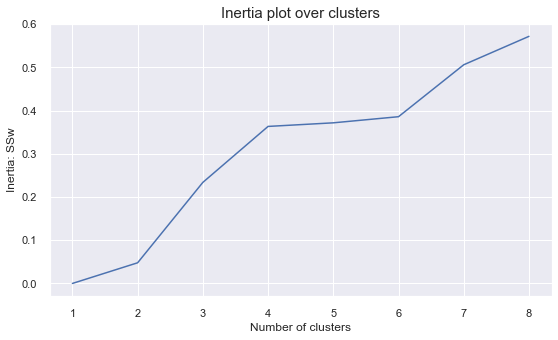

In [689]:
def inertia_plot_formerged(df_merged, df_centroids):
    range_clusters = range(1, 9)

    inertia = []
    for n_clus in range_clusters:  # iterate over desired ncluster range
        # Re-running the Hierarchical clustering based on the correct number of clusters
        hclust = AgglomerativeClustering(
            linkage='ward', 
            affinity='euclidean', 
            n_clusters=n_clus
        )        
        hclust_labels = hclust.fit_predict(df_centroids)
        df_centroids['hclust_labels'] = hclust_labels
        # Mapper between concatenated clusters and hierarchical clusters
        cluster_mapper = df_centroids['hclust_labels'].to_dict()

        df_ = df_merged.copy()

        # Mapping the hierarchical clusters on the centroids to the observations
        df_['merged_labels'] = df_.apply(
            lambda row: cluster_mapper[
                (row['labels_neighborhood'],  row['labels_PG'])
            ], axis=1
        )
        # Merged cluster centroids
        inertia.append(r2(df_, df_['merged_labels']))  # save the inertia of the given cluster solution

    # The inertia plot
    plt.figure(figsize=(9,5))
    plt.plot(pd.Series(inertia, index = range_clusters))
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters")
    plt.xticks(range_clusters)
    plt.title("Inertia plot over clusters", size=15)
    plt.show()   
        
inertia_plot_formerged(df_merged, df_centroids)

In [795]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=5
)

hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

PC0       PC1       PC2       PC3  \
labels_neighborhood labels_PG                                           
0                   0          1.199201 -0.010009  0.177354  0.016077   
                    1          1.190764  0.042223  0.217672 -0.016772   
                    2          1.215562  0.008622  0.083709  0.011407   
1                   0         -0.800669 -0.329136 -0.019992  0.006491   
                    1         -0.801061 -0.263361 -0.015645 -0.127238   
                    2         -0.769875 -0.265278 -0.263571 -0.114928   
2                   0         -0.844008  3.175982  0.127834  0.914667   
                    1         -0.826177  3.251330  0.151403  0.838545   
                    2         -0.806551  3.100171  0.003761  0.838738   

                                    PC4  LOG_CARDPROM  CARDPM12  LOG_NUMPRM12  \
labels_neighborhood labels_PG                                                   
0                   0          0.006959      0.556645  0.477977      0.421222   
                    1         -0.022583     -1.218211 -0.725100     -0.594144   
                    2          0.032973      0.465222  0.101219      0.046690   
1                   0          0.046580      0.522375  0.520794      0.467274   
                    1          0.037400     -1.236798 -0.738117     -0.603387   
                    2          0.107539      0.413454  0.130341      0.085154   
2                   0         -0.917021      0.490214  0.455106      0.382858   
                    1         -0.850596     -1.228825 -0.737049     -0.597754   
                    2         -0.823404      0.370969  0.098897      0.058165   

                               LOG_RAMNTALL  LOG_NGIFTALL  LOG_MINRAMNT  \
labels_neighborhood labels_PG                                             
0                   0              0.744569      0.313323      0.036748   
                    1             -1.101827     -1.205578      0.904680   
                    2              0.187923      0.651744     -0.742832   
1                   0              0.753591      0.272954      0.114131   
                    1             -1.092397     -1.225521      0.971986   
                    2              0.177128      0.602572     -0.702349   
2                   0              0.634249      0.188904      0.093443   
                    1             -1.123747     -1.237742      0.950086   
                    2              0.115418      0.528873     -0.665508   

                               LOG_MAXRAMNT  LOG_LASTGIFT  LOG_AVGGIFT  \
labels_neighborhood labels_PG                                            
0                   0              0.812924      0.674722     0.535880   
                    1              0.160195      0.346691     0.575944   
                    2             -0.800898     -0.814708    -0.917817   
1                   0              0.865133      0.718918     0.623612   
                    1              0.201978      0.383590     0.639085   
                    2             -0.770734     -0.796307    -0.855561   
2                   0              0.797503      0.711009     0.573736   
                    1              0.176597      0.391660     0.613245   
                    2             -0.740776     -0.727516    -0.829298   

                                RECENCY  hclust_labels  
labels_neighborhood labels_PG                           
0                   0          0.049271              3  
                    1          0.225656              2  
                    2         -0.165587              1  
1                   0          0.016553              3  
                    1          0.217028              2  
                    2         -0.181704              1  
2                   0          0.038228              0  
                    1          0.172809              4  
                    2         -0.152894              0

In [796]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df_merged.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['labels_neighborhood'], row['labels_PG'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()

PC0       PC1       PC2       PC3       PC4  LOG_CARDPROM  \
merged_labels                                                                   
0             -0.824203  3.135896  0.062229  0.874519 -0.867520      0.427162   
1              0.116727 -0.142967 -0.108492 -0.058513  0.074241      0.436571   
2             -0.022080 -0.143850  0.075602 -0.084036  0.013941     -1.229529   
3              0.001340 -0.201156  0.059150  0.010335  0.030690      0.536119   
4             -0.826177  3.251330  0.151403  0.838545 -0.850596     -1.228825   

               CARDPM12  LOG_NUMPRM12  LOG_RAMNTALL  LOG_NGIFTALL  \
merged_labels                                                       
0              0.266757      0.211174      0.359913      0.368666   
1              0.117336      0.067978      0.181949      0.624530   
2             -0.733026     -0.599772     -1.096085     -1.217721   
3              0.503623      0.448806      0.749973      0.289143   
4             -0.737049     -0.597754     -1.123747     -1.237742   

               LOG_MINRAMNT  LOG_MAXRAMNT  LOG_LASTGIFT  LOG_AVGGIFT  \
merged_labels                                                          
0                 -0.307859     -0.015875     -0.049624    -0.168131   
1                 -0.720426     -0.784204     -0.804524    -0.883361   
2                  0.945663      0.185637      0.369159     0.614391   
3                  0.083098      0.844196      0.701194     0.588429   
4                  0.950086      0.176597      0.391660     0.613245   

                RECENCY  labels_neighborhood  labels_PG  
merged_labels                                            
0             -0.062829             2.000000   1.057518  
1             -0.174507             0.553447   2.000000  
2              0.220403             0.608911   1.000000  
3              0.029674             0.598969   0.000000  
4              0.172809             2.000000   1.000000

C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='merged_labels', ylabel='count'>

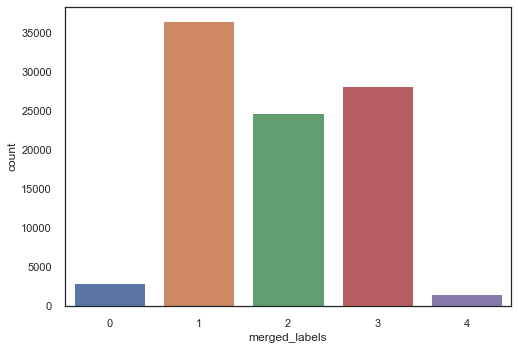

In [797]:
sns.countplot(df_['merged_labels'])

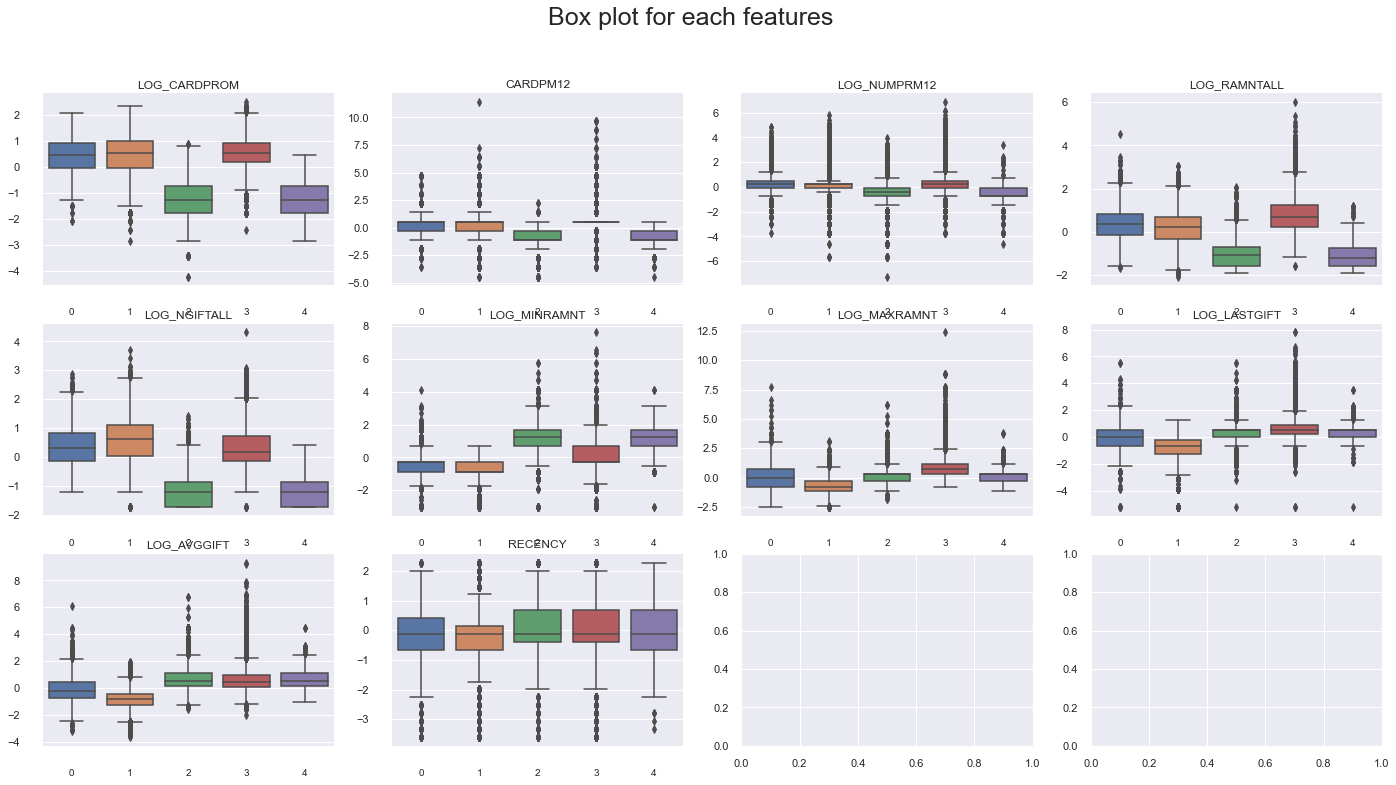

In [798]:
boxplot_withLabels(df_[PG_feats_numeric_final],df_['merged_labels'])

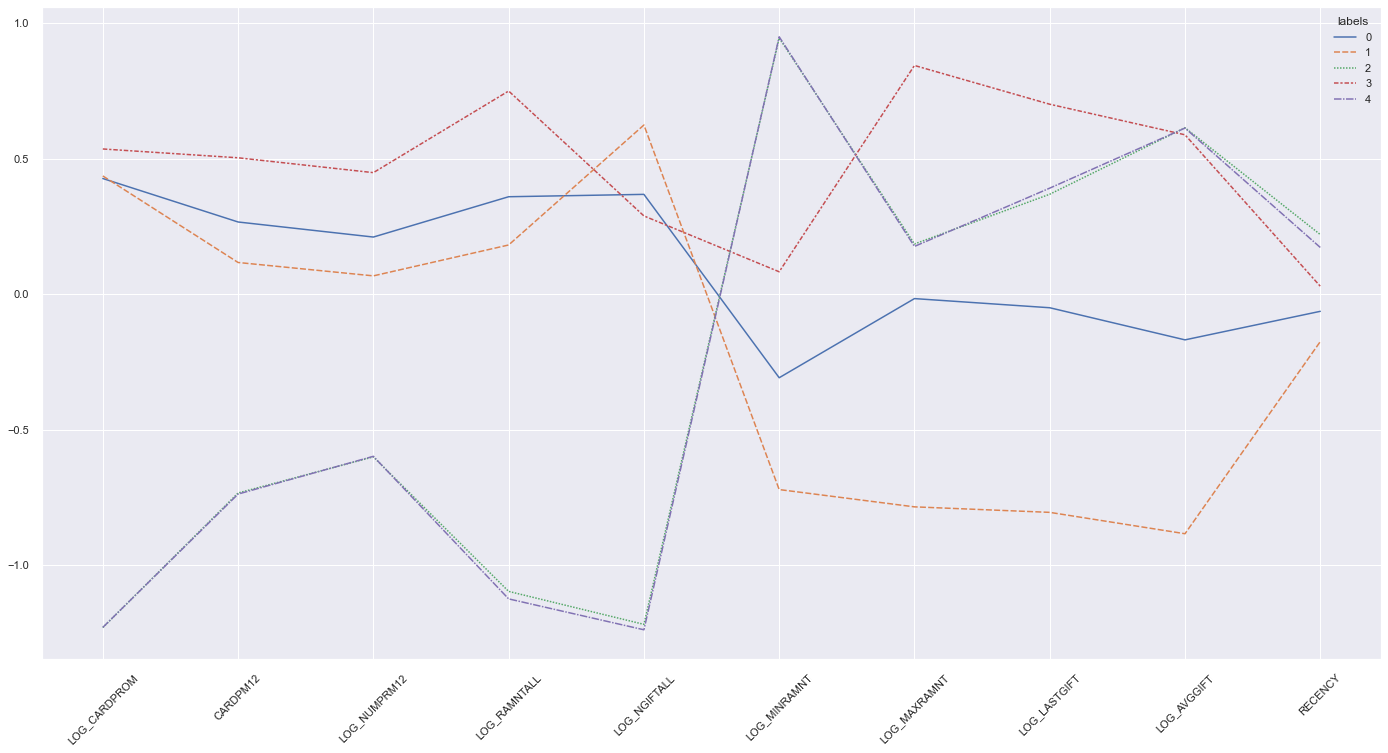

In [799]:
meanplot_df(df_[PG_feats_numeric_final],df_['merged_labels'])

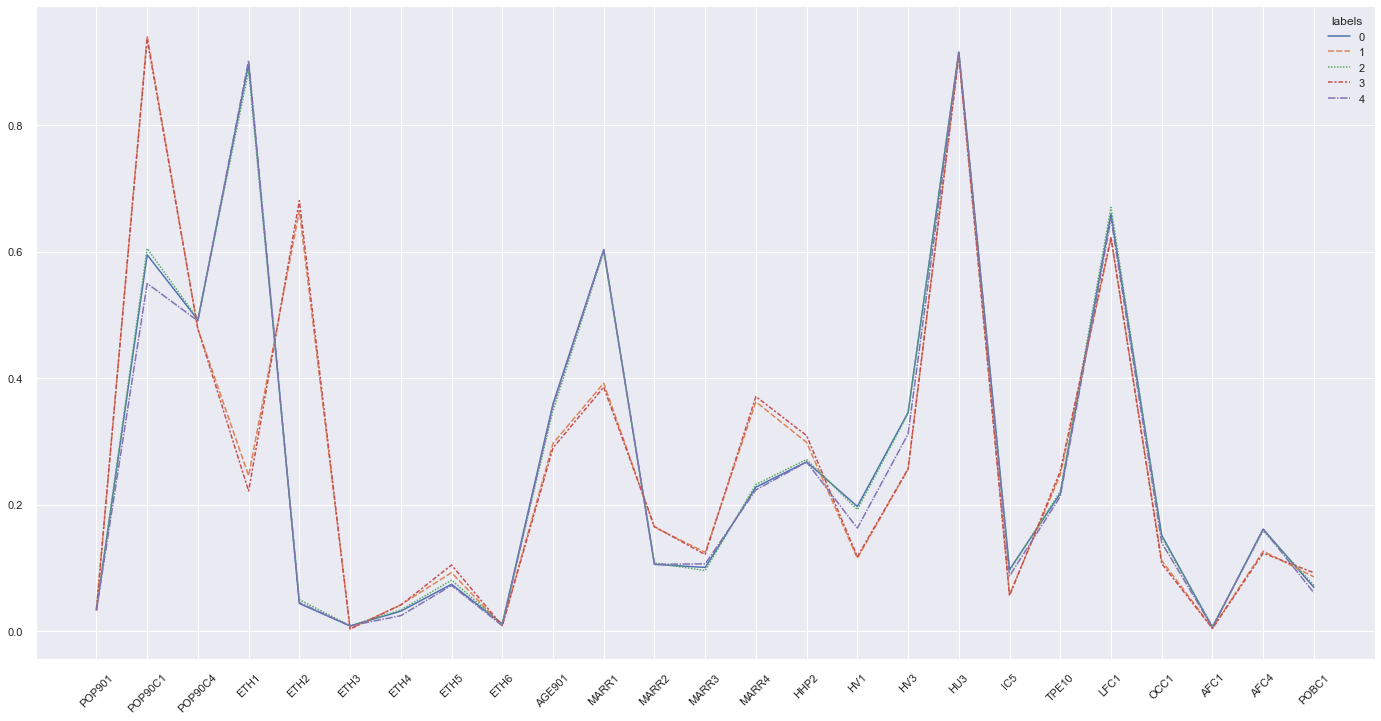

In [694]:
#meanplot_df(df_[components_neighborhood],df_['merged_labels'])
meanplot_df(df[neighborhood],df_['merged_labels'])

In [709]:
df[interest_feats]

COLLECT1  VETERANS  BIBLE  CATLG  HOMEE  PETS  CDPLAY  STEREO  \
CONTROLN                                                                  
95515            0         0      0      0      0     0       0       0   
148535           0         0      0      0      0     0       0       0   
15078            0         0      0      0      0     0       0       0   
172556           0         0      0      0      0     0       0       0   
7112             0         0      1      1      0     0       0       1   
...            ...       ...    ...    ...    ...   ...     ...     ...   
184568           0         0      0      0      0     0       0       0   
122706           0         0      0      0      0     0       0       0   
189641           0         0      0      0      0     0       0       0   
4693             0         0      0      0      0     0       0       0   
185114           0         0      0      0      0     0       0       0   

          PCOWNERS  PHOTO  CRAFTS  FISHER  GARDENIN  BOATS  WALKER  KIDSTUFF  \
CONTROLN                                                                       
95515            0      0       0       0         0      0       0         0   
148535           0      0       0       0         0      0       0         0   
15078            0      0       0       0         0      0       0         0   
172556           0      0       0       0         0      0       0         0   
7112             0      0       1       0         1      0       1         0   
...            ...    ...     ...     ...       ...    ...     ...       ...   
184568           0      0       0       0         0      0       0         0   
122706           0      0       0       0         0      0       0         0   
189641           0      0       0       0         0      0       0         0   
4693             0      0       0       0         0      0       0         0   
185114           0      0       0       0         0      0       0         0   

          CARDS  PLATES  
CONTROLN                 
95515         0       0  
148535        0       0  
15078         0       0  
172556        0       0  
7112          1       0  
...         ...     ...  
184568        0       0  
122706        0       0  
189641        0       0  
4693          0       0  
185114        0       0  

[93760 rows x 18 columns]

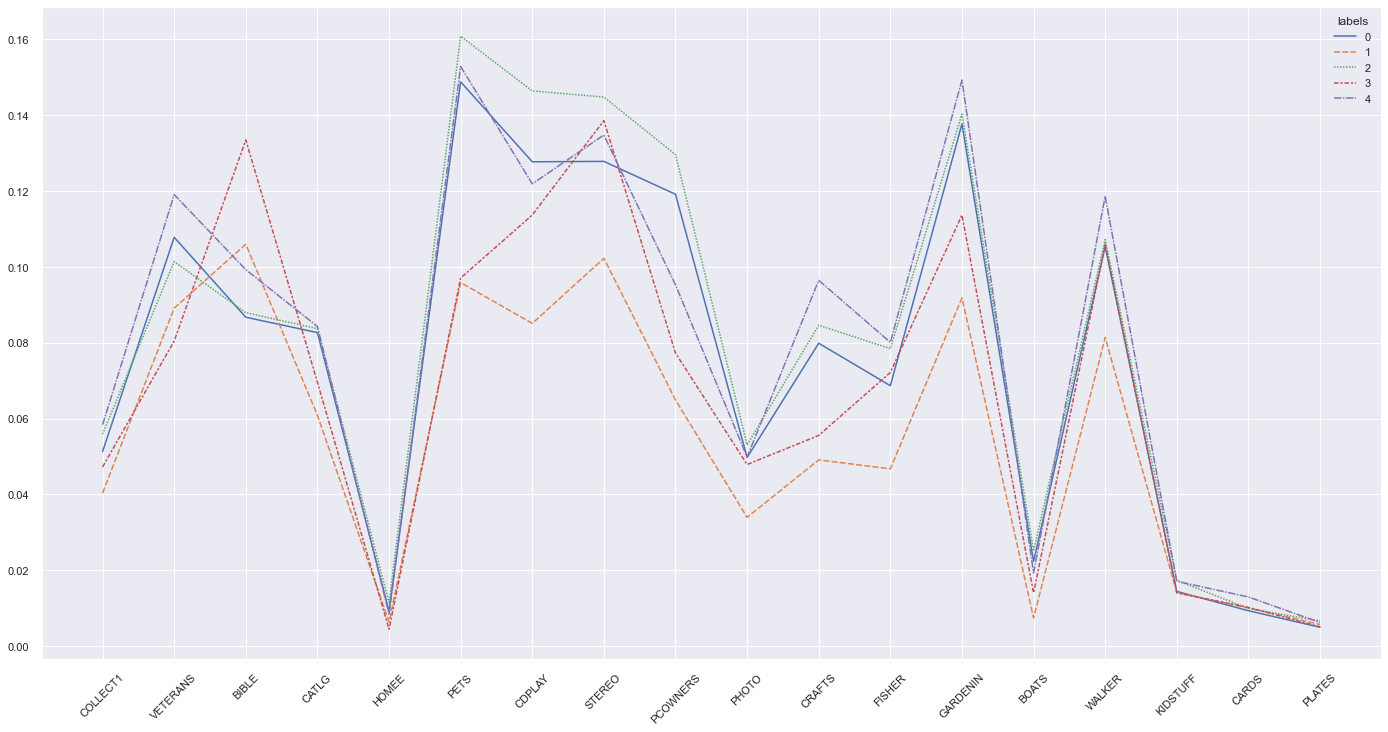

In [696]:
meanplot_df(df[interest_feats],df_['merged_labels'])

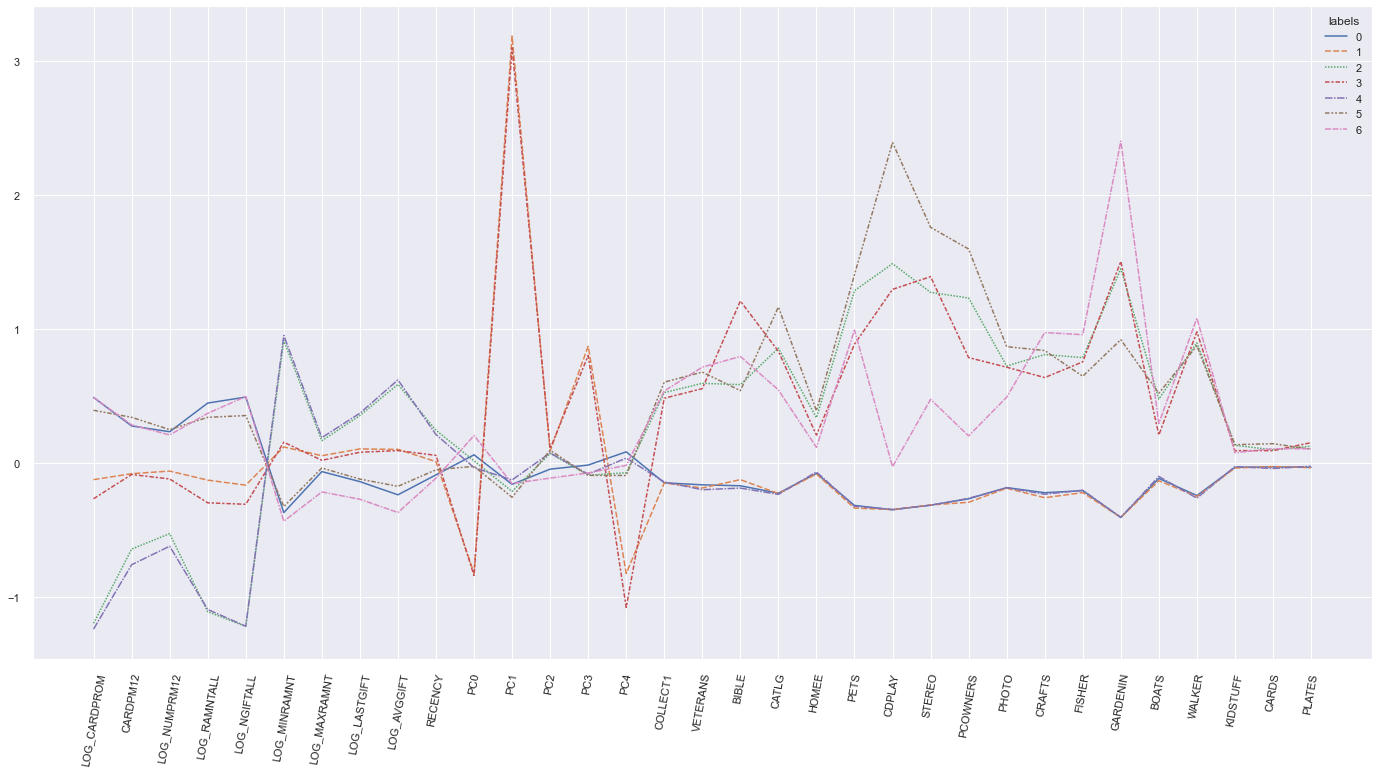

In [700]:
meanplot_df(df_[np.append(np.append(PG_feats_numeric_final , components_neighborhood),interest_feats)],df_['merged_labels'])

In [704]:
pd.concat([df['AGE'],df_['merged_labels']],axis =1)

AGE  merged_labels
CONTROLN                     
4         38.0              0
5         87.0              0
7          NaN              6
8          NaN              1
10        52.0              5
...        ...            ...
191772     NaN              4
191775    78.0              0
191777     NaN              0
191778    83.0              0
191779    70.0              4

[93760 rows x 2 columns]

From the above dendogram, the clusters of Promotion and Gift are equally distributed to the clusters of Neighborhood. We can come to a conclusion that it is not efficient to group these subset of clusters together. So, intuitively, each subset of cluster will be merged manually

## 5.2. Manually merging the results:

labels_neighborhood
- 0: Texas
- 1: Mahattan
- 2: Bronx


In [456]:
concat_labels = pd.concat([labels_interests, labels_mail, labels_neighborhood,labels_PG],axis = 1)
concat_labels['labels_mail'] = concat_labels['labels_mail'].fillna(value=3,axis = 0).astype(int)

concat_labels['labels_merged'] = concat_labels['labels_neighborhood'].astype(str) + concat_labels['labels_PG'].astype(str)

In [458]:
def labels_transform(x):
    if x == '11':
        return 0
    elif x == '10':
        return 1
    elif x == '12':
        return 2
    elif x == '01':
        return 3
    elif x == '00':
        return 4
    elif x == '02':
        return 5
    else:
        return 6
    
concat_labels['labels_merged'] = concat_labels['labels_merged'].map(labels_transform)

<AxesSubplot:xlabel='labels_merged', ylabel='count'>

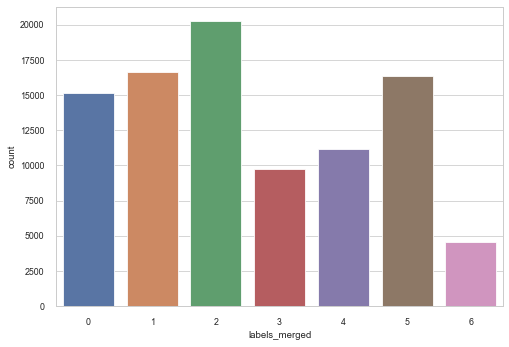

In [459]:
sns.countplot(x = concat_labels['labels_merged'])

# 6. Clusters interpretation:

- STATE       
- ZIP 
- AGE
- GENDER
- INCOME
- MAIL RESPONSE
- WEALTH1
- WEALTH2
- GEOCODE2

In [460]:
df_interpret = df.copy()

In [461]:
df_interpret = df_interpret.merge(concat_labels,left_index=True, right_index=True)

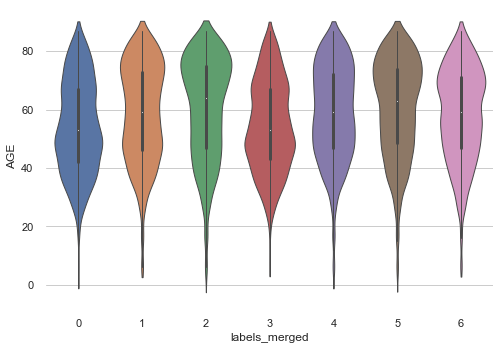

In [462]:
sns.set_theme(style="whitegrid")


# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(x = "labels_merged", y = 'AGE', data=df_interpret, bw=.2, cut=1, linewidth=1)

# Finalize the figure
ax.set(ylim=(-.7, 1.05))
sns.despine(left=True, bottom=True)

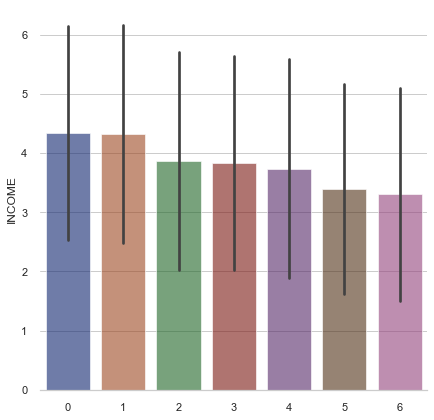

In [463]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_interpret, kind="bar",
    x="labels_merged", y="INCOME",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "INCOME")

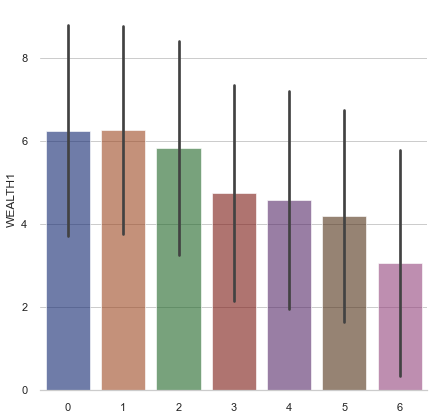

In [464]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_interpret, kind="bar",
    x="labels_merged", y="WEALTH1",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "WEALTH1")

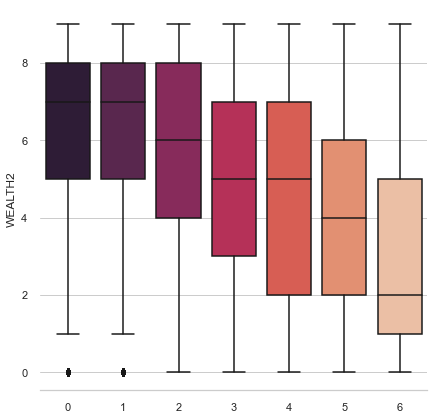

In [465]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_interpret, kind="box",
    x="labels_merged", y="WEALTH1",
    palette="rocket", height=6
)
g.despine(left=True)
g.set_axis_labels("", "WEALTH2")

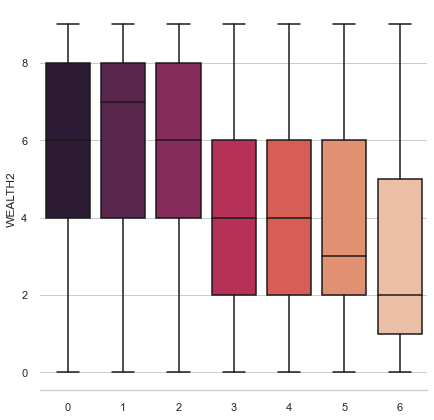

In [466]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_interpret, kind="box",
    x="labels_merged", y="WEALTH2",
    palette="rocket", height=6
)
g.despine(left=True)
g.set_axis_labels("", "WEALTH2")

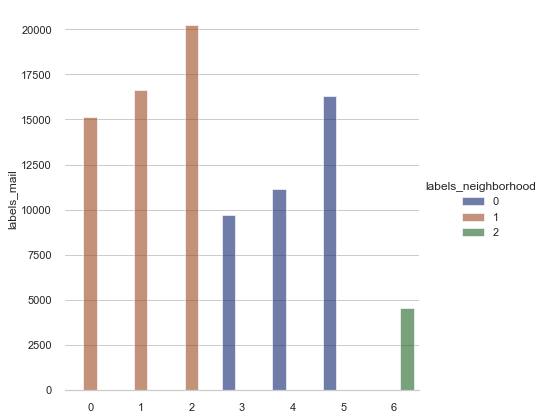

In [467]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_interpret, kind="count",
    x="labels_merged", hue = 'labels_neighborhood',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "labels_mail")

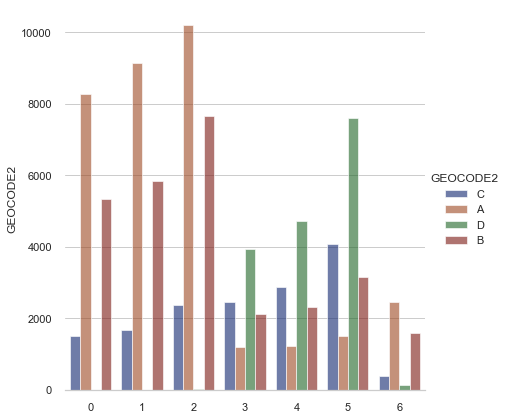

In [468]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_interpret, kind="count",
    x="labels_merged", hue = 'GEOCODE2',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "GEOCODE2")

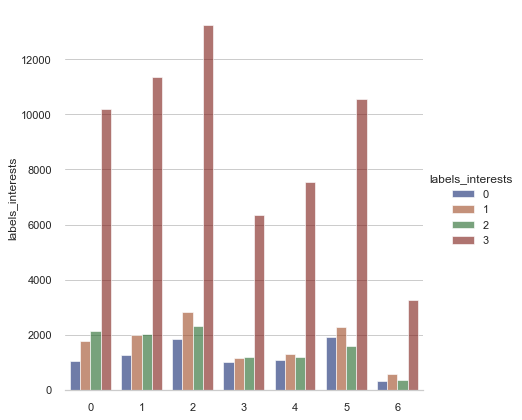

In [469]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_interpret, kind="count",
    x="labels_merged", hue = 'labels_interests',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "labels_interests")

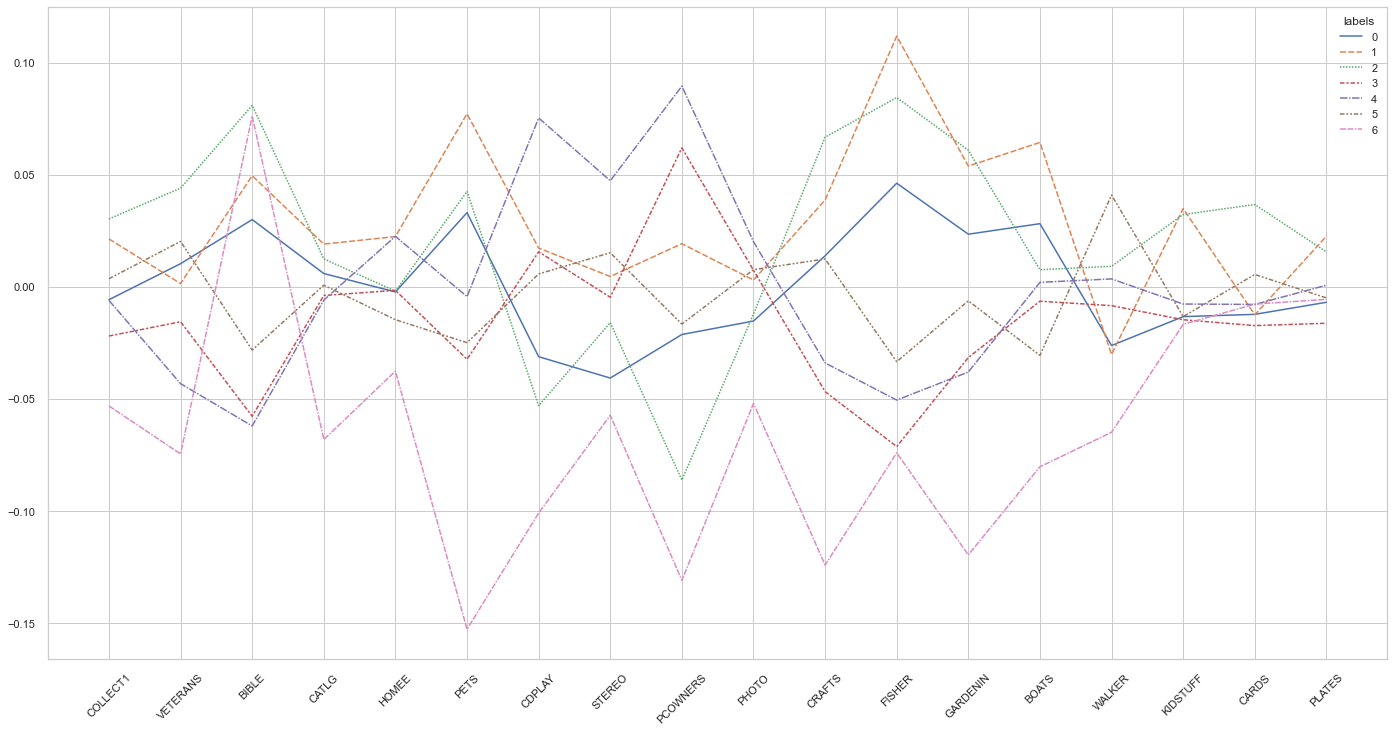

In [840]:
meanplot_df(pd.DataFrame(StandardScaler().fit_transform(df_interpret[interest_feats]), 
             columns=interest_feats,
             index=df_interpret[interest_feats].index), 
            df_interpret['labels_merged'])

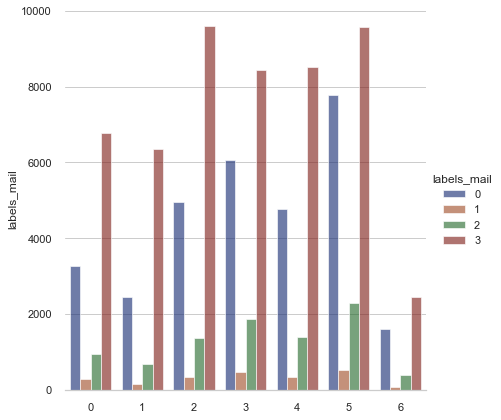

In [832]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_interpret, kind="count",
    x="labels_merged", hue = 'labels_mail',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "labels_mail")

In [885]:
zipcode = pd.read_csv('figures/us-zip-code-latitude-and-longitude.csv',sep=';')

In [908]:
df_zip = pd.merge(left = df_interpret.loc[:,['ZIP','labels_merged']],
         right = zipcode[['Zip','Latitude','Longitude']], 
         left_on='ZIP',right_on ='Zip')

In [944]:
import geopandas as gpd
from shapely.geometry import Point, Polygon


# 7. Marketing: